# Libraries Import

In [164]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler

from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,VotingClassifier,StackingClassifier

from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score, f1_score

# Dataset Import - from GoogleDrive

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
# !fusermount -u drive
# !google-drive-ocamlfuse drive

In [4]:
base_path = r'/content/gdrive/MyDrive/Inceptez_DataScience_Hackathon/'
train_path = base_path + 'train_loan_data.csv'
test_path = base_path + 'test_loan_data.csv'
results_path = base_path + 'test_results.csv'

In [5]:
raw_train = pd.read_csv(train_path)
raw_test = pd.read_csv(test_path)
raw_results = pd.read_csv(results_path)

In [6]:
raw_train.head(3)

,addr_state,annual_inc,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,application_type,...,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,term,title,total_acc,verification_status,loan_status
0,CO,85000.0,Jul-1997,10+ years,Deputy,744.0,740.0,E,MORTGAGE,Individual,...,0.0,debt_consolidation,5338.0,93.6,E1,60 months,Debt consolidation,8.0,Source Verified,Charged Off
1,CA,40000.0,Apr-1987,10+ years,Department of Veterans Affairs,724.0,720.0,B,RENT,Individual,...,0.0,debt_consolidation,19944.0,60.3,B1,36 months,Credit Loan,12.0,Verified,Fully Paid
2,FL,60000.0,Aug-2007,10+ years,Marble polishing,679.0,675.0,B,MORTGAGE,Individual,...,0.0,debt_consolidation,23199.0,88.5,B5,36 months,Debt consolidation,16.0,Source Verified,Fully Paid


In [7]:
raw_test.head(3)

,addr_state,annual_inc,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,application_type,...,pub_rec,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,term,title,total_acc,verification_status
0,MO,50000.0,May-2012,1 year,Tower technician,719.0,715.0,C,OWN,Individual,...,0.0,0.0,debt_consolidation,2568.0,9.8,C4,36 months,Debt consolidation,11.0,Source Verified
1,HI,92000.0,Dec-2001,10+ years,Supervisor,684.0,680.0,B,RENT,Individual,...,0.0,0.0,debt_consolidation,30394.0,75.4,B2,36 months,Debt consolidation,35.0,Source Verified
2,TX,89000.0,Mar-1989,10+ years,APPLICATIONS PROGRAMMER,679.0,675.0,B,MORTGAGE,Individual,...,0.0,0.0,credit_card,38400.0,75.3,B2,60 months,Credit card refinancing,41.0,Not Verified


In [8]:
raw_results.head(3)

,loan_status
0,Fully Paid
1,Fully Paid
2,Fully Paid


# EDA and Pre-processing Functions

In [9]:
def get_metadata(dataframe):

    '''Gets all the Metadata Information about the Dataframe'''

    print("\nBASIC INFORMATION\n")
    print(dataframe.info())
    print("=" * 150)

    print("STATISTICAL INFORMATION\n")
    display(dataframe.describe(include='all').T)
    print("=" * 150)

    print("Dataframe Shape\n", dataframe.shape)
    print("=" * 150)

    print("Number of Duplicate Rows\n", dataframe.duplicated().sum())
    print("=" * 150)

    print("NULL Values Check (Column-wise)")
    null_values_info = []
    for col in dataframe.columns:
        null_count = dataframe[col].isnull().sum()
        null_values_info.append([col, null_count, round((null_count/len(dataframe.index))*100, 2)])
    null_values = pd.DataFrame(null_values_info, columns=['ColumnName', 'NULL_count', 'Contribution(in %)']).sort_values(by=['NULL_count'], ascending=False)
    display(null_values[null_values['NULL_count']>0])
    print("-" * 150)
    print("NULL Values Check (Row-wise)")
    dataframe['NaN_count'] = dataframe.isnull().sum(axis=1)
    display(dataframe[dataframe['NaN_count']>int(len(dataframe.columns)/7)].sort_values(['NaN_count'], ascending=[False]))
    print("=" * 150)

    dataframe.drop(columns=['NaN_count'], inplace=True)
    print("UNIQUE VALUES IN CATEGORICAL COLUMN")
    unique_values_info = []
    categorical_cols = [var for var in dataframe.columns if dataframe[var].dtype=='O']
    numerical_cols = [var for var in dataframe.columns if dataframe[var].dtype!='O']
    for col in categorical_cols:
        unique_count = len(dataframe[col].unique())
        unique_values_info.append([col, dataframe[col].unique()[:11], unique_count, round((unique_count/len(dataframe.index))*100 , 2)])
    unique_values = pd.DataFrame(unique_values_info, columns=['ColumnName', 'sample_UniqueValues', 'UniqueValues_count', 'Unique%']).sort_values(by=['UniqueValues_count'], ascending=False)
    display(unique_values)
    print("=" * 150)

    print("Negative Valued Column - ")
    for col in numerical_cols:
        if min(dataframe[col]) < 0:
            print(col)
    print("=" * 150)
    display(dataframe.head(3))

In [10]:
def get_value_distribution_as_pie(df, column):
  plt.figure(figsize=(6,6))
  plt.pie(df[column].value_counts(dropna=False), labels=df[column].value_counts(dropna=False).index,autopct='%0.2f%%', colors=plt.cm.Pastel2.colors)
  plt.title(f"{column} Distribution")
  plt.legend(loc='best')
  # plt_save_path = base_path+'Plots/'+f'{column}_distribution.png'
  # plt.savefig(plt_save_path)
  # print(f"PLOT SAVED IN {plt_save_path}")

In [11]:
def impute_null_values_using_knn_imputer(df, column_to_be_imputed, column_type, columns_to_be_considered, n_neighbors=3):
  knn_imputer = KNNImputer(n_neighbors=n_neighbors)
  data_to_impute = df[columns_to_be_considered+[column_to_be_imputed]]
  # print('Value Counts (before imputation) : \n',data_to_impute[columns_to_be_considered].value_counts(dropna=False))
  value_counts_df_before = data_to_impute[column_to_be_imputed].value_counts(dropna=False).rename_axis('unique_values').reset_index(name='count_before_imputation').sort_values(by=['unique_values'])
  value_counts_df_before['unique_values'] = value_counts_df_before['unique_values'].fillna('NaN').astype('str')
  knn_imputer.fit(data_to_impute)
  imputed_data = knn_imputer.transform(data_to_impute)
  imputed_data = pd.DataFrame(imputed_data, columns= data_to_impute.columns)
  if column_type=='int':
    df[column_to_be_imputed] = imputed_data[column_to_be_imputed].astype(int)
  else:
    df[column_to_be_imputed] = imputed_data[column_to_be_imputed]
  # print('Null Counts (after imputation) : \n',df[columns_to_be_considered].value_counts(dropna=False))
  value_counts_df_after = df[column_to_be_imputed].astype('float').astype('str').value_counts(dropna=False).rename_axis('unique_values').reset_index(name='count_after_imputation').sort_values(by=['unique_values'])
  value_counts_df = value_counts_df_before.merge(value_counts_df_after, on=['unique_values'], how='left')
  value_counts_df['no_of_values_imputed'] = value_counts_df['count_after_imputation'] - value_counts_df['count_before_imputation']
  if column_type=='int':
    display(value_counts_df)
  return df

# EDA

In [12]:
get_metadata(raw_train)


BASIC INFORMATION

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   addr_state            80000 non-null  object 
 1   annual_inc            80000 non-null  float64
 2   earliest_cr_line      80000 non-null  object 
 3   emp_length            75412 non-null  object 
 4   emp_title             74982 non-null  object 
 5   fico_range_high       80000 non-null  float64
 6   fico_range_low        80000 non-null  float64
 7   grade                 80000 non-null  object 
 8   home_ownership        80000 non-null  object 
 9   application_type      80000 non-null  object 
 10  initial_list_status   80000 non-null  object 
 11  int_rate              80000 non-null  float64
 12  loan_amnt             80000 non-null  float64
 13  num_actv_bc_tl        76052 non-null  float64
 14  mort_acc              77229 non-null  float64
 15 

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
addr_state,80000,51,CA,11744,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_inc,80000.0,NaN,NaN,NaN,76046.143138,69020.055377,0.0,46000.0,65000.0,90000.0,7141778.0
earliest_cr_line,80000,640,Sep-2003,547,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_length,75412,11,10+ years,26278,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_title,74982,36661,Teacher,1278,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fico_range_high,80000.0,NaN,NaN,NaN,699.987975,31.73484,664.0,674.0,694.0,714.0,850.0
fico_range_low,80000.0,NaN,NaN,NaN,695.987813,31.734075,660.0,670.0,690.0,710.0,845.0
grade,80000,7,B,23502,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_ownership,80000,6,MORTGAGE,39628,NaN,NaN,NaN,NaN,NaN,NaN,NaN
application_type,80000,2,Individual,78446,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Dataframe Shape
 (80000, 28)
Number of Duplicate Rows
 0
NULL Values Check (Column-wise)


,ColumnName,NULL_count,Contribution(in %)
4,emp_title,5018,6.27
3,emp_length,4588,5.74
13,num_actv_bc_tl,3948,4.93
15,tot_cur_bal,3948,4.93
14,mort_acc,2771,3.46
24,title,970,1.21
21,revol_util,53,0.07
18,pub_rec_bankruptcies,31,0.04


------------------------------------------------------------------------------------------------------------------------------------------------------
NULL Values Check (Row-wise)


,addr_state,annual_inc,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,application_type,...,purpose,revol_bal,revol_util,sub_grade,term,title,total_acc,verification_status,loan_status,NaN_count
609,KY,36000.0,Mar-1979,NaN,NaN,709.0,705.0,C,RENT,Individual,...,debt_consolidation,12487.0,81.1,C3,36 months,FREE ME,11.0,Not Verified,Fully Paid,5
48048,OR,34626.0,Dec-2001,NaN,NaN,669.0,665.0,E,MORTGAGE,Individual,...,debt_consolidation,15769.0,72.7,E2,60 months,Debt Consolidation Loan,17.0,Verified,Fully Paid,5
54391,CA,40000.0,Dec-2006,NaN,NaN,719.0,715.0,A,RENT,Individual,...,debt_consolidation,6566.0,51.7,A4,36 months,Debt,7.0,Not Verified,Charged Off,5
54367,CA,42000.0,Sep-1962,NaN,NaN,794.0,790.0,B,OWN,Individual,...,home_improvement,0.0,0.0,B2,60 months,Home Improvement,11.0,Verified,Charged Off,5
54262,MI,18816.0,Jan-1999,NaN,NaN,699.0,695.0,B,MORTGAGE,Individual,...,credit_card,5082.0,92.4,B3,36 months,REFINANCE,12.0,Verified,Charged Off,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26820,KY,100000.0,Feb-1985,NaN,NaN,764.0,760.0,B,MORTGAGE,Individual,...,debt_consolidation,30329.0,35.1,B1,36 months,Debt Consolidation Loan,43.0,Verified,Fully Paid,5
24481,DC,40000.0,Jun-2001,NaN,NaN,714.0,710.0,B,RENT,Individual,...,debt_consolidation,11940.0,62.8,B2,36 months,Pay off credit card debt,31.0,Verified,Fully Paid,5
23633,CA,38000.0,Nov-2002,NaN,NaN,714.0,710.0,D,RENT,Individual,...,debt_consolidation,6618.0,98.8,D5,36 months,LOAN,6.0,Source Verified,Fully Paid,5
22044,GA,36648.0,Jan-1978,NaN,NaN,709.0,705.0,B,MORTGAGE,Individual,...,small_business,9502.0,65.1,B1,36 months,Trucking,21.0,Verified,Fully Paid,5


UNIQUE VALUES IN CATEGORICAL COLUMN


,ColumnName,sample_UniqueValues,UniqueValues_count,Unique%
3,emp_title,"[Deputy, Department of Veterans Affairs, Marbl...",36662,45.83
11,title,"[Debt consolidation, Credit Loan, Debt Connsol...",5350,6.69
1,earliest_cr_line,"[Jul-1997, Apr-1987, Aug-2007, Sep-1980, Jul-1...",640,0.80
0,addr_state,"[CO, CA, FL, IL, MD, NY, PA, WI, UT, TX, AL]",51,0.06
9,sub_grade,"[E1, B1, B5, B2, F5, D3, C1, C4, B4, D4, A5]",35,0.04
8,purpose,"[debt_consolidation, home_improvement, credit_...",14,0.02
2,emp_length,"[10+ years, nan, 3 years, < 1 year, 1 year, 8 ...",12,0.01
4,grade,"[E, B, F, D, C, A, G]",7,0.01
5,home_ownership,"[MORTGAGE, RENT, OWN, ANY, NONE, OTHER]",6,0.01
12,verification_status,"[Source Verified, Verified, Not Verified]",3,0.00


Negative Valued Column - 


,addr_state,annual_inc,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,application_type,...,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,term,title,total_acc,verification_status,loan_status
0,CO,85000.0,Jul-1997,10+ years,Deputy,744.0,740.0,E,MORTGAGE,Individual,...,0.0,debt_consolidation,5338.0,93.6,E1,60 months,Debt consolidation,8.0,Source Verified,Charged Off
1,CA,40000.0,Apr-1987,10+ years,Department of Veterans Affairs,724.0,720.0,B,RENT,Individual,...,0.0,debt_consolidation,19944.0,60.3,B1,36 months,Credit Loan,12.0,Verified,Fully Paid
2,FL,60000.0,Aug-2007,10+ years,Marble polishing,679.0,675.0,B,MORTGAGE,Individual,...,0.0,debt_consolidation,23199.0,88.5,B5,36 months,Debt consolidation,16.0,Source Verified,Fully Paid


In [13]:
get_metadata(raw_test)


BASIC INFORMATION

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   addr_state            20000 non-null  object 
 1   annual_inc            20000 non-null  float64
 2   earliest_cr_line      20000 non-null  object 
 3   emp_length            18742 non-null  object 
 4   emp_title             18622 non-null  object 
 5   fico_range_high       20000 non-null  float64
 6   fico_range_low        20000 non-null  float64
 7   grade                 20000 non-null  object 
 8   home_ownership        20000 non-null  object 
 9   application_type      20000 non-null  object 
 10  initial_list_status   20000 non-null  object 
 11  int_rate              20000 non-null  float64
 12  loan_amnt             20000 non-null  float64
 13  num_actv_bc_tl        18989 non-null  float64
 14  mort_acc              19296 non-null  float64
 15 

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
addr_state,20000,50,CA,2865,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_inc,20000.0,NaN,NaN,NaN,76497.649333,85680.966779,0.0,45000.0,65000.0,90000.0,9522972.0
earliest_cr_line,20000,568,Oct-2001,160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_length,18742,11,10+ years,6579,NaN,NaN,NaN,NaN,NaN,NaN,NaN
emp_title,18622,11180,Teacher,357,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fico_range_high,20000.0,NaN,NaN,NaN,700.2044,31.768558,664.0,674.0,694.0,714.0,850.0
fico_range_low,20000.0,NaN,NaN,NaN,696.20425,31.767853,660.0,670.0,690.0,710.0,845.0
grade,20000,7,B,5756,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_ownership,20000,4,MORTGAGE,9900,NaN,NaN,NaN,NaN,NaN,NaN,NaN
application_type,20000,2,Individual,19610,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Dataframe Shape
 (20000, 27)
Number of Duplicate Rows
 0
NULL Values Check (Column-wise)


,ColumnName,NULL_count,Contribution(in %)
4,emp_title,1378,6.89
3,emp_length,1258,6.29
13,num_actv_bc_tl,1011,5.06
15,tot_cur_bal,1011,5.06
14,mort_acc,704,3.52
24,title,247,1.23
21,revol_util,13,0.06
18,pub_rec_bankruptcies,11,0.06


------------------------------------------------------------------------------------------------------------------------------------------------------
NULL Values Check (Row-wise)


,addr_state,annual_inc,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,application_type,...,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,term,title,total_acc,verification_status,NaN_count
44,GA,84000.00,Dec-1999,NaN,NaN,714.0,710.0,B,RENT,Individual,...,0.0,debt_consolidation,12104.0,42.0,B5,36 months,Final Debt Consolidation,22.0,Verified,5
9559,FL,25000.00,Oct-1987,NaN,NaN,739.0,735.0,A,MORTGAGE,Individual,...,0.0,debt_consolidation,163.0,3.2,A4,36 months,Debt Consolidation Loan,30.0,Verified,5
19092,LA,124569.00,Feb-1993,NaN,NaN,684.0,680.0,D,RENT,Individual,...,0.0,debt_consolidation,24029.0,74.1,D5,36 months,Credit Card debt consolidation Loan,18.0,Source Verified,5
18934,TX,126000.00,Sep-1964,NaN,NaN,769.0,765.0,A,MORTGAGE,Individual,...,0.0,major_purchase,21965.0,32.9,A3,36 months,M1028,76.0,Verified,5
17918,PA,28800.00,Jun-1991,NaN,NaN,689.0,685.0,B,MORTGAGE,Individual,...,1.0,credit_card,7998.0,53.3,B4,36 months,credit_card,26.0,Not Verified,5
16627,PA,30000.00,Sep-1999,NaN,NaN,689.0,685.0,C,RENT,Individual,...,0.0,debt_consolidation,1971.0,24.6,C1,36 months,debt consolodation,15.0,Not Verified,5
16389,IL,85740.84,Jan-1978,NaN,NaN,759.0,755.0,A,MORTGAGE,Individual,...,0.0,debt_consolidation,36901.0,70.8,A4,36 months,debt consolidation,31.0,Verified,5
16198,VA,28800.00,Jul-1987,NaN,NaN,754.0,750.0,A,MORTGAGE,Individual,...,0.0,debt_consolidation,8982.0,81.7,A1,36 months,debt consolidation,12.0,Verified,5
15378,UT,17000.00,Sep-2000,NaN,NaN,709.0,705.0,B,RENT,Individual,...,0.0,credit_card,8515.0,39.1,B3,36 months,Time to consolidate and leave ridiculous credi...,10.0,Not Verified,5
15243,TX,26300.00,Jul-1972,NaN,NaN,779.0,775.0,A,OWN,Individual,...,0.0,credit_card,12450.0,25.5,A2,36 months,Credit Card Loan,13.0,Not Verified,5


UNIQUE VALUES IN CATEGORICAL COLUMN


,ColumnName,sample_UniqueValues,UniqueValues_count,Unique%
3,emp_title,"[Tower technician, Supervisor, APPLICATIONS PR...",11181,55.91
11,title,"[Debt consolidation, Credit card refinancing, ...",1624,8.12
1,earliest_cr_line,"[May-2012, Dec-2001, Mar-1989, Nov-2004, Feb-1...",568,2.84
0,addr_state,"[MO, HI, TX, CA, MI, NJ, FL, GA, MD, AL, NC]",50,0.25
9,sub_grade,"[C4, B2, C1, B5, A3, D3, B3, B1, E5, B4, A4]",35,0.18
8,purpose,"[debt_consolidation, credit_card, home_improve...",14,0.07
2,emp_length,"[1 year, 10+ years, 9 years, nan, < 1 year, 2 ...",12,0.06
4,grade,"[C, B, A, D, E, F, G]",7,0.03
5,home_ownership,"[OWN, RENT, MORTGAGE, ANY]",4,0.02
12,verification_status,"[Source Verified, Not Verified, Verified]",3,0.01


Negative Valued Column - 


,addr_state,annual_inc,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,application_type,...,pub_rec,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,term,title,total_acc,verification_status
0,MO,50000.0,May-2012,1 year,Tower technician,719.0,715.0,C,OWN,Individual,...,0.0,0.0,debt_consolidation,2568.0,9.8,C4,36 months,Debt consolidation,11.0,Source Verified
1,HI,92000.0,Dec-2001,10+ years,Supervisor,684.0,680.0,B,RENT,Individual,...,0.0,0.0,debt_consolidation,30394.0,75.4,B2,36 months,Debt consolidation,35.0,Source Verified
2,TX,89000.0,Mar-1989,10+ years,APPLICATIONS PROGRAMMER,679.0,675.0,B,MORTGAGE,Individual,...,0.0,0.0,credit_card,38400.0,75.3,B2,60 months,Credit card refinancing,41.0,Not Verified


## Target Data Distribution

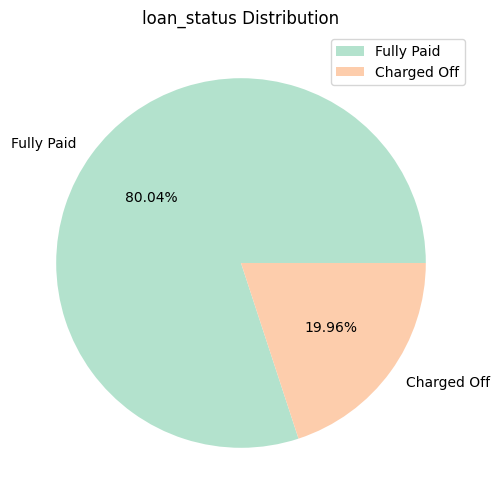

In [14]:
get_value_distribution_as_pie(raw_train, column='loan_status')

**Inference:** From the above plot, it is clearly visible that the data is ***IMBALANCED***

In [15]:
categorical_cols = [var for var in raw_train.columns if raw_train[var].dtype=='O']
categorical_cols.remove('loan_status')
numerical_cols = [var for var in raw_train.columns if raw_train[var].dtype!='O']
print(f"Categorical Features({len(categorical_cols)}):", categorical_cols)
print(f"Numerical Features({len(numerical_cols)}):", numerical_cols)

Categorical Features(13): ['addr_state', 'earliest_cr_line', 'emp_length', 'emp_title', 'grade', 'home_ownership', 'application_type', 'initial_list_status', 'purpose', 'sub_grade', 'term', 'title', 'verification_status']
Numerical Features(14): ['annual_inc', 'fico_range_high', 'fico_range_low', 'int_rate', 'loan_amnt', 'num_actv_bc_tl', 'mort_acc', 'tot_cur_bal', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util', 'total_acc']


In [16]:
unique_values_info = []
for col in categorical_cols:
    unique_count = len(raw_train[col].unique())
    unique_values_info.append([col, raw_train[col].unique()[:11], unique_count, round((unique_count/len(raw_train.index))*100 , 2)])
unique_values = pd.DataFrame(unique_values_info, columns=['ColumnName', 'sample_UniqueValues', 'UniqueValues_count', 'Unique%']).sort_values(by=['UniqueValues_count'], ascending=False)
unique_values

,ColumnName,sample_UniqueValues,UniqueValues_count,Unique%
3,emp_title,"[Deputy, Department of Veterans Affairs, Marbl...",36662,45.83
11,title,"[Debt consolidation, Credit Loan, Debt Connsol...",5350,6.69
1,earliest_cr_line,"[Jul-1997, Apr-1987, Aug-2007, Sep-1980, Jul-1...",640,0.80
0,addr_state,"[CO, CA, FL, IL, MD, NY, PA, WI, UT, TX, AL]",51,0.06
9,sub_grade,"[E1, B1, B5, B2, F5, D3, C1, C4, B4, D4, A5]",35,0.04
8,purpose,"[debt_consolidation, home_improvement, credit_...",14,0.02
2,emp_length,"[10+ years, nan, 3 years, < 1 year, 1 year, 8 ...",12,0.01
4,grade,"[E, B, F, D, C, A, G]",7,0.01
5,home_ownership,"[MORTGAGE, RENT, OWN, ANY, NONE, OTHER]",6,0.01
12,verification_status,"[Source Verified, Verified, Not Verified]",3,0.00


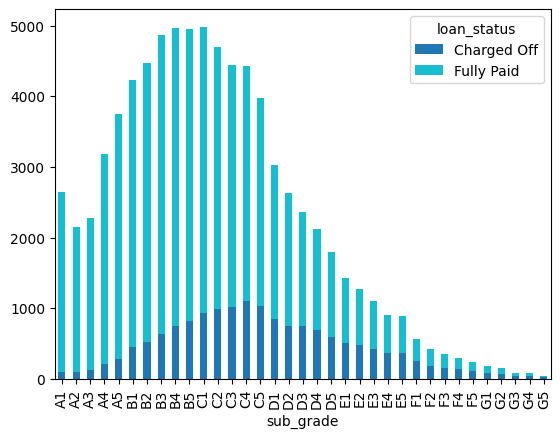

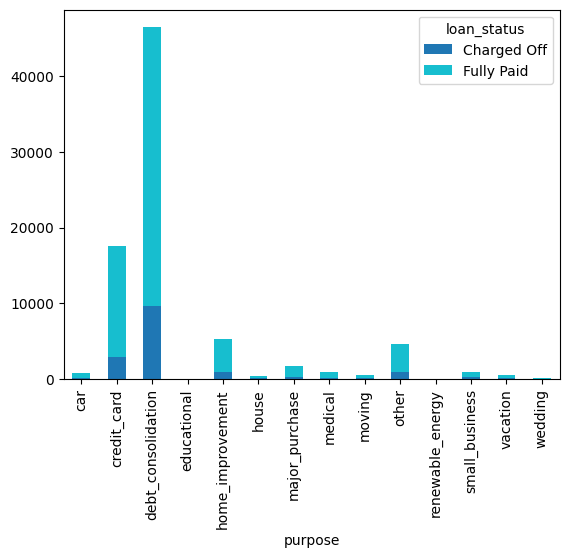

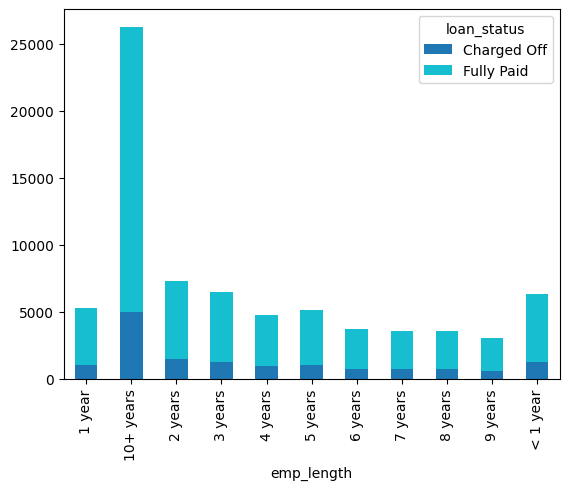

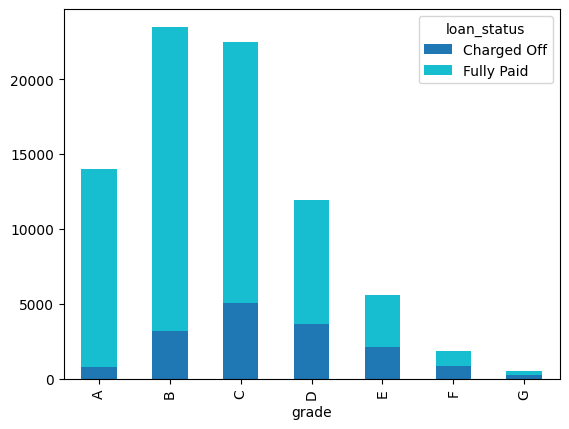

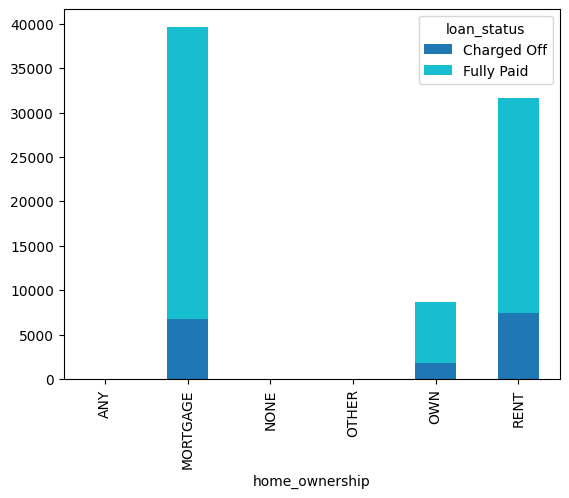

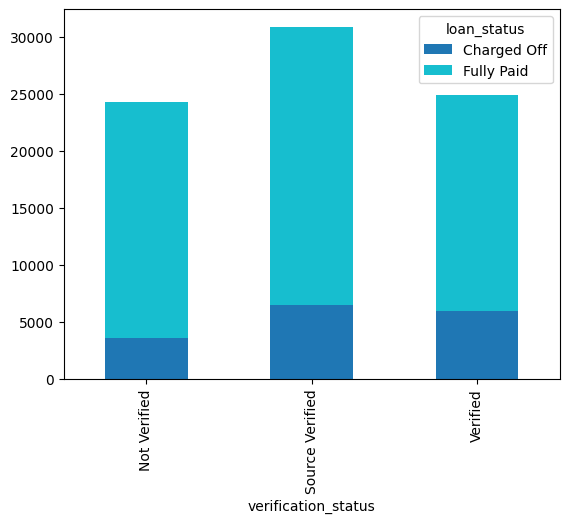

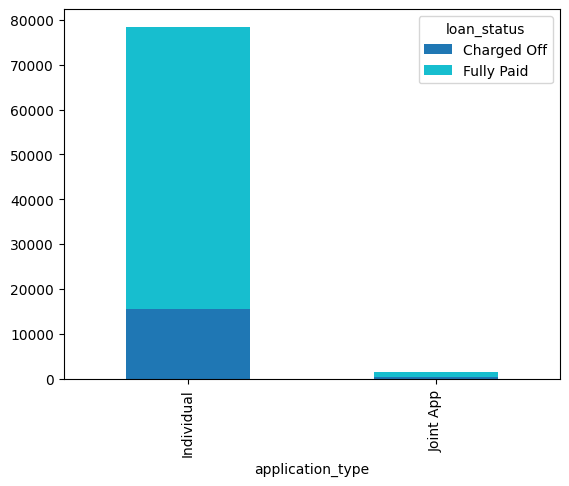

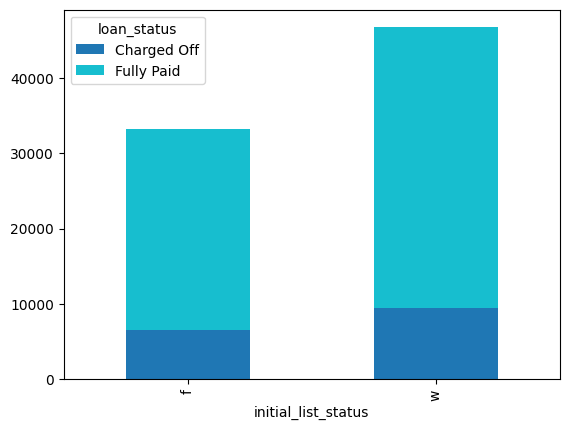

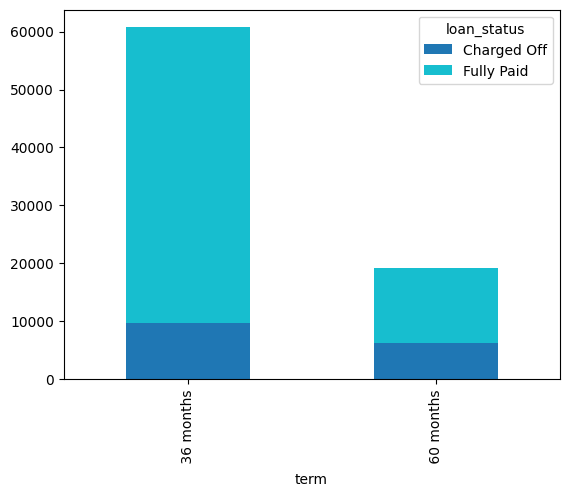

In [17]:
less_unique_cat_cols = unique_values[unique_values['UniqueValues_count']<=50]['ColumnName'].tolist()
# less_unique_cat_cols.remove('loan_status')
for col in less_unique_cat_cols:
  pd.crosstab(index=raw_train[col], columns=raw_train['loan_status']).plot(kind='bar', stacked=True, colormap='tab10')

In [18]:
# cross_tab = pd.crosstab(index=raw_train['addr_state'], columns=raw_train['loan_status'])
# cross_tab_prop = pd.crosstab(index=raw_train['addr_state'], columns=raw_train['loan_status'], normalize="index")

In [19]:
# for n, x in enumerate([*cross_tab.index.values]):
#     for proportion in cross_tab_prop.loc[x]:
#         print(f'n: {n}, x: {x},  proportion: {proportion}')

In [20]:
# cross_tab_prop.plot(kind='barh',
#                     stacked=True,
#                     colormap='tab10',
#                     figsize=(8,16))
# # plt.legend(loc="lower left", ncol=2)
# plt.xlabel("loan_status")
# plt.ylabel("annual_inc")
# for n, x in enumerate([*cross_tab.index.values]):
#     for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x], cross_tab.loc[x], cross_tab_prop.loc[x].cumsum()):
#         plt.text(x= (y_loc - proportion) + (proportion / 2 -0.05),
#                 y= n - 0.08 ,
#                 s=f'{count} ({np.round(proportion * 100, 1)}%)',
#                 rotation=0,
#                 fontsize=8)
# plt.show()

In [21]:
# less_unique_cat_cols = unique_values[unique_values['UniqueValues_count']<=50]['ColumnName'].tolist()
# for cat_col in less_unique_cat_cols:
#   for num_col in numerical_cols:
#     cross_tab = pd.crosstab(index=raw_train[cat_col], columns=raw_train['loan_status'])
#     cross_tab_prop = pd.crosstab(index=raw_train[cat_col], columns=raw_train['loan_status'], normalize="index")
#     width, height = plt.rcParams.get('figure.figsize')
#     cross_tab_prop.plot(kind='barh',
#                         stacked=True,
#                         colormap='tab10',
#                         figsize=((len(cat_col)/3) *2, height*2))
#     plt.title(f"{cat_col} vs {num_col} with hue on loan_status")
#     plt.legend(loc="lower left", ncol=2)
#     plt.xlabel(num_col)
#     plt.ylabel(cat_col)
#     for n, x in enumerate([*cross_tab.index.values]):
#       for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x], cross_tab.loc[x], cross_tab_prop.loc[x].cumsum()):
#         plt.text(x=(y_loc - proportion) + (proportion / 2 -0.05),
#                 y=n-0.08 ,
#                 s=f'{count} ({np.round(proportion * 100, 1)}%)',
#                 color="black",
#                 rotation=0,
#                 fontsize=8)
#     plt.show()
#     break

In [22]:
# dfp = raw_train.pivot_table(index='addr_state', columns='loan_status', values='annual_inc', aggfunc='nunique')
# # get the total value for the column
# totals = dfp.sum()
# # plot
# p1 = dfp.plot(kind='bar', stacked=True, figsize=(16,4), rot=90, color=['orangered', 'skyblue'], xlabel='State of Address', ylabel='Annual Income', title="Annual Income vs State of Address")

# # add annotations
# for tot, p in zip(totals, p1.containers):
#     labels = [f'{(v.get_height()/tot)*100:0.2f}%' for v in p]
#     p1.bar_label(p, labels=labels, label_type='edge', fontsize=6, rotation=90, padding=2)
# p1.margins(y=0.2)
# plt.show()

# Pre-processing

Combining Train and Test data

In [23]:
data = pd.concat([raw_train, raw_test], ignore_index=True)

Analysing NULL and Unique values

In [24]:
null_values_info = []
for col in data.drop(columns=['loan_status']).columns:
  null_count = data[col].isnull().sum()
  null_values_info.append([col, null_count, round((null_count/len(data.index))*100, 2)])
null_values = pd.DataFrame(null_values_info, columns=['ColumnName', 'NULL_count', 'Contribution(in %)']).sort_values(by=['NULL_count'], ascending=False)
display(null_values[null_values['NULL_count']>0])

,ColumnName,NULL_count,Contribution(in %)
4,emp_title,6396,6.40
3,emp_length,5846,5.85
13,num_actv_bc_tl,4959,4.96
15,tot_cur_bal,4959,4.96
14,mort_acc,3475,3.48
24,title,1217,1.22
21,revol_util,66,0.07
18,pub_rec_bankruptcies,42,0.04


In [25]:
print("UNIQUE VALUES IN CATEGORICAL COLUMN")
unique_values_info = []
categorical_cols = [var for var in data.columns if data[var].dtype=='O']
numerical_cols = [var for var in data.columns if data[var].dtype!='O']
for col in categorical_cols:
  unique_count = len(data[col].unique())
  unique_values_info.append([col, data[col].unique()[:11], unique_count, round((unique_count/len(data.index))*100 , 2)])
unique_values = pd.DataFrame(unique_values_info, columns=['ColumnName', 'sample_UniqueValues', 'UniqueValues_count', 'Unique%']).sort_values(by=['UniqueValues_count'], ascending=False)
unique_values

UNIQUE VALUES IN CATEGORICAL COLUMN


,ColumnName,sample_UniqueValues,UniqueValues_count,Unique%
3,emp_title,"[Deputy, Department of Veterans Affairs, Marbl...",44317,44.32
11,title,"[Debt consolidation, Credit Loan, Debt Connsol...",6507,6.51
1,earliest_cr_line,"[Jul-1997, Apr-1987, Aug-2007, Sep-1980, Jul-1...",644,0.64
0,addr_state,"[CO, CA, FL, IL, MD, NY, PA, WI, UT, TX, AL]",51,0.05
9,sub_grade,"[E1, B1, B5, B2, F5, D3, C1, C4, B4, D4, A5]",35,0.03
8,purpose,"[debt_consolidation, home_improvement, credit_...",14,0.01
2,emp_length,"[10+ years, nan, 3 years, < 1 year, 1 year, 8 ...",12,0.01
4,grade,"[E, B, F, D, C, A, G]",7,0.01
5,home_ownership,"[MORTGAGE, RENT, OWN, ANY, NONE, OTHER]",6,0.01
12,verification_status,"[Source Verified, Verified, Not Verified]",3,0.00


Dropping columns:
*  **emp_title** - This column holds more unique values(44.32%) and 6.4% of NULL values
*  **title** - This column holds 6507 unique values and 1.22% of NaN values

In [26]:
data = data.drop(columns=['emp_title', 'title'])

### earliest_cr_line

*  Converting the Month-Year format **earliest_cr_line** column to **earliest_cr_line_month** (Month) and **earliest_cr_line_year** (Year) separately
*  Dropping the **earliest_cr_line** column

In [27]:
data['earliest_cr_line_year'], data['earliest_cr_line_month'] = pd.DatetimeIndex(data['earliest_cr_line']).year, pd.DatetimeIndex(data['earliest_cr_line']).month
data = data.drop(columns = 'earliest_cr_line')
data.head(3)

,addr_state,annual_inc,emp_length,fico_range_high,fico_range_low,grade,home_ownership,application_type,initial_list_status,int_rate,...,purpose,revol_bal,revol_util,sub_grade,term,total_acc,verification_status,loan_status,earliest_cr_line_year,earliest_cr_line_month
0,CO,85000.0,10+ years,744.0,740.0,E,MORTGAGE,Individual,w,18.99,...,debt_consolidation,5338.0,93.6,E1,60 months,8.0,Source Verified,Charged Off,1997,7
1,CA,40000.0,10+ years,724.0,720.0,B,RENT,Individual,w,10.16,...,debt_consolidation,19944.0,60.3,B1,36 months,12.0,Verified,Fully Paid,1987,4
2,FL,60000.0,10+ years,679.0,675.0,B,MORTGAGE,Individual,w,11.47,...,debt_consolidation,23199.0,88.5,B5,36 months,16.0,Source Verified,Fully Paid,2007,8


### emp_length

*  The **emp_length** columns values are suffixed with *' years'*, so splitting the column based on this siffix.
*  Replacing the following to maintain a standard format:
  *  10+ years : 10 years
  *  1 year : 1 years
  *  < 1 year : 1 years



In [28]:
data['emp_length'] = data['emp_length'].replace({'10+ years': '10 years', '1 year':'1', '< 1 year':'1 years'}).str.split(" years",n=1, expand=True)[0]
data.head(3)

,addr_state,annual_inc,emp_length,fico_range_high,fico_range_low,grade,home_ownership,application_type,initial_list_status,int_rate,...,purpose,revol_bal,revol_util,sub_grade,term,total_acc,verification_status,loan_status,earliest_cr_line_year,earliest_cr_line_month
0,CO,85000.0,10,744.0,740.0,E,MORTGAGE,Individual,w,18.99,...,debt_consolidation,5338.0,93.6,E1,60 months,8.0,Source Verified,Charged Off,1997,7
1,CA,40000.0,10,724.0,720.0,B,RENT,Individual,w,10.16,...,debt_consolidation,19944.0,60.3,B1,36 months,12.0,Verified,Fully Paid,1987,4
2,FL,60000.0,10,679.0,675.0,B,MORTGAGE,Individual,w,11.47,...,debt_consolidation,23199.0,88.5,B5,36 months,16.0,Source Verified,Fully Paid,2007,8


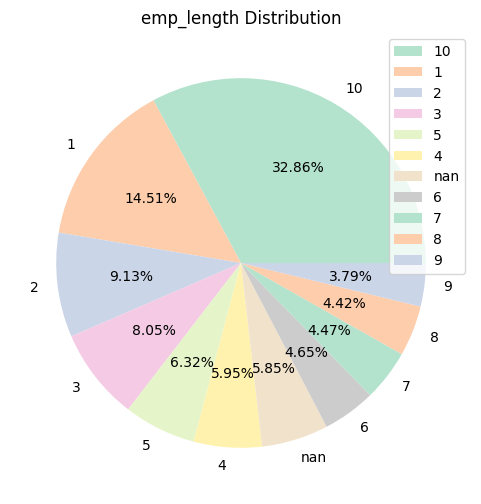

In [29]:
get_value_distribution_as_pie(data, column='emp_length')

Imputing NULL values using KNN-Imputer

In [30]:
emp_len_imputed = impute_null_values_using_knn_imputer(data,
                        column_to_be_imputed='emp_length',
                        column_type = 'int',
                        columns_to_be_considered=['annual_inc', 'earliest_cr_line_year', 'loan_amnt'],
                        n_neighbors=3)

,unique_values,count_before_imputation,count_after_imputation,no_of_values_imputed
0,1,14510,NaN,NaN
1,10,32857,NaN,NaN
2,2,9129,NaN,NaN
3,3,8054,NaN,NaN
4,4,5953,NaN,NaN
5,5,6322,NaN,NaN
6,6,4648,NaN,NaN
7,7,4471,NaN,NaN
8,8,4419,NaN,NaN
9,9,3791,NaN,NaN


### fico_range_high , fico_range_low

(array([34289., 26869., 18334.,  8049.,  5820.,  3261.,  1917.,   861.,
          494.,   106.]),
 array([664. , 682.6, 701.2, 719.8, 738.4, 757. , 775.6, 794.2, 812.8,
        831.4, 850. ]),
 <BarContainer object of 10 artists>)

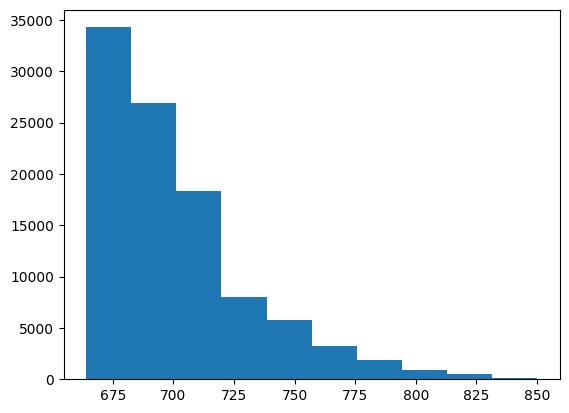

In [31]:
plt.hist(data=emp_len_imputed, x='fico_range_high')

(array([34289., 26869., 18334.,  8049.,  5820.,  3261.,  1532.,  1246.,
          494.,   106.]),
 array([660. , 678.5, 697. , 715.5, 734. , 752.5, 771. , 789.5, 808. ,
        826.5, 845. ]),
 <BarContainer object of 10 artists>)

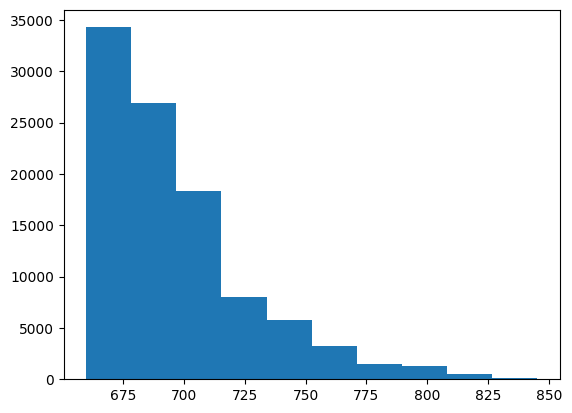

In [32]:
plt.hist(data=emp_len_imputed, x='fico_range_low')

<Axes: xlabel='fico_range_high', ylabel='fico_range_low'>

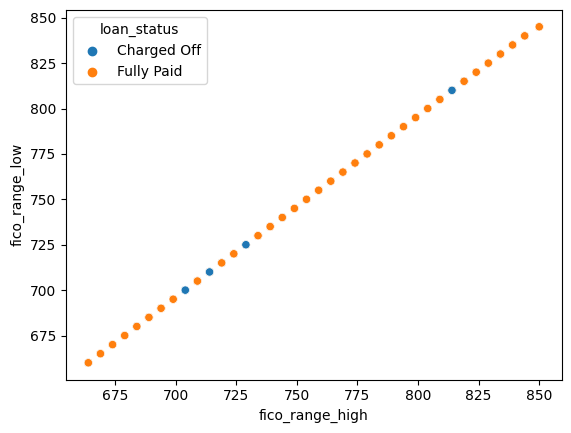

In [33]:
sns.scatterplot(data=emp_len_imputed, x='fico_range_high', y='fico_range_low', hue='loan_status')

In [34]:
emp_len_imputed[emp_len_imputed['fico_range_low']>emp_len_imputed['fico_range_high']]

,addr_state,annual_inc,emp_length,fico_range_high,fico_range_low,grade,home_ownership,application_type,initial_list_status,int_rate,...,purpose,revol_bal,revol_util,sub_grade,term,total_acc,verification_status,loan_status,earliest_cr_line_year,earliest_cr_line_month


Creating **fico_range_average** as the mean of **fico_range_low** and **fico_range_high**

In [35]:
emp_len_imputed['fico_range_average'] = (emp_len_imputed['fico_range_low'] + emp_len_imputed['fico_range_high']) / 2
fico_range_avg = emp_len_imputed.drop(columns=['fico_range_low', 'fico_range_high'])
fico_range_avg.head(3)

,addr_state,annual_inc,emp_length,grade,home_ownership,application_type,initial_list_status,int_rate,loan_amnt,num_actv_bc_tl,...,revol_bal,revol_util,sub_grade,term,total_acc,verification_status,loan_status,earliest_cr_line_year,earliest_cr_line_month,fico_range_average
0,CO,85000.0,10,E,MORTGAGE,Individual,w,18.99,18075.0,1.0,...,5338.0,93.6,E1,60 months,8.0,Source Verified,Charged Off,1997,7,742.0
1,CA,40000.0,10,B,RENT,Individual,w,10.16,8800.0,4.0,...,19944.0,60.3,B1,36 months,12.0,Verified,Fully Paid,1987,4,722.0
2,FL,60000.0,10,B,MORTGAGE,Individual,w,11.47,18000.0,4.0,...,23199.0,88.5,B5,36 months,16.0,Source Verified,Fully Paid,2007,8,677.0


<Axes: xlabel='fico_range_average', ylabel='Count'>

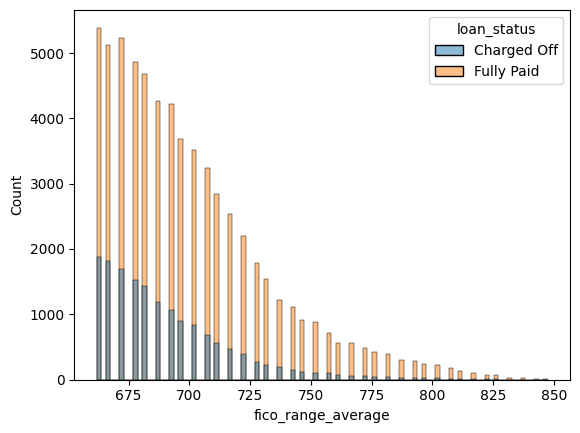

In [36]:
sns.histplot(data=fico_range_avg, x='fico_range_average', hue='loan_status')

### grade

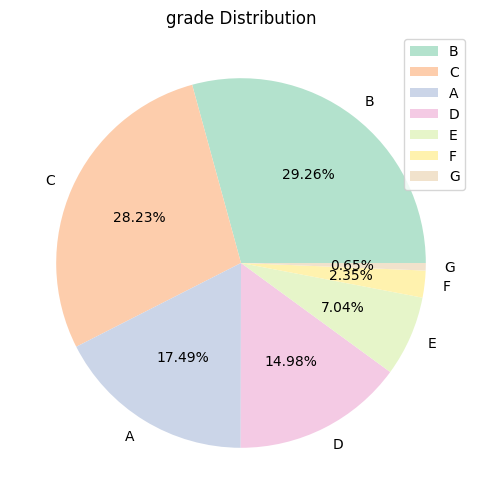

In [37]:
get_value_distribution_as_pie(fico_range_avg, column='grade')

### home_ownership

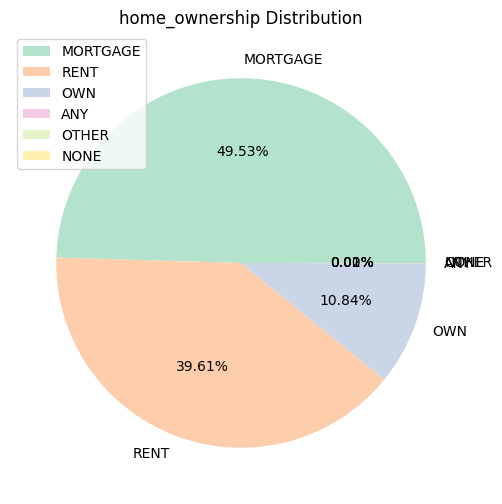

In [38]:
get_value_distribution_as_pie(fico_range_avg, column='home_ownership')

In [39]:
fico_range_avg['home_ownership'].value_counts(dropna=False)

MORTGAGE    49528
RENT        39605
OWN         10835
ANY            21
OTHER           7
NONE            4
Name: home_ownership, dtype: int64

The following pre-process should be done:
*  The NaN value is indicated as **NONE**
*  'ANY' and 'OTHER' values are combined to **'OTHER'**
*  NONE is imputed with the **mode** value

In [40]:
fico_range_avg['home_ownership'].mode()

0    MORTGAGE
Name: home_ownership, dtype: object

In [41]:
fico_range_avg['home_ownership'] = fico_range_avg['home_ownership'].replace({'ANY': 'OTHER', 'NONE': fico_range_avg['home_ownership'].mode()[0]})
fico_range_avg['home_ownership'].value_counts(dropna=False)

MORTGAGE    49532
RENT        39605
OWN         10835
OTHER          28
Name: home_ownership, dtype: int64

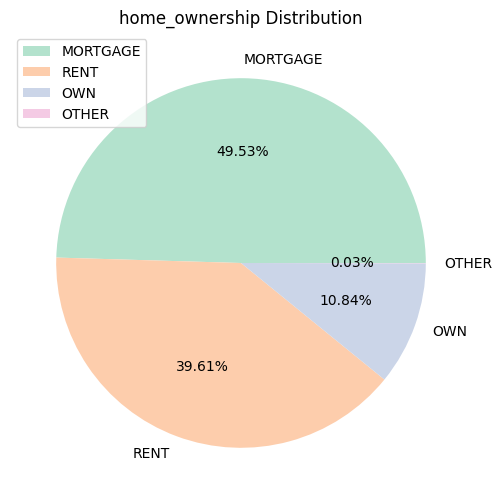

In [42]:
get_value_distribution_as_pie(fico_range_avg, column='home_ownership')

### application_type

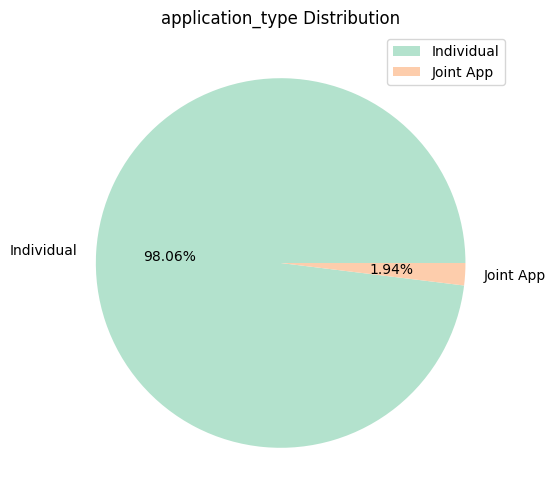

In [43]:
get_value_distribution_as_pie(fico_range_avg, column='application_type')

### initial_list_status

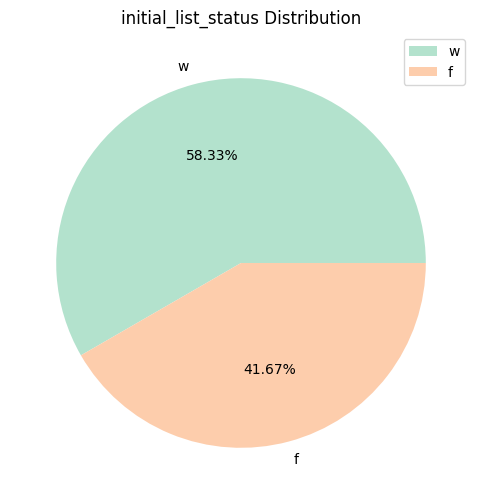

In [44]:
get_value_distribution_as_pie(fico_range_avg, column='initial_list_status')

### int_rate

<Axes: xlabel='int_rate', ylabel='Count'>

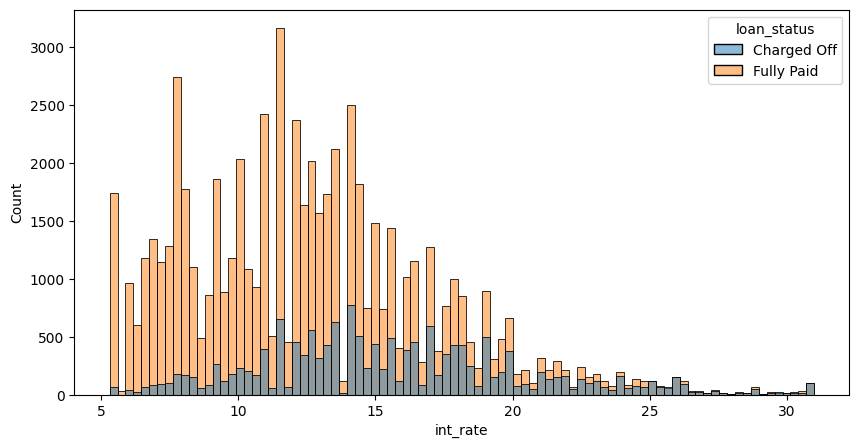

In [45]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data=fico_range_avg, x='int_rate', hue='loan_status', ax=ax)


### loan_amnt

<Axes: xlabel='loan_amnt', ylabel='Count'>

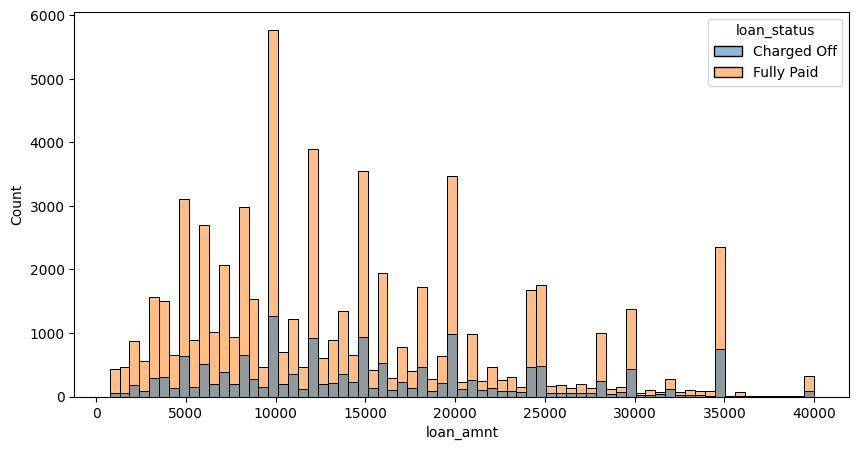

In [46]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data=fico_range_avg, x='loan_amnt', hue='loan_status', ax=ax)

### num_actv_bc_tl

In [47]:
actv_bc_tl = impute_null_values_using_knn_imputer(fico_range_avg,
                                                  column_to_be_imputed='num_actv_bc_tl',
                                                  column_type='int',
                                                  columns_to_be_considered=['loan_amnt', 'fico_range_average'],
                                                  n_neighbors=3)

,unique_values,count_before_imputation,count_after_imputation,no_of_values_imputed
0,0.0,2051,2065.0,14.0
1,1.0,11019,11519.0,500.0
2,2.0,19667,21100.0,1433.0
3,3.0,20224,21744.0,1520.0
4,4.0,15685,16536.0,851.0
5,5.0,10575,10986.0,411.0
6,6.0,6489,6663.0,174.0
7,7.0,3753,3800.0,47.0
8,8.0,2204,2208.0,4.0
9,9.0,1353,1358.0,5.0


### mort_acc

In [48]:
mort_acc = impute_null_values_using_knn_imputer(actv_bc_tl,
                                                column_to_be_imputed='mort_acc',
                                                column_type='int',
                                                columns_to_be_considered=['loan_amnt', 'fico_range_average', 'num_actv_bc_tl'],
                                                n_neighbors=3)

,unique_values,count_before_imputation,count_after_imputation,no_of_values_imputed
0,0.0,38791,39869.0,1078.0
1,1.0,17016,18204.0,1188.0
2,2.0,13876,14647.0,771.0
3,3.0,10412,10731.0,319.0
4,4.0,7170,7250.0,80.0
5,5.0,4265,4296.0,31.0
6,6.0,2428,2434.0,6.0
7,7.0,1242,1244.0,2.0
8,8.0,650,650.0,0.0
9,9.0,326,326.0,0.0


### tot_cur_bal

In [49]:
tot_cur_bal = impute_null_values_using_knn_imputer(mort_acc,
                                                column_to_be_imputed='tot_cur_bal',
                                                column_type='int',
                                                columns_to_be_considered=['loan_amnt', 'fico_range_average', 'num_actv_bc_tl', 'mort_acc'],
                                                n_neighbors=3)

,unique_values,count_before_imputation,count_after_imputation,no_of_values_imputed
0,0.0,30,30.0,0.0
1,1.0,1,1.0,0.0
2,2.0,2,2.0,0.0
3,3.0,2,2.0,0.0
4,4.0,1,1.0,0.0
...,...,...,...,...
79058,3046776.0,1,1.0,0.0
79059,3080029.0,1,1.0,0.0
79060,3701271.0,1,1.0,0.0
79061,5172185.0,1,1.0,0.0


### pub_rec_bankruptcies

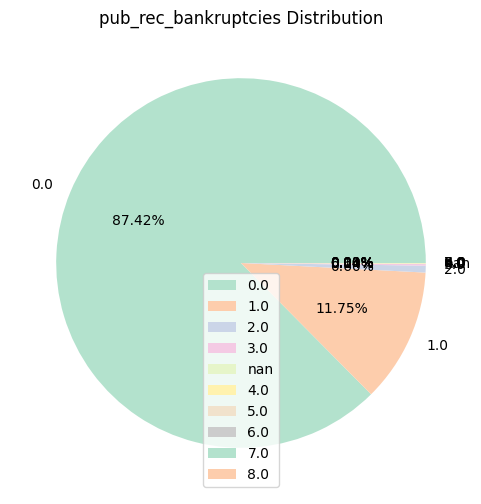

In [50]:
get_value_distribution_as_pie(tot_cur_bal, column='pub_rec_bankruptcies')

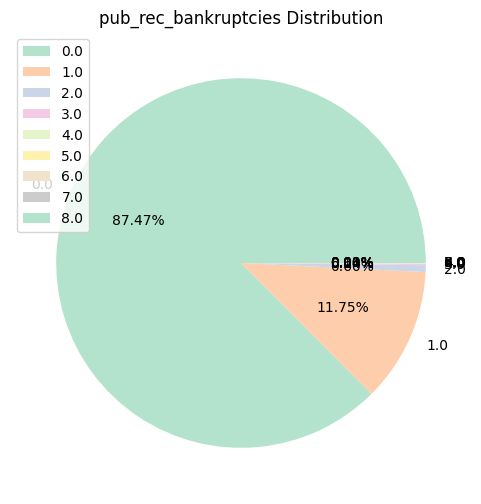

In [51]:
tot_cur_bal['pub_rec_bankruptcies'] = tot_cur_bal['pub_rec_bankruptcies'].fillna(tot_cur_bal['pub_rec_bankruptcies'].mode()[0])
get_value_distribution_as_pie(tot_cur_bal, 'pub_rec_bankruptcies')

### purpose

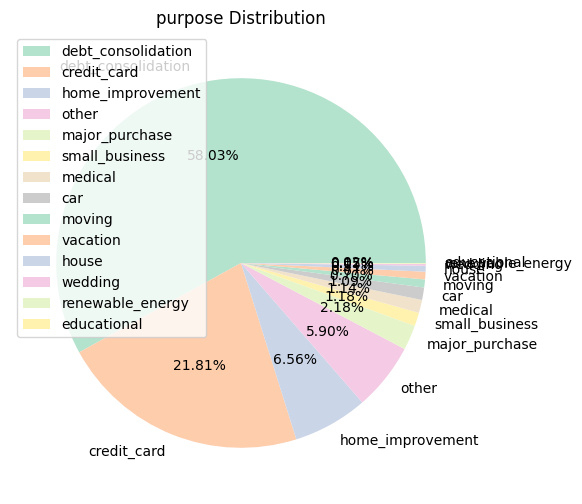

In [52]:
get_value_distribution_as_pie(tot_cur_bal, column='purpose')

### revol_bal

In [53]:
revol_bal = impute_null_values_using_knn_imputer(tot_cur_bal,
                                                column_to_be_imputed='revol_bal',
                                                column_type='float',
                                                columns_to_be_considered=['loan_amnt', 'fico_range_average', 'num_actv_bc_tl', 'mort_acc', 'tot_cur_bal'],
                                                n_neighbors=3)

### revol_util

In [54]:
na_filled = impute_null_values_using_knn_imputer(revol_bal,
                                                  column_to_be_imputed='revol_util',
                                                  column_type='float',
                                                  columns_to_be_considered=['loan_amnt', 'fico_range_average', 'num_actv_bc_tl', 'mort_acc', 'tot_cur_bal', 'revol_bal'],
                                                  n_neighbors=3)

### verification_status

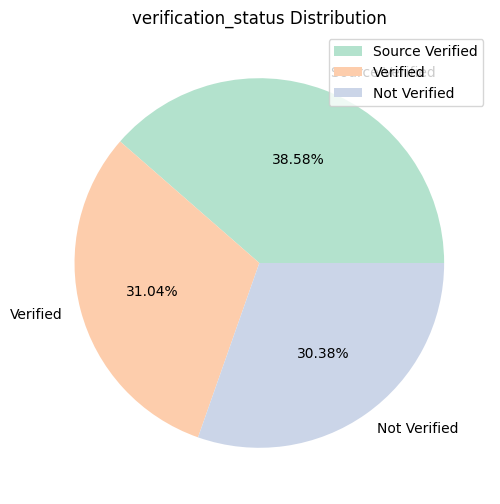

In [55]:
get_value_distribution_as_pie(na_filled, column='verification_status')

### term

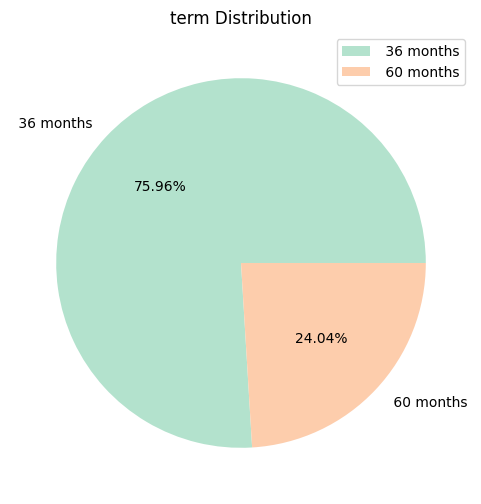

In [56]:
get_value_distribution_as_pie(na_filled, column='term')

In [57]:
na_filled['term'].unique()

array([' 60 months', ' 36 months'], dtype=object)

In [58]:
na_filled['term'] = na_filled['term'].replace({' 60 months': 60, ' 36 months': 36}).astype(int)
na_filled['term'].dtype

dtype('int64')

In [59]:
na_filled.isna().sum()

addr_state                    0
annual_inc                    0
emp_length                    0
grade                         0
home_ownership                0
application_type              0
initial_list_status           0
int_rate                      0
loan_amnt                     0
num_actv_bc_tl                0
mort_acc                      0
tot_cur_bal                   0
open_acc                      0
pub_rec                       0
pub_rec_bankruptcies          0
purpose                       0
revol_bal                     0
revol_util                    0
sub_grade                     0
term                          0
total_acc                     0
verification_status           0
loan_status               20000
earliest_cr_line_year         0
earliest_cr_line_month        0
fico_range_average            0
dtype: int64

## Data without NaN values

In [60]:
na_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   addr_state              100000 non-null  object 
 1   annual_inc              100000 non-null  float64
 2   emp_length              100000 non-null  int64  
 3   grade                   100000 non-null  object 
 4   home_ownership          100000 non-null  object 
 5   application_type        100000 non-null  object 
 6   initial_list_status     100000 non-null  object 
 7   int_rate                100000 non-null  float64
 8   loan_amnt               100000 non-null  float64
 9   num_actv_bc_tl          100000 non-null  int64  
 10  mort_acc                100000 non-null  int64  
 11  tot_cur_bal             100000 non-null  int64  
 12  open_acc                100000 non-null  float64
 13  pub_rec                 100000 non-null  float64
 14  pub_rec_bankruptcies 

## Analysing **grade** and ***sub_grade*** columns

In [61]:
na_filled.groupby('grade').agg({'sub_grade': lambda x: set(x)})

,sub_grade
grade,
A,"{A1, A3, A5, A2, A4}"
B,"{B4, B5, B3, B1, B2}"
C,"{C5, C1, C3, C4, C2}"
D,"{D4, D3, D2, D1, D5}"
E,"{E4, E3, E2, E5, E1}"
F,"{F2, F3, F1, F5, F4}"
G,"{G1, G5, G3, G4, G2}"


The above table shows that the ***grade*** and ***sub_grade*** columns are dependent. So, updating the ***sub_grade*** with only the numeric grade

In [62]:
na_filled['sub_grade'] = na_filled['sub_grade'].str[-1].astype(int)
na_filled['sub_grade'].unique()

array([1, 5, 2, 3, 4])

## Correlation

<ipython-input-63-db8330a930d7>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(na_filled.corr(), annot=True)


<Axes: >

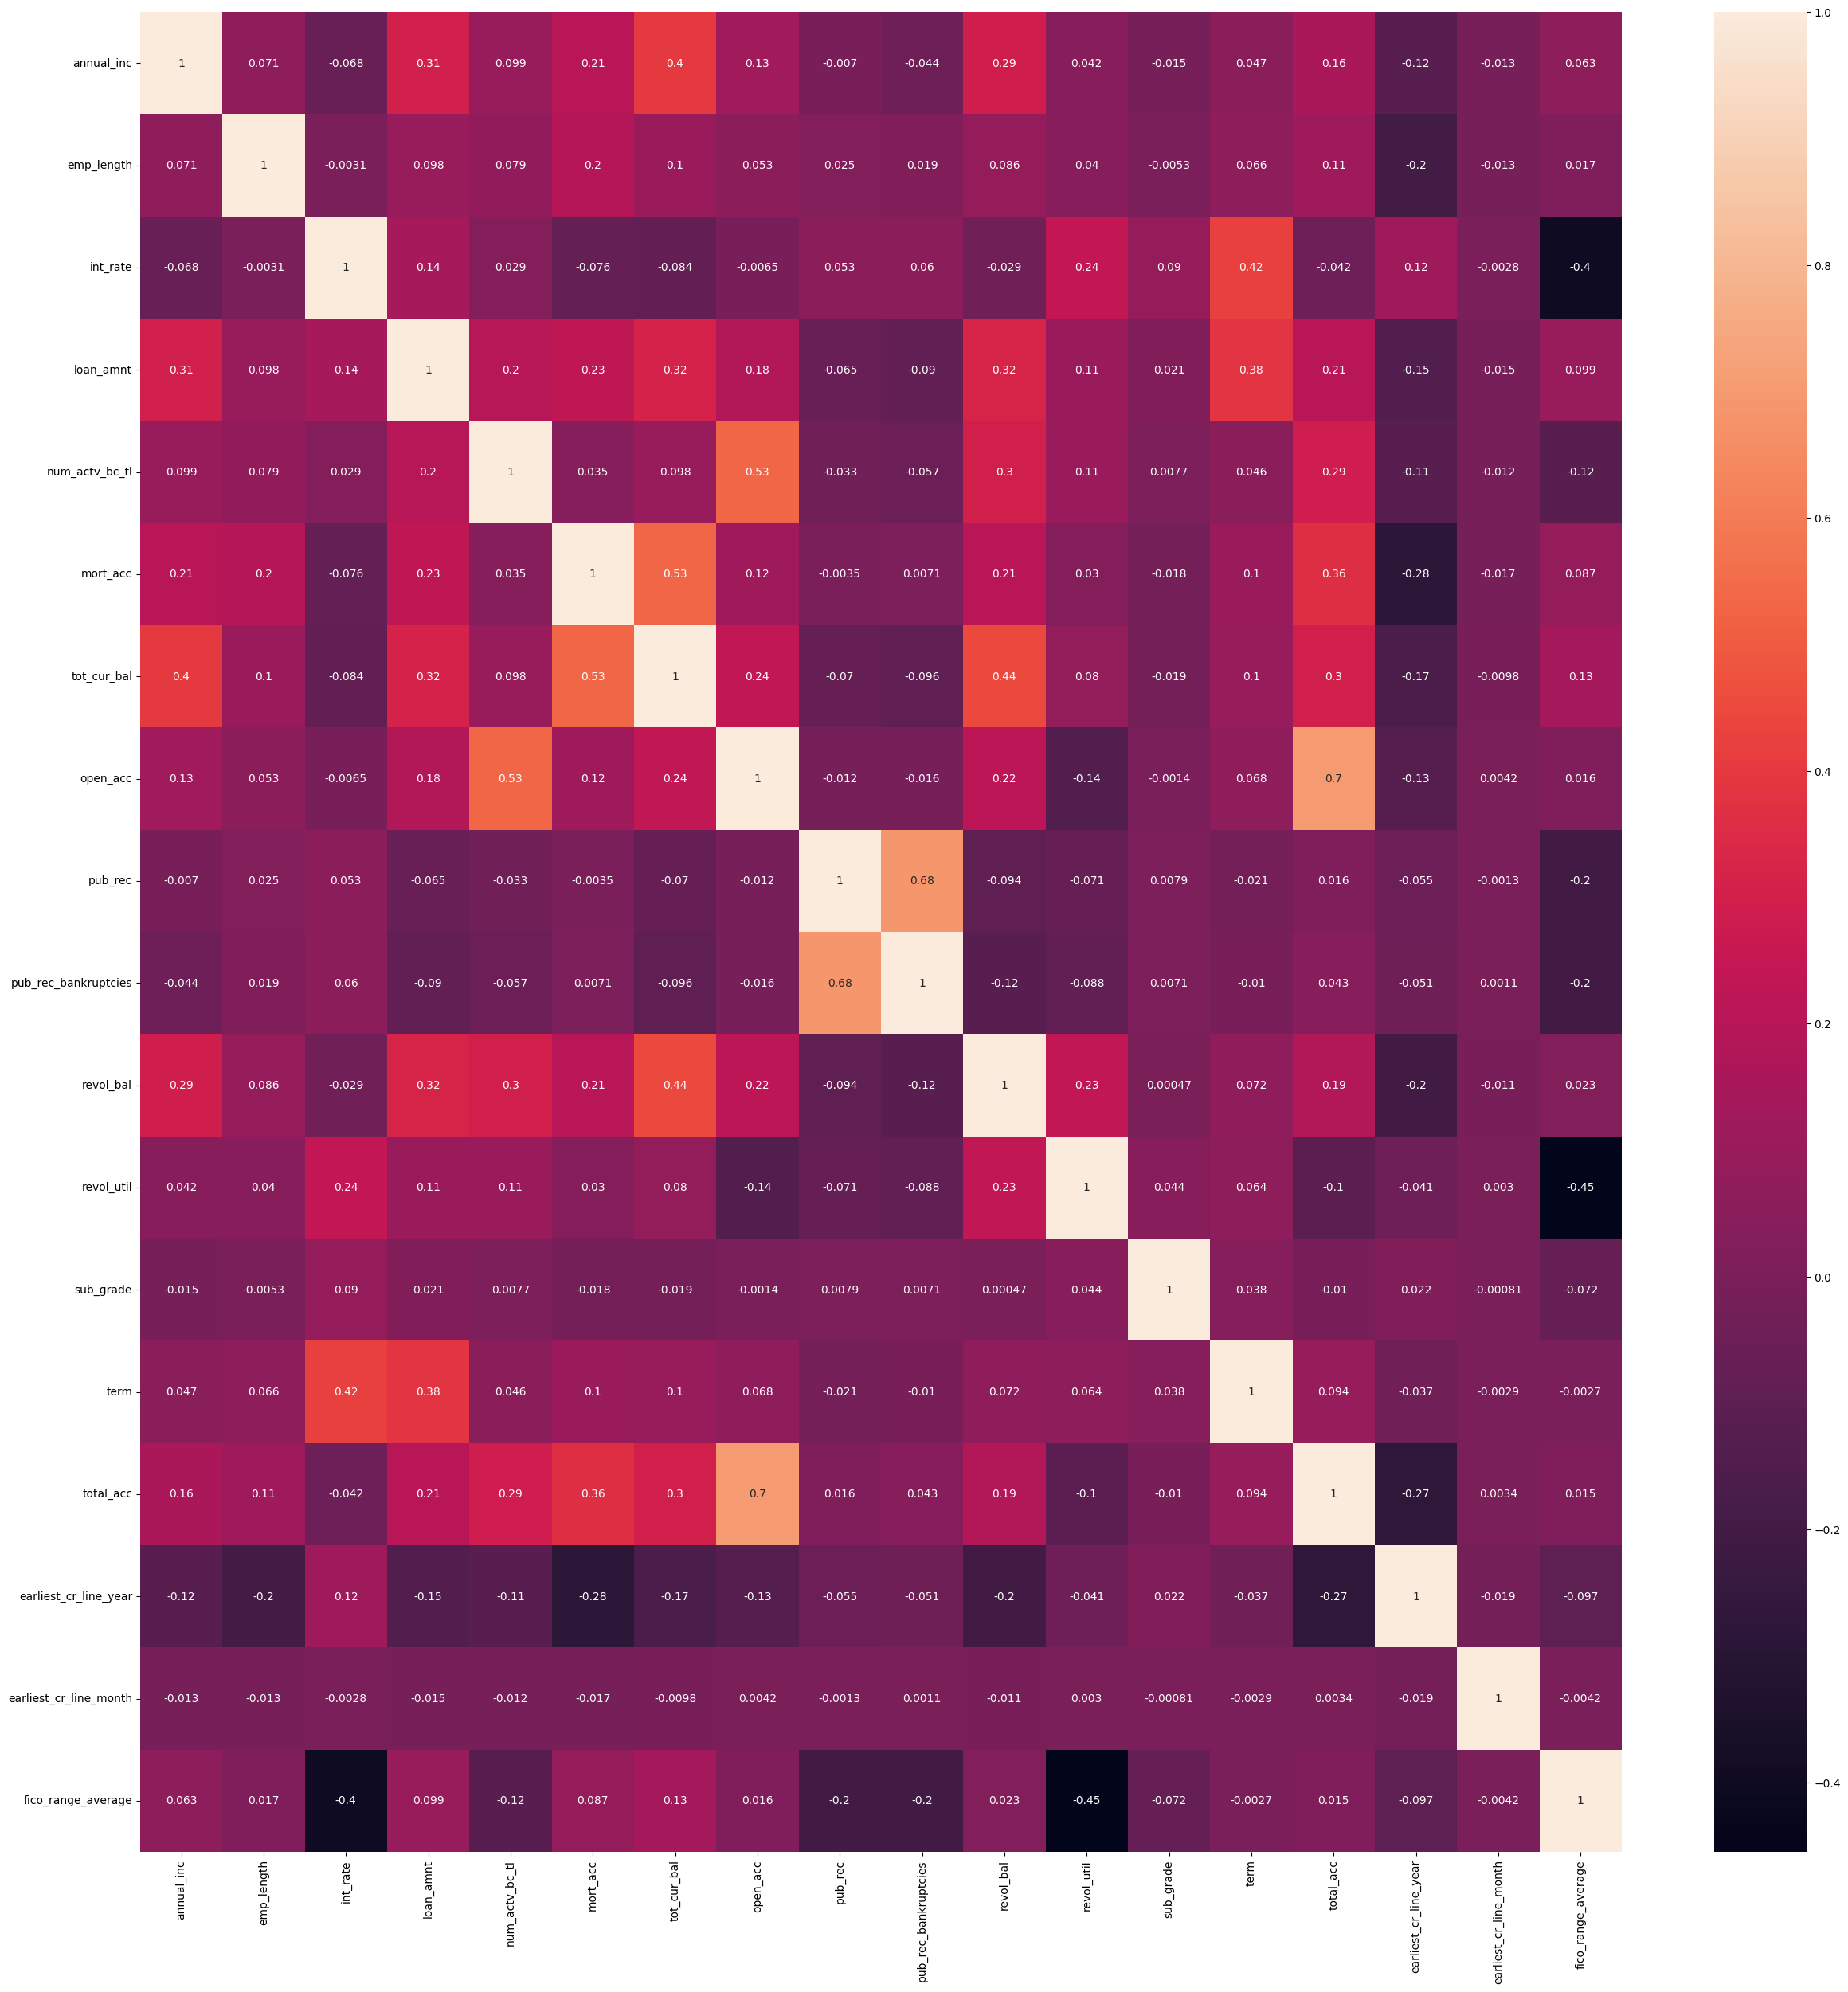

In [63]:
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(na_filled.corr(), annot=True)

## Encoding

Ordinal Encode: grade, initial_list_status  
One-Hot Encode: addr_state, home_ownership, application_type, purpose, verification_status

In [64]:
na_filled['grade'] = na_filled['grade'].replace({'A':1, 'B':2, 'C':3, 'D':4, 'E': 5, 'F':6, 'G': 7}).astype(int)
na_filled['initial_list_status'] = na_filled['initial_list_status'].replace({'w': 0, 'f': 1})
na_filled[['grade', 'initial_list_status']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   grade                100000 non-null  int64
 1   initial_list_status  100000 non-null  int64
dtypes: int64(2)
memory usage: 1.5 MB


In [65]:
one_hot_columns = ['addr_state', 'home_ownership', 'application_type', 'purpose', 'verification_status']
# ohe = OneHotEncoder(drop='first')

In [66]:
# ohe.fit_transform(na_filled[one_hot_columns])

In [67]:
ohe_df = pd.get_dummies(na_filled, columns=one_hot_columns)
ohe_df

,annual_inc,emp_length,grade,initial_list_status,int_rate,loan_amnt,num_actv_bc_tl,mort_acc,tot_cur_bal,open_acc,...,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
0,85000.0,10,5,0,18.99,18075.0,1,1,319479,7.0,...,0,0,0,0,0,0,0,0,1,0
1,40000.0,10,2,0,10.16,8800.0,4,0,19944,5.0,...,0,0,0,0,0,0,0,0,0,1
2,60000.0,10,2,0,11.47,18000.0,4,2,23199,7.0,...,0,0,0,0,0,0,0,0,1,0
3,100742.0,10,2,0,9.16,20000.0,4,1,72651,12.0,...,0,0,0,0,0,0,0,0,1,0
4,80000.0,10,6,1,23.83,35000.0,14,7,64631,23.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,38500.0,4,4,0,17.57,10000.0,1,0,30397,10.0,...,0,0,0,0,0,0,0,1,0,0
99996,80000.0,3,4,1,18.92,18375.0,2,5,494439,9.0,...,0,0,0,0,0,0,0,0,1,0
99997,95000.0,10,2,1,11.22,35000.0,2,4,284915,10.0,...,0,0,0,0,0,0,0,0,1,0
99998,35000.0,10,1,0,7.89,5000.0,1,0,8205,9.0,...,0,0,0,0,0,0,0,1,0,0


In [68]:
ohe_df.to_csv(base_path+'/pre-processed_without_scaling.csv')

Encoding the Target Variable

In [69]:
encoded_train = ohe_df[~ohe_df['loan_status'].isnull()]
encoded_test = ohe_df[ohe_df['loan_status'].isnull()]

In [70]:
encoded_train['loan_status'].value_counts(dropna=False)

Fully Paid     64030
Charged Off    15970
Name: loan_status, dtype: int64

In [232]:
encoded_train['loan_status'] = encoded_train['loan_status'].replace({'Fully Paid':0, 'Charged Off':1}).astype(int)
encoded_train['loan_status'].value_counts(dropna=False)

<ipython-input-232-fd59c5cd4159>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoded_train['loan_status'] = encoded_train['loan_status'].replace({'Fully Paid':0, 'Charged Off':1}).astype(int)


0    64030
1    15970
Name: loan_status, dtype: int64

In [233]:
sum(x for x in encoded_train["purpose_vacation"] if x == 0)

0

In [234]:
encoded_columns = ohe_df.drop(columns='loan_status').columns
sum_of_columns = []
for col in encoded_columns:
  # print(col,':',sum(x for x in ohe_df[col] if x == 0))
  sum_of_columns.append([col, ohe_df[col].sum()])
col_sum = pd.DataFrame(sum_of_columns, columns=['ColumnName', 'ColumnSum'])
col_sum[col_sum['ColumnSum']<len(ohe_df)*0.01]

,ColumnName,ColumnSum
20,addr_state_AK,265.0
22,addr_state_AR,739.0
27,addr_state_DC,252.0
28,addr_state_DE,281.0
31,addr_state_HI,502.0
32,addr_state_IA,1.0
33,addr_state_ID,125.0
36,addr_state_KS,833.0
41,addr_state_ME,147.0
45,addr_state_MS,456.0


In [74]:
len(ohe_df)*0.01

1000.0

In [75]:
columns_with_less_than_001percent_data = col_sum[col_sum['ColumnSum']<len(ohe_df)*0.01]['ColumnName'].tolist()
print(columns_with_less_than_001percent_data)

['addr_state_AK', 'addr_state_AR', 'addr_state_DC', 'addr_state_DE', 'addr_state_HI', 'addr_state_IA', 'addr_state_ID', 'addr_state_KS', 'addr_state_ME', 'addr_state_MS', 'addr_state_MT', 'addr_state_ND', 'addr_state_NE', 'addr_state_NH', 'addr_state_NM', 'addr_state_OK', 'addr_state_RI', 'addr_state_SD', 'addr_state_UT', 'addr_state_VT', 'addr_state_WV', 'addr_state_WY', 'home_ownership_OTHER', 'purpose_educational', 'purpose_house', 'purpose_moving', 'purpose_renewable_energy', 'purpose_vacation', 'purpose_wedding']


These columns have less than 1% of data. Creating another dataframe with these columns dropped.

In [76]:
ohe_df_with_dropped_cols = ohe_df.drop(columns=columns_with_less_than_001percent_data)
ohe_df_with_dropped_cols.head(3)

,annual_inc,emp_length,grade,initial_list_status,int_rate,loan_amnt,num_actv_bc_tl,mort_acc,tot_cur_bal,open_acc,...,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_major_purchase,purpose_medical,purpose_other,purpose_small_business,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
0,85000.0,10,5,0,18.99,18075.0,1,1,319479,7.0,...,0,1,0,0,0,0,0,0,1,0
1,40000.0,10,2,0,10.16,8800.0,4,0,19944,5.0,...,0,1,0,0,0,0,0,0,0,1
2,60000.0,10,2,0,11.47,18000.0,4,2,23199,7.0,...,0,1,0,0,0,0,0,0,1,0


In [235]:
encoded_train_with_dropped_cols = ohe_df_with_dropped_cols[~ohe_df_with_dropped_cols['loan_status'].isnull()]
encoded_test_with_dropped_cols = ohe_df_with_dropped_cols[ohe_df_with_dropped_cols['loan_status'].isnull()]
encoded_train_with_dropped_cols['loan_status'] = encoded_train_with_dropped_cols['loan_status'].replace({'Fully Paid':0, 'Charged Off':1}).astype(int)
encoded_train_with_dropped_cols['loan_status'].value_counts(dropna=False)

<ipython-input-235-c2800c3f03ca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoded_train_with_dropped_cols['loan_status'] = encoded_train_with_dropped_cols['loan_status'].replace({'Fully Paid':0, 'Charged Off':1}).astype(int)


0    64030
1    15970
Name: loan_status, dtype: int64

In [78]:
len(encoded_train), len(encoded_test)

(80000, 20000)

In [236]:
# HACKATHON TEST DATA
hack_test = encoded_test.drop(columns='loan_status').copy()
hack_test.head(3)

,annual_inc,emp_length,grade,initial_list_status,int_rate,loan_amnt,num_actv_bc_tl,mort_acc,tot_cur_bal,open_acc,...,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
80000,50000.0,1,3,1,13.99,5000.0,1,0,33395,9.0,...,0,0,0,0,0,0,0,0,1,0
80001,92000.0,10,2,1,10.99,30000.0,2,2,229832,11.0,...,0,0,0,0,0,0,0,0,1,0
80002,89000.0,10,2,0,10.15,16000.0,5,2,181616,15.0,...,0,0,0,0,0,0,0,1,0,0


In [111]:
hack_test_with_dropped_cols = encoded_test_with_dropped_cols.drop(columns='loan_status').copy()
hack_test_with_dropped_cols.head(3)

,annual_inc,emp_length,grade,initial_list_status,int_rate,loan_amnt,num_actv_bc_tl,mort_acc,tot_cur_bal,open_acc,...,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_major_purchase,purpose_medical,purpose_other,purpose_small_business,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
80000,50000.0,1,3,1,13.99,5000.0,1,0,33395,9.0,...,0,1,0,0,0,0,0,0,1,0
80001,92000.0,10,2,1,10.99,30000.0,2,2,229832,11.0,...,0,1,0,0,0,0,0,0,1,0
80002,89000.0,10,2,0,10.15,16000.0,5,2,181616,15.0,...,1,0,0,0,0,0,0,1,0,0


In [80]:
scaler = StandardScaler()
scaler.fit(hack_test)
hack_test_scaled = scaler.transform(hack_test)
hack_test_scaled

array([[-0.30926719, -1.42740276,  0.19357122, ..., -0.66339443,
         1.26095305, -0.66761775],
       [ 0.18093561,  1.13835581, -0.58148871, ..., -0.66339443,
         1.26095305, -0.66761775],
       [ 0.14592113,  1.13835581, -0.58148871, ...,  1.50739886,
        -0.79305094, -0.66761775],
       ...,
       [ 0.2159501 ,  1.13835581, -0.58148871, ..., -0.66339443,
         1.26095305, -0.66761775],
       [-0.48433962,  1.13835581, -1.35654863, ...,  1.50739886,
        -0.79305094, -0.66761775],
       [-0.53452705, -1.42740276,  1.74369106, ..., -0.66339443,
        -0.79305094,  1.49786311]])

In [81]:
hack_results = raw_results['loan_status'].replace({'Fully Paid':0, 'Charged Off':1}).astype(int)
hack_results

0        0
1        0
2        0
3        1
4        0
        ..
19995    0
19996    0
19997    0
19998    0
19999    0
Name: loan_status, Length: 20000, dtype: int64

# Modeling

## Modeling Functions

In [120]:
# To track Model Information and its accuracies
# model_name, desc, accuracy_score_train, accuracy_score_test, accuracy_score_hack_test, f1score_train, f1score_test, f1score_hack_test
model_accuracy_info = []

In [248]:
def scale_data(data, scaler=StandardScaler()):
  scaler.fit(data)
  data_scaled = scaler.transform(data)
  return data_scaled

def sampling_data(X_data, y_data, sampling_type='oversampling'):
  if sampling_type=='oversampling':
    sampler = RandomOverSampler()
  else:
    sampler = RandomUnderSampler()
  X_sampled, y_sampled = sampler.fit_resample(X_data, y_data)
  return X_sampled, y_sampled

def split_data(df, target_col, train_size=0.75, random_state=0):
    print('Train Test Split...')
    print('Target Column :', target_col)
    print(f"Train-Test Size : {train_size},{round(1-train_size, 1)}")
    X = df.drop(columns=str(target_col))
    Y = df[target_col]
    # display(X)
    return train_test_split(X, Y, train_size=train_size, stratify=Y, random_state=random_state)

def get_data_for_modeling(data_and_hack_test, target_col, important_features, model,scaling, sampling, sampling_type):
  data, hack_test, hack_results = data_and_hack_test
  print(target_col in hack_test.columns.tolist())
  if len(important_features)==0:
    important_features = data.columns.tolist()
    important_features_for_test_data = data.drop(columns=target_col).columns.tolist()
  else:
    list(set(important_features)).append(target_col)
  data = data[list(set(important_features))]
  hack_test = hack_test[list(set(important_features_for_test_data))]
  X_train, X_test, y_train, y_test = split_data(data,target_col,train_size=0.7 )
  print("Scaling : ", scaling)
  if scaling==True:
    X_train, X_test, hack_test = scale_data(X_train), scale_data(X_test), scale_data(hack_test)
  else:
    X_train, X_test, hack_test = X_train, X_test, hack_test
  print("Sampling : ", sampling)
  if sampling==True:
    print("Type : ", sampling_type)
    if sampling_type=='oversampling':
      X_train, y_train = sampling_data(X_train, y_train, sampling_type='oversampling')
    else:
      X_train, y_train = sampling_data(X_train, y_train, sampling_type='undersampling')
  else:
    sampling_type = None
  return X_train, X_test, y_train, y_test, hack_test

def applying_model(data_and_hack_test, target_col, base_model_name, model=None, important_features=[], scaling=False, sampling=True, sampling_type='oversampling'):
  """ The model is passed as parameter, for GridSearchCV """
  X_train, X_test, y_train, y_test, hack_test = get_data_for_modeling(data_and_hack_test, target_col, important_features, model,scaling, sampling, sampling_type)

  if important_features==[]:
    feature_selection = False
    print('Training the model with the best parameter...')
    model.fit(X_train, y_train)
    print('Best Estimator : ')
    print(model.best_estimator_)
  else:
    feature_selection = True

  print('Predicting results...')
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)
  hack_test_pred = model.predict(hack_test)
  model_accuracy_info.append([base_model_name, f'Scaling-{scaling}, Sampling-{sampling}({sampling_type}), FeatureSelection-{feature_selection}', round(accuracy_score(y_train, train_pred), 4), round(accuracy_score(y_test, test_pred),4), round(accuracy_score(hack_results, hack_test_pred),4), round(f1_score(y_train, train_pred),4), round(f1_score(y_test, test_pred),4), round(f1_score(hack_results, hack_test_pred),4)  ])
  print(model_accuracy_info[-1])

  return model

### Logistic Regression

In [122]:
log_model = LogisticRegression(random_state=2)

In [123]:
params = {
    'C': [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 1]
}

In [124]:
log_model_cv = GridSearchCV(estimator=log_model, param_grid=params, verbose=16, scoring='f1', cv=3)

In [125]:
data_and_hack_test = [encoded_train, hack_test, hack_results]

In [126]:
log_model_cv_best_fit_model = applying_model(data_and_hack_test, target_col='loan_status', base_model_name='Logistic Regression', model=log_model_cv, scaling=True, sampling=False, sampling_type=None)

Train Test Split...
Target Column : loan_status
Train-Test Size : 0.7,0.3
Scaling :  True
Sampling :  False
Training the model with the best parameter...
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV 1/3; 1/7] START C=0.01......................................................
[CV 1/3; 1/7] END .......................C=0.01;, score=0.130 total time=   0.3s
[CV 2/3; 1/7] START C=0.01......................................................
[CV 2/3; 1/7] END .......................C=0.01;, score=0.124 total time=   0.3s
[CV 3/3; 1/7] START C=0.01......................................................
[CV 3/3; 1/7] END .......................C=0.01;, score=0.128 total time=   0.3s
[CV 1/3; 2/7] START C=0.05......................................................
[CV 1/3; 2/7] END .......................C=0.05;, score=0.135 total time=   0.3s
[CV 2/3; 2/7] START C=0.05......................................................
[CV 2/3; 2/7] END .......................C=0.05;, score=0

In [127]:
log_model_cv_best_fit_model = applying_model(data_and_hack_test, target_col='loan_status', base_model_name='Logistic Regression', model=log_model_cv, scaling=True, sampling=True, sampling_type='oversampling')

Train Test Split...
Target Column : loan_status
Train-Test Size : 0.7,0.3
Scaling :  True
Sampling :  True
Type :  oversampling
Training the model with the best parameter...
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV 1/3; 1/7] START C=0.01......................................................
[CV 1/3; 1/7] END .......................C=0.01;, score=0.648 total time=   0.8s
[CV 2/3; 1/7] START C=0.01......................................................
[CV 2/3; 1/7] END .......................C=0.01;, score=0.650 total time=   0.8s
[CV 3/3; 1/7] START C=0.01......................................................
[CV 3/3; 1/7] END .......................C=0.01;, score=0.643 total time=   0.8s
[CV 1/3; 2/7] START C=0.05......................................................
[CV 1/3; 2/7] END .......................C=0.05;, score=0.648 total time=   0.8s
[CV 2/3; 2/7] START C=0.05......................................................
[CV 2/3; 2/7] END ...................

In [128]:
log_model_cv_best_fit_model = applying_model(data_and_hack_test, target_col='loan_status', base_model_name='Logistic Regression', model=log_model_cv, scaling=True, sampling=True, sampling_type='undersampling')

Train Test Split...
Target Column : loan_status
Train-Test Size : 0.7,0.3
Scaling :  True
Sampling :  True
Type :  undersampling
Training the model with the best parameter...
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV 1/3; 1/7] START C=0.01......................................................
[CV 1/3; 1/7] END .......................C=0.01;, score=0.650 total time=   0.4s
[CV 2/3; 1/7] START C=0.01......................................................
[CV 2/3; 1/7] END .......................C=0.01;, score=0.652 total time=   0.3s
[CV 3/3; 1/7] START C=0.01......................................................
[CV 3/3; 1/7] END .......................C=0.01;, score=0.634 total time=   0.4s
[CV 1/3; 2/7] START C=0.05......................................................
[CV 1/3; 2/7] END .......................C=0.05;, score=0.651 total time=   0.3s
[CV 2/3; 2/7] START C=0.05......................................................
[CV 2/3; 2/7] END ..................

In [129]:
log_model_cv_best_fit_model = applying_model([encoded_train_with_dropped_cols, hack_test_with_dropped_cols, hack_results], target_col='loan_status', base_model_name='Logistic Regression', model=log_model_cv, scaling=True, sampling=True, sampling_type='oversampling')

Train Test Split...
Target Column : loan_status
Train-Test Size : 0.7,0.3
Scaling :  True
Sampling :  True
Type :  oversampling
Training the model with the best parameter...
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV 1/3; 1/7] START C=0.01......................................................
[CV 1/3; 1/7] END .......................C=0.01;, score=0.648 total time=   0.8s
[CV 2/3; 1/7] START C=0.01......................................................
[CV 2/3; 1/7] END .......................C=0.01;, score=0.652 total time=   0.8s
[CV 3/3; 1/7] START C=0.01......................................................
[CV 3/3; 1/7] END .......................C=0.01;, score=0.651 total time=   0.8s
[CV 1/3; 2/7] START C=0.05......................................................
[CV 1/3; 2/7] END .......................C=0.05;, score=0.648 total time=   0.9s
[CV 2/3; 2/7] START C=0.05......................................................
[CV 2/3; 2/7] END ...................

In [130]:
log_model_cv_best_fit_model = applying_model([encoded_train_with_dropped_cols, hack_test_with_dropped_cols, hack_results], target_col='loan_status', base_model_name='Logistic Regression', model=log_model_cv, scaling=True, sampling=True, sampling_type='undersampling')

Train Test Split...
Target Column : loan_status
Train-Test Size : 0.7,0.3
Scaling :  True
Sampling :  True
Type :  undersampling
Training the model with the best parameter...
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV 1/3; 1/7] START C=0.01......................................................
[CV 1/3; 1/7] END .......................C=0.01;, score=0.655 total time=   0.1s
[CV 2/3; 1/7] START C=0.01......................................................
[CV 2/3; 1/7] END .......................C=0.01;, score=0.647 total time=   0.1s
[CV 3/3; 1/7] START C=0.01......................................................
[CV 3/3; 1/7] END .......................C=0.01;, score=0.640 total time=   0.1s
[CV 1/3; 2/7] START C=0.05......................................................
[CV 1/3; 2/7] END .......................C=0.05;, score=0.656 total time=   0.1s
[CV 2/3; 2/7] START C=0.05......................................................
[CV 2/3; 2/7] END ..................

### Decision Tree Classifier

In [131]:
dt_model = DecisionTreeClassifier(random_state=16)

In [132]:
dt_params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': np.arange(3, 15),
    'max_features': [None, 'auto', 'log2']
}

In [135]:
dt_model_cv = GridSearchCV(estimator=dt_model, param_grid=dt_params, verbose=16, scoring='f1', cv=3)

In [136]:
applying_model([encoded_train, hack_test, hack_results], target_col='loan_status', base_model_name='Decision Tree Classifier', model=dt_model_cv, scaling=False, sampling=True, sampling_type='undersampling').best_estimator_

Train Test Split...
Target Column : loan_status
Train-Test Size : 0.7,0.3
Scaling :  False
Sampling :  True
Type :  undersampling
Training the model with the best parameter...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV 1/3; 1/108] START criterion=gini, max_depth=3, max_features=None............
[CV 1/3; 1/108] END criterion=gini, max_depth=3, max_features=None;, score=0.632 total time=   0.2s
[CV 2/3; 1/108] START criterion=gini, max_depth=3, max_features=None............
[CV 2/3; 1/108] END criterion=gini, max_depth=3, max_features=None;, score=0.651 total time=   0.2s
[CV 3/3; 1/108] START criterion=gini, max_depth=3, max_features=None............
[CV 3/3; 1/108] END criterion=gini, max_depth=3, max_features=None;, score=0.618 total time=   0.2s
[CV 1/3; 2/108] START criterion=gini, max_depth=3, max_features=auto............
[CV 1/3; 2/108] END criterion=gini, max_depth=3, max_features=auto;, score=0.639 total time=   0.1s
[CV 2/3; 2/108] START criterion=gini,

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 2/108] END criterion=gini, max_depth=3, max_features=auto;, score=0.619 total time=   0.1s
[CV 1/3; 3/108] START criterion=gini, max_depth=3, max_features=log2............
[CV 1/3; 3/108] END criterion=gini, max_depth=3, max_features=log2;, score=0.483 total time=   0.1s
[CV 2/3; 3/108] START criterion=gini, max_depth=3, max_features=log2............
[CV 2/3; 3/108] END criterion=gini, max_depth=3, max_features=log2;, score=0.539 total time=   0.1s
[CV 3/3; 3/108] START criterion=gini, max_depth=3, max_features=log2............
[CV 3/3; 3/108] END criterion=gini, max_depth=3, max_features=log2;, score=0.455 total time=   0.1s
[CV 1/3; 4/108] START criterion=gini, max_depth=4, max_features=None............
[CV 1/3; 4/108] END criterion=gini, max_depth=4, max_features=None;, score=0.664 total time=   0.2s
[CV 2/3; 4/108] START criterion=gini, max_depth=4, max_features=None............
[CV 2/3; 4/108] END criterion=gini, max_depth=4, max_features=None;, score=0.668 total time=   

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 6/108] END criterion=gini, max_depth=4, max_features=log2;, score=0.548 total time=   0.1s
[CV 2/3; 6/108] START criterion=gini, max_depth=4, max_features=log2............
[CV 2/3; 6/108] END criterion=gini, max_depth=4, max_features=log2;, score=0.640 total time=   0.0s
[CV 3/3; 6/108] START criterion=gini, max_depth=4, max_features=log2............
[CV 3/3; 6/108] END criterion=gini, max_depth=4, max_features=log2;, score=0.547 total time=   0.0s
[CV 1/3; 7/108] START criterion=gini, max_depth=5, max_features=None............
[CV 1/3; 7/108] END criterion=gini, max_depth=5, max_features=None;, score=0.665 total time=   0.2s
[CV 2/3; 7/108] START criterion=gini, max_depth=5, max_features=None............
[CV 2/3; 7/108] END criterion=gini, max_depth=5, max_features=None;, score=0.655 total time=   0.2s
[CV 3/3; 7/108] START criterion=gini, max_depth=5, max_features=None............
[CV 3/3; 7/108] END criterion=gini, max_depth=5, max_features=None;, score=0.634 total time=   

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(



[CV 1/3; 9/108] END criterion=gini, max_depth=5, max_features=log2;, score=0.659 total time=   0.1s
[CV 2/3; 9/108] START criterion=gini, max_depth=5, max_features=log2............
[CV 2/3; 9/108] END criterion=gini, max_depth=5, max_features=log2;, score=0.564 total time=   0.1s
[CV 3/3; 9/108] START criterion=gini, max_depth=5, max_features=log2............
[CV 3/3; 9/108] END criterion=gini, max_depth=5, max_features=log2;, score=0.521 total time=   0.1s
[CV 1/3; 10/108] START criterion=gini, max_depth=6, max_features=None...........
[CV 1/3; 10/108] END criterion=gini, max_depth=6, max_features=None;, score=0.644 total time=   0.2s
[CV 2/3; 10/108] START criterion=gini, max_depth=6, max_features=None...........
[CV 2/3; 10/108] END criterion=gini, max_depth=6, max_features=None;, score=0.651 total time=   0.3s
[CV 3/3; 10/108] START criterion=gini, max_depth=6, max_features=None...........
[CV 3/3; 10/108] END criterion=gini, max_depth=6, max_features=None;, score=0.640 total time

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 11/108] END criterion=gini, max_depth=6, max_features=auto;, score=0.653 total time=   0.1s
[CV 1/3; 12/108] START criterion=gini, max_depth=6, max_features=log2...........
[CV 1/3; 12/108] END criterion=gini, max_depth=6, max_features=log2;, score=0.578 total time=   0.1s
[CV 2/3; 12/108] START criterion=gini, max_depth=6, max_features=log2...........
[CV 2/3; 12/108] END criterion=gini, max_depth=6, max_features=log2;, score=0.585 total time=   0.1s
[CV 3/3; 12/108] START criterion=gini, max_depth=6, max_features=log2...........
[CV 3/3; 12/108] END criterion=gini, max_depth=6, max_features=log2;, score=0.629 total time=   0.1s
[CV 1/3; 13/108] START criterion=gini, max_depth=7, max_features=None...........
[CV 1/3; 13/108] END criterion=gini, max_depth=7, max_features=None;, score=0.648 total time=   0.3s
[CV 2/3; 13/108] START criterion=gini, max_depth=7, max_features=None...........
[CV 2/3; 13/108] END criterion=gini, max_depth=7, max_features=None;, score=0.641 total ti

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 15/108] END criterion=gini, max_depth=7, max_features=log2;, score=0.574 total time=   0.0s
[CV 3/3; 15/108] START criterion=gini, max_depth=7, max_features=log2...........
[CV 3/3; 15/108] END criterion=gini, max_depth=7, max_features=log2;, score=0.639 total time=   0.0s
[CV 1/3; 16/108] START criterion=gini, max_depth=8, max_features=None...........
[CV 1/3; 16/108] END criterion=gini, max_depth=8, max_features=None;, score=0.647 total time=   0.2s
[CV 2/3; 16/108] START criterion=gini, max_depth=8, max_features=None...........
[CV 2/3; 16/108] END criterion=gini, max_depth=8, max_features=None;, score=0.623 total time=   0.2s
[CV 3/3; 16/108] START criterion=gini, max_depth=8, max_features=None...........
[CV 3/3; 16/108] END criterion=gini, max_depth=8, max_features=None;, score=0.626 total time=   0.2s
[CV 1/3; 17/108] START criterion=gini, max_depth=8, max_features=auto...........
[CV 1/3; 17/108] END criterion=gini, max_depth=8, max_features=auto;, score=0.641 total ti

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 18/108] END criterion=gini, max_depth=8, max_features=log2;, score=0.585 total time=   0.0s
[CV 3/3; 18/108] START criterion=gini, max_depth=8, max_features=log2...........
[CV 3/3; 18/108] END criterion=gini, max_depth=8, max_features=log2;, score=0.601 total time=   0.0s
[CV 1/3; 19/108] START criterion=gini, max_depth=9, max_features=None...........
[CV 1/3; 19/108] END criterion=gini, max_depth=9, max_features=None;, score=0.641 total time=   0.2s
[CV 2/3; 19/108] START criterion=gini, max_depth=9, max_features=None...........
[CV 2/3; 19/108] END criterion=gini, max_depth=9, max_features=None;, score=0.637 total time=   0.2s
[CV 3/3; 19/108] START criterion=gini, max_depth=9, max_features=None...........
[CV 3/3; 19/108] END criterion=gini, max_depth=9, max_features=None;, score=0.625 total time=   0.2s
[CV 1/3; 20/108] START criterion=gini, max_depth=9, max_features=auto...........
[CV 1/3; 20/108] END criterion=gini, max_depth=9, max_features=auto;, score=0.640 total ti

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 21/108] END criterion=gini, max_depth=9, max_features=log2;, score=0.649 total time=   0.0s
[CV 3/3; 21/108] START criterion=gini, max_depth=9, max_features=log2...........
[CV 3/3; 21/108] END criterion=gini, max_depth=9, max_features=log2;, score=0.637 total time=   0.0s
[CV 1/3; 22/108] START criterion=gini, max_depth=10, max_features=None..........
[CV 1/3; 22/108] END criterion=gini, max_depth=10, max_features=None;, score=0.641 total time=   0.2s
[CV 2/3; 22/108] START criterion=gini, max_depth=10, max_features=None..........
[CV 2/3; 22/108] END criterion=gini, max_depth=10, max_features=None;, score=0.634 total time=   0.2s
[CV 3/3; 22/108] START criterion=gini, max_depth=10, max_features=None..........
[CV 3/3; 22/108] END criterion=gini, max_depth=10, max_features=None;, score=0.619 total time=   0.2s
[CV 1/3; 23/108] START criterion=gini, max_depth=10, max_features=auto..........
[CV 1/3; 23/108] END criterion=gini, max_depth=10, max_features=auto;, score=0.580 tota

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 24/108] END criterion=gini, max_depth=10, max_features=log2;, score=0.634 total time=   0.0s
[CV 2/3; 24/108] START criterion=gini, max_depth=10, max_features=log2..........
[CV 2/3; 24/108] END criterion=gini, max_depth=10, max_features=log2;, score=0.651 total time=   0.0s
[CV 3/3; 24/108] START criterion=gini, max_depth=10, max_features=log2..........
[CV 3/3; 24/108] END criterion=gini, max_depth=10, max_features=log2;, score=0.604 total time=   0.0s
[CV 1/3; 25/108] START criterion=gini, max_depth=11, max_features=None..........
[CV 1/3; 25/108] END criterion=gini, max_depth=11, max_features=None;, score=0.625 total time=   0.2s
[CV 2/3; 25/108] START criterion=gini, max_depth=11, max_features=None..........
[CV 2/3; 25/108] END criterion=gini, max_depth=11, max_features=None;, score=0.611 total time=   0.3s
[CV 3/3; 25/108] START criterion=gini, max_depth=11, max_features=None..........
[CV 3/3; 25/108] END criterion=gini, max_depth=11, max_features=None;, score=0.612 to

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 27/108] END criterion=gini, max_depth=11, max_features=log2;, score=0.629 total time=   0.0s
[CV 2/3; 27/108] START criterion=gini, max_depth=11, max_features=log2..........
[CV 2/3; 27/108] END criterion=gini, max_depth=11, max_features=log2;, score=0.622 total time=   0.0s
[CV 3/3; 27/108] START criterion=gini, max_depth=11, max_features=log2..........
[CV 3/3; 27/108] END criterion=gini, max_depth=11, max_features=log2;, score=0.640 total time=   0.0s
[CV 1/3; 28/108] START criterion=gini, max_depth=12, max_features=None..........
[CV 1/3; 28/108] END criterion=gini, max_depth=12, max_features=None;, score=0.624 total time=   0.3s
[CV 2/3; 28/108] START criterion=gini, max_depth=12, max_features=None..........
[CV 2/3; 28/108] END criterion=gini, max_depth=12, max_features=None;, score=0.599 total time=   0.3s
[CV 3/3; 28/108] START criterion=gini, max_depth=12, max_features=None..........
[CV 3/3; 28/108] END criterion=gini, max_depth=12, max_features=None;, score=0.598 to

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 29/108] END criterion=gini, max_depth=12, max_features=auto;, score=0.582 total time=   0.1s
[CV 1/3; 30/108] START criterion=gini, max_depth=12, max_features=log2..........
[CV 1/3; 30/108] END criterion=gini, max_depth=12, max_features=log2;, score=0.632 total time=   0.1s
[CV 2/3; 30/108] START criterion=gini, max_depth=12, max_features=log2..........
[CV 2/3; 30/108] END criterion=gini, max_depth=12, max_features=log2;, score=0.624 total time=   0.1s
[CV 3/3; 30/108] START criterion=gini, max_depth=12, max_features=log2..........
[CV 3/3; 30/108] END criterion=gini, max_depth=12, max_features=log2;, score=0.605 total time=   0.1s
[CV 1/3; 31/108] START criterion=gini, max_depth=13, max_features=None..........
[CV 1/3; 31/108] END criterion=gini, max_depth=13, max_features=None;, score=0.615 total time=   0.4s
[CV 2/3; 31/108] START criterion=gini, max_depth=13, max_features=None..........
[CV 2/3; 31/108] END criterion=gini, max_depth=13, max_features=None;, score=0.604 to

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 32/108] END criterion=gini, max_depth=13, max_features=auto;, score=0.615 total time=   0.1s
[CV 1/3; 33/108] START criterion=gini, max_depth=13, max_features=log2..........
[CV 1/3; 33/108] END criterion=gini, max_depth=13, max_features=log2;, score=0.630 total time=   0.1s
[CV 2/3; 33/108] START criterion=gini, max_depth=13, max_features=log2..........
[CV 2/3; 33/108] END criterion=gini, max_depth=13, max_features=log2;, score=0.624 total time=   0.1s
[CV 3/3; 33/108] START criterion=gini, max_depth=13, max_features=log2..........
[CV 3/3; 33/108] END criterion=gini, max_depth=13, max_features=log2;, score=0.602 total time=   0.1s
[CV 1/3; 34/108] START criterion=gini, max_depth=14, max_features=None..........
[CV 1/3; 34/108] END criterion=gini, max_depth=14, max_features=None;, score=0.611 total time=   0.4s
[CV 2/3; 34/108] START criterion=gini, max_depth=14, max_features=None..........
[CV 2/3; 34/108] END criterion=gini, max_depth=14, max_features=None;, score=0.604 to

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 35/108] END criterion=gini, max_depth=14, max_features=auto;, score=0.591 total time=   0.1s
[CV 1/3; 36/108] START criterion=gini, max_depth=14, max_features=log2..........
[CV 1/3; 36/108] END criterion=gini, max_depth=14, max_features=log2;, score=0.620 total time=   0.1s
[CV 2/3; 36/108] START criterion=gini, max_depth=14, max_features=log2..........
[CV 2/3; 36/108] END criterion=gini, max_depth=14, max_features=log2;, score=0.611 total time=   0.1s
[CV 3/3; 36/108] START criterion=gini, max_depth=14, max_features=log2..........
[CV 3/3; 36/108] END criterion=gini, max_depth=14, max_features=log2;, score=0.618 total time=   0.1s
[CV 1/3; 37/108] START criterion=entropy, max_depth=3, max_features=None........
[CV 1/3; 37/108] END criterion=entropy, max_depth=3, max_features=None;, score=0.632 total time=   0.1s
[CV 2/3; 37/108] START criterion=entropy, max_depth=3, max_features=None........
[CV 2/3; 37/108] END criterion=entropy, max_depth=3, max_features=None;, score=0.65

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 38/108] END criterion=entropy, max_depth=3, max_features=auto;, score=0.640 total time=   0.1s
[CV 2/3; 38/108] START criterion=entropy, max_depth=3, max_features=auto........
[CV 2/3; 38/108] END criterion=entropy, max_depth=3, max_features=auto;, score=0.650 total time=   0.1s
[CV 3/3; 38/108] START criterion=entropy, max_depth=3, max_features=auto........
[CV 3/3; 38/108] END criterion=entropy, max_depth=3, max_features=auto;, score=0.619 total time=   0.1s
[CV 1/3; 39/108] START criterion=entropy, max_depth=3, max_features=log2........
[CV 1/3; 39/108] END criterion=entropy, max_depth=3, max_features=log2;, score=0.483 total time=   0.1s
[CV 2/3; 39/108] START criterion=entropy, max_depth=3, max_features=log2........
[CV 2/3; 39/108] END criterion=entropy, max_depth=3, max_features=log2;, score=0.539 total time=   0.1s
[CV 3/3; 39/108] START criterion=entropy, max_depth=3, max_features=log2........
[CV 3/3; 39/108] END criterion=entropy, max_depth=3, max_features=log2;, sc

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 42/108] END criterion=entropy, max_depth=4, max_features=log2;, score=0.548 total time=   0.1s
[CV 2/3; 42/108] START criterion=entropy, max_depth=4, max_features=log2........
[CV 2/3; 42/108] END criterion=entropy, max_depth=4, max_features=log2;, score=0.640 total time=   0.1s
[CV 3/3; 42/108] START criterion=entropy, max_depth=4, max_features=log2........
[CV 3/3; 42/108] END criterion=entropy, max_depth=4, max_features=log2;, score=0.547 total time=   0.0s
[CV 1/3; 43/108] START criterion=entropy, max_depth=5, max_features=None........
[CV 1/3; 43/108] END criterion=entropy, max_depth=5, max_features=None;, score=0.667 total time=   0.2s
[CV 2/3; 43/108] START criterion=entropy, max_depth=5, max_features=None........
[CV 2/3; 43/108] END criterion=entropy, max_depth=5, max_features=None;, score=0.655 total time=   0.2s
[CV 3/3; 43/108] START criterion=entropy, max_depth=5, max_features=None........
[CV 3/3; 43/108] END criterion=entropy, max_depth=5, max_features=None;, sc

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 44/108] END criterion=entropy, max_depth=5, max_features=auto;, score=0.650 total time=   0.1s
[CV 1/3; 45/108] START criterion=entropy, max_depth=5, max_features=log2........
[CV 1/3; 45/108] END criterion=entropy, max_depth=5, max_features=log2;, score=0.639 total time=   0.1s
[CV 2/3; 45/108] START criterion=entropy, max_depth=5, max_features=log2........
[CV 2/3; 45/108] END criterion=entropy, max_depth=5, max_features=log2;, score=0.564 total time=   0.1s
[CV 3/3; 45/108] START criterion=entropy, max_depth=5, max_features=log2........
[CV 3/3; 45/108] END criterion=entropy, max_depth=5, max_features=log2;, score=0.530 total time=   0.1s
[CV 1/3; 46/108] START criterion=entropy, max_depth=6, max_features=None........
[CV 1/3; 46/108] END criterion=entropy, max_depth=6, max_features=None;, score=0.641 total time=   0.2s
[CV 2/3; 46/108] START criterion=entropy, max_depth=6, max_features=None........
[CV 2/3; 46/108] END criterion=entropy, max_depth=6, max_features=None;, sc

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 47/108] END criterion=entropy, max_depth=6, max_features=auto;, score=0.608 total time=   0.1s
[CV 1/3; 48/108] START criterion=entropy, max_depth=6, max_features=log2........
[CV 1/3; 48/108] END criterion=entropy, max_depth=6, max_features=log2;, score=0.643 total time=   0.1s
[CV 2/3; 48/108] START criterion=entropy, max_depth=6, max_features=log2........
[CV 2/3; 48/108] END criterion=entropy, max_depth=6, max_features=log2;, score=0.608 total time=   0.1s
[CV 3/3; 48/108] START criterion=entropy, max_depth=6, max_features=log2........
[CV 3/3; 48/108] END criterion=entropy, max_depth=6, max_features=log2;, score=0.641 total time=   0.0s
[CV 1/3; 49/108] START criterion=entropy, max_depth=7, max_features=None........
[CV 1/3; 49/108] END criterion=entropy, max_depth=7, max_features=None;, score=0.649 total time=   0.2s
[CV 2/3; 49/108] START criterion=entropy, max_depth=7, max_features=None........
[CV 2/3; 49/108] END criterion=entropy, max_depth=7, max_features=None;, sc

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 51/108] END criterion=entropy, max_depth=7, max_features=log2;, score=0.572 total time=   0.0s
[CV 3/3; 51/108] START criterion=entropy, max_depth=7, max_features=log2........
[CV 3/3; 51/108] END criterion=entropy, max_depth=7, max_features=log2;, score=0.649 total time=   0.0s
[CV 1/3; 52/108] START criterion=entropy, max_depth=8, max_features=None........
[CV 1/3; 52/108] END criterion=entropy, max_depth=8, max_features=None;, score=0.654 total time=   0.2s
[CV 2/3; 52/108] START criterion=entropy, max_depth=8, max_features=None........
[CV 2/3; 52/108] END criterion=entropy, max_depth=8, max_features=None;, score=0.627 total time=   0.2s
[CV 3/3; 52/108] START criterion=entropy, max_depth=8, max_features=None........
[CV 3/3; 52/108] END criterion=entropy, max_depth=8, max_features=None;, score=0.640 total time=   0.2s
[CV 1/3; 53/108] START criterion=entropy, max_depth=8, max_features=auto........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 53/108] END criterion=entropy, max_depth=8, max_features=auto;, score=0.668 total time=   0.1s
[CV 2/3; 53/108] START criterion=entropy, max_depth=8, max_features=auto........
[CV 2/3; 53/108] END criterion=entropy, max_depth=8, max_features=auto;, score=0.635 total time=   0.1s
[CV 3/3; 53/108] START criterion=entropy, max_depth=8, max_features=auto........
[CV 3/3; 53/108] END criterion=entropy, max_depth=8, max_features=auto;, score=0.584 total time=   0.0s
[CV 1/3; 54/108] START criterion=entropy, max_depth=8, max_features=log2........
[CV 1/3; 54/108] END criterion=entropy, max_depth=8, max_features=log2;, score=0.657 total time=   0.0s
[CV 2/3; 54/108] START criterion=entropy, max_depth=8, max_features=log2........
[CV 2/3; 54/108] END criterion=entropy, max_depth=8, max_features=log2;, score=0.648 total time=   0.0s
[CV 3/3; 54/108] START criterion=entropy, max_depth=8, max_features=log2........
[CV 3/3; 54/108] END criterion=entropy, max_depth=8, max_features=log2;, sc

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 56/108] END criterion=entropy, max_depth=9, max_features=auto;, score=0.606 total time=   0.2s
[CV 1/3; 57/108] START criterion=entropy, max_depth=9, max_features=log2........
[CV 1/3; 57/108] END criterion=entropy, max_depth=9, max_features=log2;, score=0.645 total time=   0.1s
[CV 2/3; 57/108] START criterion=entropy, max_depth=9, max_features=log2........
[CV 2/3; 57/108] END criterion=entropy, max_depth=9, max_features=log2;, score=0.653 total time=   0.1s
[CV 3/3; 57/108] START criterion=entropy, max_depth=9, max_features=log2........
[CV 3/3; 57/108] END criterion=entropy, max_depth=9, max_features=log2;, score=0.605 total time=   0.1s
[CV 1/3; 58/108] START criterion=entropy, max_depth=10, max_features=None.......
[CV 1/3; 58/108] END criterion=entropy, max_depth=10, max_features=None;, score=0.635 total time=   0.6s
[CV 2/3; 58/108] START criterion=entropy, max_depth=10, max_features=None.......
[CV 2/3; 58/108] END criterion=entropy, max_depth=10, max_features=None;, 

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 59/108] END criterion=entropy, max_depth=10, max_features=auto;, score=0.635 total time=   0.1s
[CV 3/3; 59/108] START criterion=entropy, max_depth=10, max_features=auto.......
[CV 3/3; 59/108] END criterion=entropy, max_depth=10, max_features=auto;, score=0.625 total time=   0.2s
[CV 1/3; 60/108] START criterion=entropy, max_depth=10, max_features=log2.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 60/108] END criterion=entropy, max_depth=10, max_features=log2;, score=0.656 total time=   0.1s
[CV 2/3; 60/108] START criterion=entropy, max_depth=10, max_features=log2.......
[CV 2/3; 60/108] END criterion=entropy, max_depth=10, max_features=log2;, score=0.590 total time=   0.1s
[CV 3/3; 60/108] START criterion=entropy, max_depth=10, max_features=log2.......
[CV 3/3; 60/108] END criterion=entropy, max_depth=10, max_features=log2;, score=0.622 total time=   0.1s
[CV 1/3; 61/108] START criterion=entropy, max_depth=11, max_features=None.......
[CV 1/3; 61/108] END criterion=entropy, max_depth=11, max_features=None;, score=0.638 total time=   0.5s
[CV 2/3; 61/108] START criterion=entropy, max_depth=11, max_features=None.......
[CV 2/3; 61/108] END criterion=entropy, max_depth=11, max_features=None;, score=0.608 total time=   0.6s
[CV 3/3; 61/108] START criterion=entropy, max_depth=11, max_features=None.......
[CV 3/3; 61/108] END criterion=entropy, max_depth=11, max_features=Non

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 62/108] END criterion=entropy, max_depth=11, max_features=auto;, score=0.621 total time=   0.1s
[CV 3/3; 62/108] START criterion=entropy, max_depth=11, max_features=auto.......
[CV 3/3; 62/108] END criterion=entropy, max_depth=11, max_features=auto;, score=0.602 total time=   0.1s
[CV 1/3; 63/108] START criterion=entropy, max_depth=11, max_features=log2.......
[CV 1/3; 63/108] END criterion=entropy, max_depth=11, max_features=log2;, score=0.652 total time=   0.1s
[CV 2/3; 63/108] START criterion=entropy, max_depth=11, max_features=log2.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 63/108] END criterion=entropy, max_depth=11, max_features=log2;, score=0.640 total time=   0.1s
[CV 3/3; 63/108] START criterion=entropy, max_depth=11, max_features=log2.......
[CV 3/3; 63/108] END criterion=entropy, max_depth=11, max_features=log2;, score=0.628 total time=   0.1s
[CV 1/3; 64/108] START criterion=entropy, max_depth=12, max_features=None.......
[CV 1/3; 64/108] END criterion=entropy, max_depth=12, max_features=None;, score=0.614 total time=   0.5s
[CV 2/3; 64/108] START criterion=entropy, max_depth=12, max_features=None.......
[CV 2/3; 64/108] END criterion=entropy, max_depth=12, max_features=None;, score=0.604 total time=   0.4s
[CV 3/3; 64/108] START criterion=entropy, max_depth=12, max_features=None.......
[CV 3/3; 64/108] END criterion=entropy, max_depth=12, max_features=None;, score=0.620 total time=   0.3s
[CV 1/3; 65/108] START criterion=entropy, max_depth=12, max_features=auto.......
[CV 1/3; 65/108] END criterion=entropy, max_depth=12, max_features=aut

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 66/108] END criterion=entropy, max_depth=12, max_features=log2;, score=0.652 total time=   0.1s
[CV 2/3; 66/108] START criterion=entropy, max_depth=12, max_features=log2.......
[CV 2/3; 66/108] END criterion=entropy, max_depth=12, max_features=log2;, score=0.602 total time=   0.0s
[CV 3/3; 66/108] START criterion=entropy, max_depth=12, max_features=log2.......
[CV 3/3; 66/108] END criterion=entropy, max_depth=12, max_features=log2;, score=0.600 total time=   0.1s
[CV 1/3; 67/108] START criterion=entropy, max_depth=13, max_features=None.......
[CV 1/3; 67/108] END criterion=entropy, max_depth=13, max_features=None;, score=0.601 total time=   0.3s
[CV 2/3; 67/108] START criterion=entropy, max_depth=13, max_features=None.......
[CV 2/3; 67/108] END criterion=entropy, max_depth=13, max_features=None;, score=0.610 total time=   0.3s
[CV 3/3; 67/108] START criterion=entropy, max_depth=13, max_features=None.......
[CV 3/3; 67/108] END criterion=entropy, max_depth=13, max_features=Non

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 68/108] END criterion=entropy, max_depth=13, max_features=auto;, score=0.629 total time=   0.1s
[CV 3/3; 68/108] START criterion=entropy, max_depth=13, max_features=auto.......
[CV 3/3; 68/108] END criterion=entropy, max_depth=13, max_features=auto;, score=0.627 total time=   0.1s
[CV 1/3; 69/108] START criterion=entropy, max_depth=13, max_features=log2.......
[CV 1/3; 69/108] END criterion=entropy, max_depth=13, max_features=log2;, score=0.629 total time=   0.1s
[CV 2/3; 69/108] START criterion=entropy, max_depth=13, max_features=log2.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 69/108] END criterion=entropy, max_depth=13, max_features=log2;, score=0.637 total time=   0.1s
[CV 3/3; 69/108] START criterion=entropy, max_depth=13, max_features=log2.......
[CV 3/3; 69/108] END criterion=entropy, max_depth=13, max_features=log2;, score=0.620 total time=   0.1s
[CV 1/3; 70/108] START criterion=entropy, max_depth=14, max_features=None.......
[CV 1/3; 70/108] END criterion=entropy, max_depth=14, max_features=None;, score=0.599 total time=   1.2s
[CV 2/3; 70/108] START criterion=entropy, max_depth=14, max_features=None.......
[CV 2/3; 70/108] END criterion=entropy, max_depth=14, max_features=None;, score=0.591 total time=   1.1s
[CV 3/3; 70/108] START criterion=entropy, max_depth=14, max_features=None.......
[CV 3/3; 70/108] END criterion=entropy, max_depth=14, max_features=None;, score=0.611 total time=   1.0s
[CV 1/3; 71/108] START criterion=entropy, max_depth=14, max_features=auto.......
[CV 1/3; 71/108] END criterion=entropy, max_depth=14, max_features=aut

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 71/108] END criterion=entropy, max_depth=14, max_features=auto;, score=0.623 total time=   0.2s
[CV 3/3; 71/108] START criterion=entropy, max_depth=14, max_features=auto.......
[CV 3/3; 71/108] END criterion=entropy, max_depth=14, max_features=auto;, score=0.610 total time=   0.1s
[CV 1/3; 72/108] START criterion=entropy, max_depth=14, max_features=log2.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 72/108] END criterion=entropy, max_depth=14, max_features=log2;, score=0.635 total time=   0.1s
[CV 2/3; 72/108] START criterion=entropy, max_depth=14, max_features=log2.......
[CV 2/3; 72/108] END criterion=entropy, max_depth=14, max_features=log2;, score=0.612 total time=   0.1s
[CV 3/3; 72/108] START criterion=entropy, max_depth=14, max_features=log2.......
[CV 3/3; 72/108] END criterion=entropy, max_depth=14, max_features=log2;, score=0.606 total time=   0.3s
[CV 1/3; 73/108] START criterion=log_loss, max_depth=3, max_features=None.......
[CV 1/3; 73/108] END criterion=log_loss, max_depth=3, max_features=None;, score=0.632 total time=   0.5s
[CV 2/3; 73/108] START criterion=log_loss, max_depth=3, max_features=None.......
[CV 2/3; 73/108] END criterion=log_loss, max_depth=3, max_features=None;, score=0.651 total time=   0.3s
[CV 3/3; 73/108] START criterion=log_loss, max_depth=3, max_features=None.......
[CV 3/3; 73/108] END criterion=log_loss, max_depth=3, max_features=Non

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 74/108] END criterion=log_loss, max_depth=3, max_features=auto;, score=0.650 total time=   0.2s
[CV 3/3; 74/108] START criterion=log_loss, max_depth=3, max_features=auto.......
[CV 3/3; 74/108] END criterion=log_loss, max_depth=3, max_features=auto;, score=0.619 total time=   0.1s
[CV 1/3; 75/108] START criterion=log_loss, max_depth=3, max_features=log2.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 75/108] END criterion=log_loss, max_depth=3, max_features=log2;, score=0.483 total time=   0.1s
[CV 2/3; 75/108] START criterion=log_loss, max_depth=3, max_features=log2.......
[CV 2/3; 75/108] END criterion=log_loss, max_depth=3, max_features=log2;, score=0.539 total time=   0.2s
[CV 3/3; 75/108] START criterion=log_loss, max_depth=3, max_features=log2.......
[CV 3/3; 75/108] END criterion=log_loss, max_depth=3, max_features=log2;, score=0.455 total time=   0.1s
[CV 1/3; 76/108] START criterion=log_loss, max_depth=4, max_features=None.......
[CV 1/3; 76/108] END criterion=log_loss, max_depth=4, max_features=None;, score=0.663 total time=   0.4s
[CV 2/3; 76/108] START criterion=log_loss, max_depth=4, max_features=None.......
[CV 2/3; 76/108] END criterion=log_loss, max_depth=4, max_features=None;, score=0.668 total time=   0.4s
[CV 3/3; 76/108] START criterion=log_loss, max_depth=4, max_features=None.......
[CV 3/3; 76/108] END criterion=log_loss, max_depth=4, max_features=Non

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 77/108] END criterion=log_loss, max_depth=4, max_features=auto;, score=0.643 total time=   0.2s
[CV 3/3; 77/108] START criterion=log_loss, max_depth=4, max_features=auto.......
[CV 3/3; 77/108] END criterion=log_loss, max_depth=4, max_features=auto;, score=0.620 total time=   0.2s
[CV 1/3; 78/108] START criterion=log_loss, max_depth=4, max_features=log2.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 78/108] END criterion=log_loss, max_depth=4, max_features=log2;, score=0.548 total time=   0.1s
[CV 2/3; 78/108] START criterion=log_loss, max_depth=4, max_features=log2.......
[CV 2/3; 78/108] END criterion=log_loss, max_depth=4, max_features=log2;, score=0.640 total time=   0.1s
[CV 3/3; 78/108] START criterion=log_loss, max_depth=4, max_features=log2.......
[CV 3/3; 78/108] END criterion=log_loss, max_depth=4, max_features=log2;, score=0.547 total time=   0.2s
[CV 1/3; 79/108] START criterion=log_loss, max_depth=5, max_features=None.......
[CV 1/3; 79/108] END criterion=log_loss, max_depth=5, max_features=None;, score=0.667 total time=   0.2s
[CV 2/3; 79/108] START criterion=log_loss, max_depth=5, max_features=None.......
[CV 2/3; 79/108] END criterion=log_loss, max_depth=5, max_features=None;, score=0.655 total time=   0.2s
[CV 3/3; 79/108] START criterion=log_loss, max_depth=5, max_features=None.......
[CV 3/3; 79/108] END criterion=log_loss, max_depth=5, max_features=Non

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 80/108] END criterion=log_loss, max_depth=5, max_features=auto;, score=0.650 total time=   0.1s
[CV 1/3; 81/108] START criterion=log_loss, max_depth=5, max_features=log2.......
[CV 1/3; 81/108] END criterion=log_loss, max_depth=5, max_features=log2;, score=0.639 total time=   0.1s
[CV 2/3; 81/108] START criterion=log_loss, max_depth=5, max_features=log2.......
[CV 2/3; 81/108] END criterion=log_loss, max_depth=5, max_features=log2;, score=0.564 total time=   0.1s
[CV 3/3; 81/108] START criterion=log_loss, max_depth=5, max_features=log2.......
[CV 3/3; 81/108] END criterion=log_loss, max_depth=5, max_features=log2;, score=0.530 total time=   0.1s
[CV 1/3; 82/108] START criterion=log_loss, max_depth=6, max_features=None.......
[CV 1/3; 82/108] END criterion=log_loss, max_depth=6, max_features=None;, score=0.641 total time=   0.3s
[CV 2/3; 82/108] START criterion=log_loss, max_depth=6, max_features=None.......
[CV 2/3; 82/108] END criterion=log_loss, max_depth=6, max_features=Non

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 83/108] END criterion=log_loss, max_depth=6, max_features=auto;, score=0.608 total time=   0.1s
[CV 1/3; 84/108] START criterion=log_loss, max_depth=6, max_features=log2.......
[CV 1/3; 84/108] END criterion=log_loss, max_depth=6, max_features=log2;, score=0.643 total time=   0.1s
[CV 2/3; 84/108] START criterion=log_loss, max_depth=6, max_features=log2.......
[CV 2/3; 84/108] END criterion=log_loss, max_depth=6, max_features=log2;, score=0.608 total time=   0.1s
[CV 3/3; 84/108] START criterion=log_loss, max_depth=6, max_features=log2.......
[CV 3/3; 84/108] END criterion=log_loss, max_depth=6, max_features=log2;, score=0.641 total time=   0.1s
[CV 1/3; 85/108] START criterion=log_loss, max_depth=7, max_features=None.......
[CV 1/3; 85/108] END criterion=log_loss, max_depth=7, max_features=None;, score=0.649 total time=   0.3s
[CV 2/3; 85/108] START criterion=log_loss, max_depth=7, max_features=None.......
[CV 2/3; 85/108] END criterion=log_loss, max_depth=7, max_features=Non

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 86/108] END criterion=log_loss, max_depth=7, max_features=auto;, score=0.621 total time=   0.1s
[CV 1/3; 87/108] START criterion=log_loss, max_depth=7, max_features=log2.......
[CV 1/3; 87/108] END criterion=log_loss, max_depth=7, max_features=log2;, score=0.593 total time=   0.1s
[CV 2/3; 87/108] START criterion=log_loss, max_depth=7, max_features=log2.......
[CV 2/3; 87/108] END criterion=log_loss, max_depth=7, max_features=log2;, score=0.572 total time=   0.1s
[CV 3/3; 87/108] START criterion=log_loss, max_depth=7, max_features=log2.......
[CV 3/3; 87/108] END criterion=log_loss, max_depth=7, max_features=log2;, score=0.649 total time=   0.1s
[CV 1/3; 88/108] START criterion=log_loss, max_depth=8, max_features=None.......
[CV 1/3; 88/108] END criterion=log_loss, max_depth=8, max_features=None;, score=0.654 total time=   0.3s
[CV 2/3; 88/108] START criterion=log_loss, max_depth=8, max_features=None.......
[CV 2/3; 88/108] END criterion=log_loss, max_depth=8, max_features=Non

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 89/108] END criterion=log_loss, max_depth=8, max_features=auto;, score=0.584 total time=   0.1s
[CV 1/3; 90/108] START criterion=log_loss, max_depth=8, max_features=log2.......
[CV 1/3; 90/108] END criterion=log_loss, max_depth=8, max_features=log2;, score=0.657 total time=   0.1s
[CV 2/3; 90/108] START criterion=log_loss, max_depth=8, max_features=log2.......
[CV 2/3; 90/108] END criterion=log_loss, max_depth=8, max_features=log2;, score=0.648 total time=   0.1s
[CV 3/3; 90/108] START criterion=log_loss, max_depth=8, max_features=log2.......
[CV 3/3; 90/108] END criterion=log_loss, max_depth=8, max_features=log2;, score=0.615 total time=   0.1s
[CV 1/3; 91/108] START criterion=log_loss, max_depth=9, max_features=None.......
[CV 1/3; 91/108] END criterion=log_loss, max_depth=9, max_features=None;, score=0.651 total time=   0.6s
[CV 2/3; 91/108] START criterion=log_loss, max_depth=9, max_features=None.......
[CV 2/3; 91/108] END criterion=log_loss, max_depth=9, max_features=Non

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 92/108] END criterion=log_loss, max_depth=9, max_features=auto;, score=0.606 total time=   0.1s
[CV 1/3; 93/108] START criterion=log_loss, max_depth=9, max_features=log2.......
[CV 1/3; 93/108] END criterion=log_loss, max_depth=9, max_features=log2;, score=0.645 total time=   0.1s
[CV 2/3; 93/108] START criterion=log_loss, max_depth=9, max_features=log2.......
[CV 2/3; 93/108] END criterion=log_loss, max_depth=9, max_features=log2;, score=0.653 total time=   0.0s
[CV 3/3; 93/108] START criterion=log_loss, max_depth=9, max_features=log2.......
[CV 3/3; 93/108] END criterion=log_loss, max_depth=9, max_features=log2;, score=0.605 total time=   0.0s
[CV 1/3; 94/108] START criterion=log_loss, max_depth=10, max_features=None......
[CV 1/3; 94/108] END criterion=log_loss, max_depth=10, max_features=None;, score=0.635 total time=   0.3s
[CV 2/3; 94/108] START criterion=log_loss, max_depth=10, max_features=None......
[CV 2/3; 94/108] END criterion=log_loss, max_depth=10, max_features=N

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 95/108] END criterion=log_loss, max_depth=10, max_features=auto;, score=0.625 total time=   0.1s
[CV 1/3; 96/108] START criterion=log_loss, max_depth=10, max_features=log2......
[CV 1/3; 96/108] END criterion=log_loss, max_depth=10, max_features=log2;, score=0.656 total time=   0.1s
[CV 2/3; 96/108] START criterion=log_loss, max_depth=10, max_features=log2......
[CV 2/3; 96/108] END criterion=log_loss, max_depth=10, max_features=log2;, score=0.590 total time=   0.1s
[CV 3/3; 96/108] START criterion=log_loss, max_depth=10, max_features=log2......
[CV 3/3; 96/108] END criterion=log_loss, max_depth=10, max_features=log2;, score=0.622 total time=   0.1s
[CV 1/3; 97/108] START criterion=log_loss, max_depth=11, max_features=None......
[CV 1/3; 97/108] END criterion=log_loss, max_depth=11, max_features=None;, score=0.638 total time=   0.3s
[CV 2/3; 97/108] START criterion=log_loss, max_depth=11, max_features=None......
[CV 2/3; 97/108] END criterion=log_loss, max_depth=11, max_featur

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 98/108] END criterion=log_loss, max_depth=11, max_features=auto;, score=0.602 total time=   0.1s
[CV 1/3; 99/108] START criterion=log_loss, max_depth=11, max_features=log2......
[CV 1/3; 99/108] END criterion=log_loss, max_depth=11, max_features=log2;, score=0.652 total time=   0.1s
[CV 2/3; 99/108] START criterion=log_loss, max_depth=11, max_features=log2......
[CV 2/3; 99/108] END criterion=log_loss, max_depth=11, max_features=log2;, score=0.640 total time=   0.1s
[CV 3/3; 99/108] START criterion=log_loss, max_depth=11, max_features=log2......
[CV 3/3; 99/108] END criterion=log_loss, max_depth=11, max_features=log2;, score=0.628 total time=   0.1s
[CV 1/3; 100/108] START criterion=log_loss, max_depth=12, max_features=None.....
[CV 1/3; 100/108] END criterion=log_loss, max_depth=12, max_features=None;, score=0.614 total time=   0.7s
[CV 2/3; 100/108] START criterion=log_loss, max_depth=12, max_features=None.....
[CV 2/3; 100/108] END criterion=log_loss, max_depth=12, max_feat

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 101/108] END criterion=log_loss, max_depth=12, max_features=auto;, score=0.637 total time=   0.2s
[CV 2/3; 101/108] START criterion=log_loss, max_depth=12, max_features=auto.....
[CV 2/3; 101/108] END criterion=log_loss, max_depth=12, max_features=auto;, score=0.618 total time=   0.2s
[CV 3/3; 101/108] START criterion=log_loss, max_depth=12, max_features=auto.....

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 101/108] END criterion=log_loss, max_depth=12, max_features=auto;, score=0.609 total time=   0.2s
[CV 1/3; 102/108] START criterion=log_loss, max_depth=12, max_features=log2.....
[CV 1/3; 102/108] END criterion=log_loss, max_depth=12, max_features=log2;, score=0.652 total time=   0.2s
[CV 2/3; 102/108] START criterion=log_loss, max_depth=12, max_features=log2.....
[CV 2/3; 102/108] END criterion=log_loss, max_depth=12, max_features=log2;, score=0.602 total time=   0.2s
[CV 3/3; 102/108] START criterion=log_loss, max_depth=12, max_features=log2.....
[CV 3/3; 102/108] END criterion=log_loss, max_depth=12, max_features=log2;, score=0.600 total time=   0.1s
[CV 1/3; 103/108] START criterion=log_loss, max_depth=13, max_features=None.....
[CV 1/3; 103/108] END criterion=log_loss, max_depth=13, max_features=None;, score=0.601 total time=   0.7s
[CV 2/3; 103/108] START criterion=log_loss, max_depth=13, max_features=None.....
[CV 2/3; 103/108] END criterion=log_loss, max_depth=13, max_

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 104/108] END criterion=log_loss, max_depth=13, max_features=auto;, score=0.632 total time=   0.2s
[CV 2/3; 104/108] START criterion=log_loss, max_depth=13, max_features=auto.....


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 104/108] END criterion=log_loss, max_depth=13, max_features=auto;, score=0.629 total time=   0.2s
[CV 3/3; 104/108] START criterion=log_loss, max_depth=13, max_features=auto.....
[CV 3/3; 104/108] END criterion=log_loss, max_depth=13, max_features=auto;, score=0.627 total time=   0.1s
[CV 1/3; 105/108] START criterion=log_loss, max_depth=13, max_features=log2.....


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 105/108] END criterion=log_loss, max_depth=13, max_features=log2;, score=0.629 total time=   0.1s
[CV 2/3; 105/108] START criterion=log_loss, max_depth=13, max_features=log2.....
[CV 2/3; 105/108] END criterion=log_loss, max_depth=13, max_features=log2;, score=0.637 total time=   0.1s
[CV 3/3; 105/108] START criterion=log_loss, max_depth=13, max_features=log2.....
[CV 3/3; 105/108] END criterion=log_loss, max_depth=13, max_features=log2;, score=0.620 total time=   0.2s
[CV 1/3; 106/108] START criterion=log_loss, max_depth=14, max_features=None.....
[CV 1/3; 106/108] END criterion=log_loss, max_depth=14, max_features=None;, score=0.599 total time=   1.0s
[CV 2/3; 106/108] START criterion=log_loss, max_depth=14, max_features=None.....
[CV 2/3; 106/108] END criterion=log_loss, max_depth=14, max_features=None;, score=0.591 total time=   1.0s
[CV 3/3; 106/108] START criterion=log_loss, max_depth=14, max_features=None.....
[CV 3/3; 106/108] END criterion=log_loss, max_depth=14, max_

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 107/108] END criterion=log_loss, max_depth=14, max_features=auto;, score=0.623 total time=   0.2s
[CV 3/3; 107/108] START criterion=log_loss, max_depth=14, max_features=auto.....
[CV 3/3; 107/108] END criterion=log_loss, max_depth=14, max_features=auto;, score=0.610 total time=   0.2s
[CV 1/3; 108/108] START criterion=log_loss, max_depth=14, max_features=log2.....


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 108/108] END criterion=log_loss, max_depth=14, max_features=log2;, score=0.635 total time=   0.2s
[CV 2/3; 108/108] START criterion=log_loss, max_depth=14, max_features=log2.....
[CV 2/3; 108/108] END criterion=log_loss, max_depth=14, max_features=log2;, score=0.612 total time=   0.2s
[CV 3/3; 108/108] START criterion=log_loss, max_depth=14, max_features=log2.....
[CV 3/3; 108/108] END criterion=log_loss, max_depth=14, max_features=log2;, score=0.606 total time=   0.1s
Best Estimator : 
DecisionTreeClassifier(max_depth=4, random_state=16)
Predicting results...
['Decision Tree Classifier', 'Scaling-False, Sampling-True(undersampling), FeatureSelection-False', 0.6483, 0.6127, 0.6108, 0.6648, 0.4208, 0.4183]


DecisionTreeClassifier(max_depth=4, random_state=16)

In [137]:
applying_model([encoded_train, hack_test, hack_results], target_col='loan_status', base_model_name='Decision Tree Classifier', model=dt_model_cv, scaling=True, sampling=True, sampling_type='undersampling').best_estimator_

Train Test Split...
Target Column : loan_status
Train-Test Size : 0.7,0.3
Scaling :  True
Sampling :  True
Type :  undersampling
Training the model with the best parameter...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV 1/3; 1/108] START criterion=gini, max_depth=3, max_features=None............
[CV 1/3; 1/108] END criterion=gini, max_depth=3, max_features=None;, score=0.665 total time=   0.2s
[CV 2/3; 1/108] START criterion=gini, max_depth=3, max_features=None............
[CV 2/3; 1/108] END criterion=gini, max_depth=3, max_features=None;, score=0.677 total time=   0.2s
[CV 3/3; 1/108] START criterion=gini, max_depth=3, max_features=None............
[CV 3/3; 1/108] END criterion=gini, max_depth=3, max_features=None;, score=0.622 total time=   0.2s
[CV 1/3; 2/108] START criterion=gini, max_depth=3, max_features=auto............
[CV 1/3; 2/108] END criterion=gini, max_depth=3, max_features=auto;, score=0.618 total time=   0.1s
[CV 2/3; 2/108] START criterion=gini, 

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 3/108] START criterion=gini, max_depth=3, max_features=log2............
[CV 2/3; 3/108] END criterion=gini, max_depth=3, max_features=log2;, score=0.573 total time=   0.1s
[CV 3/3; 3/108] START criterion=gini, max_depth=3, max_features=log2............
[CV 3/3; 3/108] END criterion=gini, max_depth=3, max_features=log2;, score=0.490 total time=   0.1s
[CV 1/3; 4/108] START criterion=gini, max_depth=4, max_features=None............
[CV 1/3; 4/108] END criterion=gini, max_depth=4, max_features=None;, score=0.666 total time=   0.2s
[CV 2/3; 4/108] START criterion=gini, max_depth=4, max_features=None............
[CV 2/3; 4/108] END criterion=gini, max_depth=4, max_features=None;, score=0.650 total time=   0.2s
[CV 3/3; 4/108] START criterion=gini, max_depth=4, max_features=None............
[CV 3/3; 4/108] END criterion=gini, max_depth=4, max_features=None;, score=0.653 total time=   0.2s
[CV 1/3; 5/108] START criterion=gini, max_depth=4, max_features=auto............
[CV 1/3; 5/108

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 7/108] END criterion=gini, max_depth=5, max_features=None;, score=0.669 total time=   0.1s
[CV 2/3; 7/108] START criterion=gini, max_depth=5, max_features=None............
[CV 2/3; 7/108] END criterion=gini, max_depth=5, max_features=None;, score=0.655 total time=   0.1s
[CV 3/3; 7/108] START criterion=gini, max_depth=5, max_features=None............
[CV 3/3; 7/108] END criterion=gini, max_depth=5, max_features=None;, score=0.653 total time=   0.1s
[CV 1/3; 8/108] START criterion=gini, max_depth=5, max_features=auto............
[CV 1/3; 8/108] END criterion=gini, max_depth=5, max_features=auto;, score=0.633 total time=   0.0s
[CV 2/3; 8/108] START criterion=gini, max_depth=5, max_features=auto............
[CV 2/3; 8/108] END criterion=gini, max_depth=5, max_features=auto;, score=0.576 total time=   0.0s
[CV 3/3; 8/108] START criterion=gini, max_depth=5, max_features=auto............
[CV 3/3; 8/108] END criterion=gini, max_depth=5, max_features=auto;, score=0.669 total time=   

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 10/108] END criterion=gini, max_depth=6, max_features=None;, score=0.651 total time=   0.1s
[CV 2/3; 10/108] START criterion=gini, max_depth=6, max_features=None...........
[CV 2/3; 10/108] END criterion=gini, max_depth=6, max_features=None;, score=0.639 total time=   0.1s
[CV 3/3; 10/108] START criterion=gini, max_depth=6, max_features=None...........
[CV 3/3; 10/108] END criterion=gini, max_depth=6, max_features=None;, score=0.640 total time=   0.1s
[CV 1/3; 11/108] START criterion=gini, max_depth=6, max_features=auto...........
[CV 1/3; 11/108] END criterion=gini, max_depth=6, max_features=auto;, score=0.670 total time=   0.0s
[CV 2/3; 11/108] START criterion=gini, max_depth=6, max_features=auto...........
[CV 2/3; 11/108] END criterion=gini, max_depth=6, max_features=auto;, score=0.599 total time=   0.0s
[CV 3/3; 11/108] START criterion=gini, max_depth=6, max_features=auto...........
[CV 3/3; 11/108] END criterion=gini, max_depth=6, max_features=auto;, score=0.605 total ti

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 13/108] END criterion=gini, max_depth=7, max_features=None;, score=0.657 total time=   0.2s
[CV 2/3; 13/108] START criterion=gini, max_depth=7, max_features=None...........
[CV 2/3; 13/108] END criterion=gini, max_depth=7, max_features=None;, score=0.648 total time=   0.1s
[CV 3/3; 13/108] START criterion=gini, max_depth=7, max_features=None...........
[CV 3/3; 13/108] END criterion=gini, max_depth=7, max_features=None;, score=0.622 total time=   0.2s
[CV 1/3; 14/108] START criterion=gini, max_depth=7, max_features=auto...........
[CV 1/3; 14/108] END criterion=gini, max_depth=7, max_features=auto;, score=0.659 total time=   0.0s
[CV 2/3; 14/108] START criterion=gini, max_depth=7, max_features=auto...........
[CV 2/3; 14/108] END criterion=gini, max_depth=7, max_features=auto;, score=0.626 total time=   0.1s
[CV 3/3; 14/108] START criterion=gini, max_depth=7, max_features=auto...........
[CV 3/3; 14/108] END criterion=gini, max_depth=7, max_features=auto;, score=0.615 total ti

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 15/108] END criterion=gini, max_depth=7, max_features=log2;, score=0.595 total time=   0.0s
[CV 2/3; 15/108] START criterion=gini, max_depth=7, max_features=log2...........
[CV 2/3; 15/108] END criterion=gini, max_depth=7, max_features=log2;, score=0.638 total time=   0.0s
[CV 3/3; 15/108] START criterion=gini, max_depth=7, max_features=log2...........
[CV 3/3; 15/108] END criterion=gini, max_depth=7, max_features=log2;, score=0.641 total time=   0.0s
[CV 1/3; 16/108] START criterion=gini, max_depth=8, max_features=None...........
[CV 1/3; 16/108] END criterion=gini, max_depth=8, max_features=None;, score=0.653 total time=   0.3s
[CV 2/3; 16/108] START criterion=gini, max_depth=8, max_features=None...........
[CV 2/3; 16/108] END criterion=gini, max_depth=8, max_features=None;, score=0.641 total time=   0.2s
[CV 3/3; 16/108] START criterion=gini, max_depth=8, max_features=None...........
[CV 3/3; 16/108] END criterion=gini, max_depth=8, max_features=None;, score=0.626 total ti

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 18/108] END criterion=gini, max_depth=8, max_features=log2;, score=0.635 total time=   0.0s
[CV 2/3; 18/108] START criterion=gini, max_depth=8, max_features=log2...........
[CV 2/3; 18/108] END criterion=gini, max_depth=8, max_features=log2;, score=0.648 total time=   0.0s
[CV 3/3; 18/108] START criterion=gini, max_depth=8, max_features=log2...........
[CV 3/3; 18/108] END criterion=gini, max_depth=8, max_features=log2;, score=0.630 total time=   0.0s
[CV 1/3; 19/108] START criterion=gini, max_depth=9, max_features=None...........
[CV 1/3; 19/108] END criterion=gini, max_depth=9, max_features=None;, score=0.649 total time=   0.3s
[CV 2/3; 19/108] START criterion=gini, max_depth=9, max_features=None...........
[CV 2/3; 19/108] END criterion=gini, max_depth=9, max_features=None;, score=0.645 total time=   0.3s
[CV 3/3; 19/108] START criterion=gini, max_depth=9, max_features=None...........
[CV 3/3; 19/108] END criterion=gini, max_depth=9, max_features=None;, score=0.598 total ti

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 20/108] END criterion=gini, max_depth=9, max_features=auto;, score=0.649 total time=   0.1s
[CV 3/3; 20/108] START criterion=gini, max_depth=9, max_features=auto...........
[CV 3/3; 20/108] END criterion=gini, max_depth=9, max_features=auto;, score=0.619 total time=   0.1s
[CV 1/3; 21/108] START criterion=gini, max_depth=9, max_features=log2...........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 21/108] END criterion=gini, max_depth=9, max_features=log2;, score=0.651 total time=   0.1s
[CV 2/3; 21/108] START criterion=gini, max_depth=9, max_features=log2...........
[CV 2/3; 21/108] END criterion=gini, max_depth=9, max_features=log2;, score=0.637 total time=   0.1s
[CV 3/3; 21/108] START criterion=gini, max_depth=9, max_features=log2...........
[CV 3/3; 21/108] END criterion=gini, max_depth=9, max_features=log2;, score=0.642 total time=   0.1s
[CV 1/3; 22/108] START criterion=gini, max_depth=10, max_features=None..........
[CV 1/3; 22/108] END criterion=gini, max_depth=10, max_features=None;, score=0.653 total time=   0.7s
[CV 2/3; 22/108] START criterion=gini, max_depth=10, max_features=None..........
[CV 2/3; 22/108] END criterion=gini, max_depth=10, max_features=None;, score=0.643 total time=   0.7s
[CV 3/3; 22/108] START criterion=gini, max_depth=10, max_features=None..........
[CV 3/3; 22/108] END criterion=gini, max_depth=10, max_features=None;, score=0.597 total

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 23/108] END criterion=gini, max_depth=10, max_features=auto;, score=0.619 total time=   0.1s
[CV 3/3; 23/108] START criterion=gini, max_depth=10, max_features=auto..........
[CV 3/3; 23/108] END criterion=gini, max_depth=10, max_features=auto;, score=0.629 total time=   0.1s
[CV 1/3; 24/108] START criterion=gini, max_depth=10, max_features=log2..........
[CV 1/3; 24/108] END criterion=gini, max_depth=10, max_features=log2;, score=0.626 total time=   0.0s
[CV 2/3; 24/108] START criterion=gini, max_depth=10, max_features=log2..........
[CV 2/3; 24/108] END criterion=gini, max_depth=10, max_features=log2;, score=0.641 total time=   0.1s
[CV 3/3; 24/108] START criterion=gini, max_depth=10, max_features=log2..........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 24/108] END criterion=gini, max_depth=10, max_features=log2;, score=0.611 total time=   0.0s
[CV 1/3; 25/108] START criterion=gini, max_depth=11, max_features=None..........
[CV 1/3; 25/108] END criterion=gini, max_depth=11, max_features=None;, score=0.630 total time=   0.3s
[CV 2/3; 25/108] START criterion=gini, max_depth=11, max_features=None..........
[CV 2/3; 25/108] END criterion=gini, max_depth=11, max_features=None;, score=0.635 total time=   0.3s
[CV 3/3; 25/108] START criterion=gini, max_depth=11, max_features=None..........
[CV 3/3; 25/108] END criterion=gini, max_depth=11, max_features=None;, score=0.590 total time=   0.3s
[CV 1/3; 26/108] START criterion=gini, max_depth=11, max_features=auto..........
[CV 1/3; 26/108] END criterion=gini, max_depth=11, max_features=auto;, score=0.623 total time=   0.1s
[CV 2/3; 26/108] START criterion=gini, max_depth=11, max_features=auto..........
[CV 2/3; 26/108] END criterion=gini, max_depth=11, max_features=auto;, score=0.632 to

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 27/108] END criterion=gini, max_depth=11, max_features=log2;, score=0.622 total time=   0.1s
[CV 2/3; 27/108] START criterion=gini, max_depth=11, max_features=log2..........
[CV 2/3; 27/108] END criterion=gini, max_depth=11, max_features=log2;, score=0.588 total time=   0.0s
[CV 3/3; 27/108] START criterion=gini, max_depth=11, max_features=log2..........
[CV 3/3; 27/108] END criterion=gini, max_depth=11, max_features=log2;, score=0.621 total time=   0.1s
[CV 1/3; 28/108] START criterion=gini, max_depth=12, max_features=None..........
[CV 1/3; 28/108] END criterion=gini, max_depth=12, max_features=None;, score=0.622 total time=   0.3s
[CV 2/3; 28/108] START criterion=gini, max_depth=12, max_features=None..........
[CV 2/3; 28/108] END criterion=gini, max_depth=12, max_features=None;, score=0.630 total time=   0.3s
[CV 3/3; 28/108] START criterion=gini, max_depth=12, max_features=None..........
[CV 3/3; 28/108] END criterion=gini, max_depth=12, max_features=None;, score=0.588 to

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 30/108] END criterion=gini, max_depth=12, max_features=log2;, score=0.621 total time=   0.1s
[CV 2/3; 30/108] START criterion=gini, max_depth=12, max_features=log2..........
[CV 2/3; 30/108] END criterion=gini, max_depth=12, max_features=log2;, score=0.639 total time=   0.0s
[CV 3/3; 30/108] START criterion=gini, max_depth=12, max_features=log2..........
[CV 3/3; 30/108] END criterion=gini, max_depth=12, max_features=log2;, score=0.611 total time=   0.1s
[CV 1/3; 31/108] START criterion=gini, max_depth=13, max_features=None..........
[CV 1/3; 31/108] END criterion=gini, max_depth=13, max_features=None;, score=0.623 total time=   0.4s
[CV 2/3; 31/108] START criterion=gini, max_depth=13, max_features=None..........
[CV 2/3; 31/108] END criterion=gini, max_depth=13, max_features=None;, score=0.613 total time=   0.4s
[CV 3/3; 31/108] START criterion=gini, max_depth=13, max_features=None..........
[CV 3/3; 31/108] END criterion=gini, max_depth=13, max_features=None;, score=0.572 to

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 32/108] END criterion=gini, max_depth=13, max_features=auto;, score=0.601 total time=   0.1s
[CV 1/3; 33/108] START criterion=gini, max_depth=13, max_features=log2..........
[CV 1/3; 33/108] END criterion=gini, max_depth=13, max_features=log2;, score=0.640 total time=   0.0s
[CV 2/3; 33/108] START criterion=gini, max_depth=13, max_features=log2..........
[CV 2/3; 33/108] END criterion=gini, max_depth=13, max_features=log2;, score=0.609 total time=   0.1s
[CV 3/3; 33/108] START criterion=gini, max_depth=13, max_features=log2..........
[CV 3/3; 33/108] END criterion=gini, max_depth=13, max_features=log2;, score=0.625 total time=   0.0s
[CV 1/3; 34/108] START criterion=gini, max_depth=14, max_features=None..........
[CV 1/3; 34/108] END criterion=gini, max_depth=14, max_features=None;, score=0.606 total time=   0.4s
[CV 2/3; 34/108] START criterion=gini, max_depth=14, max_features=None..........
[CV 2/3; 34/108] END criterion=gini, max_depth=14, max_features=None;, score=0.625 to

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 36/108] END criterion=gini, max_depth=14, max_features=log2;, score=0.597 total time=   0.0s
[CV 3/3; 36/108] START criterion=gini, max_depth=14, max_features=log2..........
[CV 3/3; 36/108] END criterion=gini, max_depth=14, max_features=log2;, score=0.606 total time=   0.0s
[CV 1/3; 37/108] START criterion=entropy, max_depth=3, max_features=None........
[CV 1/3; 37/108] END criterion=entropy, max_depth=3, max_features=None;, score=0.665 total time=   0.1s
[CV 2/3; 37/108] START criterion=entropy, max_depth=3, max_features=None........
[CV 2/3; 37/108] END criterion=entropy, max_depth=3, max_features=None;, score=0.677 total time=   0.1s
[CV 3/3; 37/108] START criterion=entropy, max_depth=3, max_features=None........
[CV 3/3; 37/108] END criterion=entropy, max_depth=3, max_features=None;, score=0.622 total time=   0.1s
[CV 1/3; 38/108] START criterion=entropy, max_depth=3, max_features=auto........
[CV 1/3; 38/108] END criterion=entropy, max_depth=3, max_features=auto;, score=

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 39/108] END criterion=entropy, max_depth=3, max_features=log2;, score=0.573 total time=   0.0s
[CV 3/3; 39/108] START criterion=entropy, max_depth=3, max_features=log2........
[CV 3/3; 39/108] END criterion=entropy, max_depth=3, max_features=log2;, score=0.490 total time=   0.0s
[CV 1/3; 40/108] START criterion=entropy, max_depth=4, max_features=None........
[CV 1/3; 40/108] END criterion=entropy, max_depth=4, max_features=None;, score=0.666 total time=   0.1s
[CV 2/3; 40/108] START criterion=entropy, max_depth=4, max_features=None........
[CV 2/3; 40/108] END criterion=entropy, max_depth=4, max_features=None;, score=0.650 total time=   0.1s
[CV 3/3; 40/108] START criterion=entropy, max_depth=4, max_features=None........
[CV 3/3; 40/108] END criterion=entropy, max_depth=4, max_features=None;, score=0.653 total time=   0.1s
[CV 1/3; 41/108] START criterion=entropy, max_depth=4, max_features=auto........
[CV 1/3; 41/108] END criterion=entropy, max_depth=4, max_features=auto;, sc

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 42/108] END criterion=entropy, max_depth=4, max_features=log2;, score=0.415 total time=   0.0s
[CV 2/3; 42/108] START criterion=entropy, max_depth=4, max_features=log2........
[CV 2/3; 42/108] END criterion=entropy, max_depth=4, max_features=log2;, score=0.599 total time=   0.0s
[CV 3/3; 42/108] START criterion=entropy, max_depth=4, max_features=log2........
[CV 3/3; 42/108] END criterion=entropy, max_depth=4, max_features=log2;, score=0.527 total time=   0.0s
[CV 1/3; 43/108] START criterion=entropy, max_depth=5, max_features=None........
[CV 1/3; 43/108] END criterion=entropy, max_depth=5, max_features=None;, score=0.672 total time=   0.1s
[CV 2/3; 43/108] START criterion=entropy, max_depth=5, max_features=None........
[CV 2/3; 43/108] END criterion=entropy, max_depth=5, max_features=None;, score=0.647 total time=   0.1s
[CV 3/3; 43/108] START criterion=entropy, max_depth=5, max_features=None........
[CV 3/3; 43/108] END criterion=entropy, max_depth=5, max_features=None;, sc

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 44/108] END criterion=entropy, max_depth=5, max_features=auto;, score=0.669 total time=   0.0s
[CV 1/3; 45/108] START criterion=entropy, max_depth=5, max_features=log2........
[CV 1/3; 45/108] END criterion=entropy, max_depth=5, max_features=log2;, score=0.519 total time=   0.0s
[CV 2/3; 45/108] START criterion=entropy, max_depth=5, max_features=log2........
[CV 2/3; 45/108] END criterion=entropy, max_depth=5, max_features=log2;, score=0.627 total time=   0.0s
[CV 3/3; 45/108] START criterion=entropy, max_depth=5, max_features=log2........
[CV 3/3; 45/108] END criterion=entropy, max_depth=5, max_features=log2;, score=0.622 total time=   0.0s
[CV 1/3; 46/108] START criterion=entropy, max_depth=6, max_features=None........
[CV 1/3; 46/108] END criterion=entropy, max_depth=6, max_features=None;, score=0.651 total time=   0.2s
[CV 2/3; 46/108] START criterion=entropy, max_depth=6, max_features=None........
[CV 2/3; 46/108] END criterion=entropy, max_depth=6, max_features=None;, sc

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 49/108] END criterion=entropy, max_depth=7, max_features=None;, score=0.657 total time=   0.2s
[CV 2/3; 49/108] START criterion=entropy, max_depth=7, max_features=None........
[CV 2/3; 49/108] END criterion=entropy, max_depth=7, max_features=None;, score=0.646 total time=   0.2s
[CV 3/3; 49/108] START criterion=entropy, max_depth=7, max_features=None........
[CV 3/3; 49/108] END criterion=entropy, max_depth=7, max_features=None;, score=0.637 total time=   0.2s
[CV 1/3; 50/108] START criterion=entropy, max_depth=7, max_features=auto........
[CV 1/3; 50/108] END criterion=entropy, max_depth=7, max_features=auto;, score=0.661 total time=   0.0s
[CV 2/3; 50/108] START criterion=entropy, max_depth=7, max_features=auto........
[CV 2/3; 50/108] END criterion=entropy, max_depth=7, max_features=auto;, score=0.594 total time=   0.0s
[CV 3/3; 50/108] START criterion=entropy, max_depth=7, max_features=auto........
[CV 3/3; 50/108] END criterion=entropy, max_depth=7, max_features=auto;, sc

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 52/108] END criterion=entropy, max_depth=8, max_features=None;, score=0.650 total time=   0.2s
[CV 2/3; 52/108] START criterion=entropy, max_depth=8, max_features=None........
[CV 2/3; 52/108] END criterion=entropy, max_depth=8, max_features=None;, score=0.644 total time=   0.2s
[CV 3/3; 52/108] START criterion=entropy, max_depth=8, max_features=None........
[CV 3/3; 52/108] END criterion=entropy, max_depth=8, max_features=None;, score=0.650 total time=   0.2s
[CV 1/3; 53/108] START criterion=entropy, max_depth=8, max_features=auto........
[CV 1/3; 53/108] END criterion=entropy, max_depth=8, max_features=auto;, score=0.651 total time=   0.0s
[CV 2/3; 53/108] START criterion=entropy, max_depth=8, max_features=auto........
[CV 2/3; 53/108] END criterion=entropy, max_depth=8, max_features=auto;, score=0.637 total time=   0.0s
[CV 3/3; 53/108] START criterion=entropy, max_depth=8, max_features=auto........
[CV 3/3; 53/108] END criterion=entropy, max_depth=8, max_features=auto;, sc

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 54/108] END criterion=entropy, max_depth=8, max_features=log2;, score=0.642 total time=   0.0s
[CV 1/3; 55/108] START criterion=entropy, max_depth=9, max_features=None........
[CV 1/3; 55/108] END criterion=entropy, max_depth=9, max_features=None;, score=0.652 total time=   0.2s
[CV 2/3; 55/108] START criterion=entropy, max_depth=9, max_features=None........
[CV 2/3; 55/108] END criterion=entropy, max_depth=9, max_features=None;, score=0.650 total time=   0.2s
[CV 3/3; 55/108] START criterion=entropy, max_depth=9, max_features=None........
[CV 3/3; 55/108] END criterion=entropy, max_depth=9, max_features=None;, score=0.635 total time=   0.2s
[CV 1/3; 56/108] START criterion=entropy, max_depth=9, max_features=auto........
[CV 1/3; 56/108] END criterion=entropy, max_depth=9, max_features=auto;, score=0.633 total time=   0.0s
[CV 2/3; 56/108] START criterion=entropy, max_depth=9, max_features=auto........
[CV 2/3; 56/108] END criterion=entropy, max_depth=9, max_features=auto;, sc

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 57/108] END criterion=entropy, max_depth=9, max_features=log2;, score=0.621 total time=   0.0s
[CV 1/3; 58/108] START criterion=entropy, max_depth=10, max_features=None.......
[CV 1/3; 58/108] END criterion=entropy, max_depth=10, max_features=None;, score=0.642 total time=   0.2s
[CV 2/3; 58/108] START criterion=entropy, max_depth=10, max_features=None.......
[CV 2/3; 58/108] END criterion=entropy, max_depth=10, max_features=None;, score=0.644 total time=   0.2s
[CV 3/3; 58/108] START criterion=entropy, max_depth=10, max_features=None.......
[CV 3/3; 58/108] END criterion=entropy, max_depth=10, max_features=None;, score=0.627 total time=   0.2s
[CV 1/3; 59/108] START criterion=entropy, max_depth=10, max_features=auto.......
[CV 1/3; 59/108] END criterion=entropy, max_depth=10, max_features=auto;, score=0.646 total time=   0.0s
[CV 2/3; 59/108] START criterion=entropy, max_depth=10, max_features=auto.......
[CV 2/3; 59/108] END criterion=entropy, max_depth=10, max_features=auto

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 60/108] END criterion=entropy, max_depth=10, max_features=log2;, score=0.610 total time=   0.0s
[CV 1/3; 61/108] START criterion=entropy, max_depth=11, max_features=None.......
[CV 1/3; 61/108] END criterion=entropy, max_depth=11, max_features=None;, score=0.628 total time=   0.3s
[CV 2/3; 61/108] START criterion=entropy, max_depth=11, max_features=None.......
[CV 2/3; 61/108] END criterion=entropy, max_depth=11, max_features=None;, score=0.647 total time=   0.2s
[CV 3/3; 61/108] START criterion=entropy, max_depth=11, max_features=None.......
[CV 3/3; 61/108] END criterion=entropy, max_depth=11, max_features=None;, score=0.597 total time=   0.3s
[CV 1/3; 62/108] START criterion=entropy, max_depth=11, max_features=auto.......
[CV 1/3; 62/108] END criterion=entropy, max_depth=11, max_features=auto;, score=0.637 total time=   0.0s
[CV 2/3; 62/108] START criterion=entropy, max_depth=11, max_features=auto.......
[CV 2/3; 62/108] END criterion=entropy, max_depth=11, max_features=aut

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 63/108] END criterion=entropy, max_depth=11, max_features=log2;, score=0.625 total time=   0.0s
[CV 3/3; 63/108] START criterion=entropy, max_depth=11, max_features=log2.......
[CV 3/3; 63/108] END criterion=entropy, max_depth=11, max_features=log2;, score=0.622 total time=   0.0s
[CV 1/3; 64/108] START criterion=entropy, max_depth=12, max_features=None.......
[CV 1/3; 64/108] END criterion=entropy, max_depth=12, max_features=None;, score=0.633 total time=   0.3s
[CV 2/3; 64/108] START criterion=entropy, max_depth=12, max_features=None.......
[CV 2/3; 64/108] END criterion=entropy, max_depth=12, max_features=None;, score=0.641 total time=   0.3s
[CV 3/3; 64/108] START criterion=entropy, max_depth=12, max_features=None.......
[CV 3/3; 64/108] END criterion=entropy, max_depth=12, max_features=None;, score=0.603 total time=   0.3s
[CV 1/3; 65/108] START criterion=entropy, max_depth=12, max_features=auto.......
[CV 1/3; 65/108] END criterion=entropy, max_depth=12, max_features=aut

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 66/108] END criterion=entropy, max_depth=12, max_features=log2;, score=0.626 total time=   0.0s
[CV 3/3; 66/108] START criterion=entropy, max_depth=12, max_features=log2.......
[CV 3/3; 66/108] END criterion=entropy, max_depth=12, max_features=log2;, score=0.623 total time=   0.0s
[CV 1/3; 67/108] START criterion=entropy, max_depth=13, max_features=None.......
[CV 1/3; 67/108] END criterion=entropy, max_depth=13, max_features=None;, score=0.626 total time=   0.3s
[CV 2/3; 67/108] START criterion=entropy, max_depth=13, max_features=None.......
[CV 2/3; 67/108] END criterion=entropy, max_depth=13, max_features=None;, score=0.631 total time=   0.3s
[CV 3/3; 67/108] START criterion=entropy, max_depth=13, max_features=None.......
[CV 3/3; 67/108] END criterion=entropy, max_depth=13, max_features=None;, score=0.599 total time=   0.3s
[CV 1/3; 68/108] START criterion=entropy, max_depth=13, max_features=auto.......
[CV 1/3; 68/108] END criterion=entropy, max_depth=13, max_features=aut

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 69/108] END criterion=entropy, max_depth=13, max_features=log2;, score=0.607 total time=   0.1s
[CV 3/3; 69/108] START criterion=entropy, max_depth=13, max_features=log2.......
[CV 3/3; 69/108] END criterion=entropy, max_depth=13, max_features=log2;, score=0.604 total time=   0.0s
[CV 1/3; 70/108] START criterion=entropy, max_depth=14, max_features=None.......
[CV 1/3; 70/108] END criterion=entropy, max_depth=14, max_features=None;, score=0.608 total time=   0.3s
[CV 2/3; 70/108] START criterion=entropy, max_depth=14, max_features=None.......
[CV 2/3; 70/108] END criterion=entropy, max_depth=14, max_features=None;, score=0.628 total time=   0.3s
[CV 3/3; 70/108] START criterion=entropy, max_depth=14, max_features=None.......
[CV 3/3; 70/108] END criterion=entropy, max_depth=14, max_features=None;, score=0.592 total time=   0.4s
[CV 1/3; 71/108] START criterion=entropy, max_depth=14, max_features=auto.......
[CV 1/3; 71/108] END criterion=entropy, max_depth=14, max_features=aut

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 71/108] END criterion=entropy, max_depth=14, max_features=auto;, score=0.602 total time=   0.1s
[CV 1/3; 72/108] START criterion=entropy, max_depth=14, max_features=log2.......
[CV 1/3; 72/108] END criterion=entropy, max_depth=14, max_features=log2;, score=0.606 total time=   0.1s
[CV 2/3; 72/108] START criterion=entropy, max_depth=14, max_features=log2.......
[CV 2/3; 72/108] END criterion=entropy, max_depth=14, max_features=log2;, score=0.637 total time=   0.1s
[CV 3/3; 72/108] START criterion=entropy, max_depth=14, max_features=log2.......
[CV 3/3; 72/108] END criterion=entropy, max_depth=14, max_features=log2;, score=0.621 total time=   0.1s
[CV 1/3; 73/108] START criterion=log_loss, max_depth=3, max_features=None.......
[CV 1/3; 73/108] END criterion=log_loss, max_depth=3, max_features=None;, score=0.665 total time=   0.1s
[CV 2/3; 73/108] START criterion=log_loss, max_depth=3, max_features=None.......
[CV 2/3; 73/108] END criterion=log_loss, max_depth=3, max_features=Non

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 75/108] END criterion=log_loss, max_depth=3, max_features=log2;, score=0.490 total time=   0.0s
[CV 1/3; 76/108] START criterion=log_loss, max_depth=4, max_features=None.......
[CV 1/3; 76/108] END criterion=log_loss, max_depth=4, max_features=None;, score=0.666 total time=   0.2s
[CV 2/3; 76/108] START criterion=log_loss, max_depth=4, max_features=None.......
[CV 2/3; 76/108] END criterion=log_loss, max_depth=4, max_features=None;, score=0.650 total time=   0.2s
[CV 3/3; 76/108] START criterion=log_loss, max_depth=4, max_features=None.......
[CV 3/3; 76/108] END criterion=log_loss, max_depth=4, max_features=None;, score=0.653 total time=   0.2s
[CV 1/3; 77/108] START criterion=log_loss, max_depth=4, max_features=auto.......
[CV 1/3; 77/108] END criterion=log_loss, max_depth=4, max_features=auto;, score=0.623 total time=   0.0s
[CV 2/3; 77/108] START criterion=log_loss, max_depth=4, max_features=auto.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 77/108] END criterion=log_loss, max_depth=4, max_features=auto;, score=0.673 total time=   0.0s
[CV 3/3; 77/108] START criterion=log_loss, max_depth=4, max_features=auto.......
[CV 3/3; 77/108] END criterion=log_loss, max_depth=4, max_features=auto;, score=0.661 total time=   0.0s
[CV 1/3; 78/108] START criterion=log_loss, max_depth=4, max_features=log2.......
[CV 1/3; 78/108] END criterion=log_loss, max_depth=4, max_features=log2;, score=0.415 total time=   0.0s
[CV 2/3; 78/108] START criterion=log_loss, max_depth=4, max_features=log2.......
[CV 2/3; 78/108] END criterion=log_loss, max_depth=4, max_features=log2;, score=0.599 total time=   0.0s
[CV 3/3; 78/108] START criterion=log_loss, max_depth=4, max_features=log2.......
[CV 3/3; 78/108] END criterion=log_loss, max_depth=4, max_features=log2;, score=0.527 total time=   0.0s
[CV 1/3; 79/108] START criterion=log_loss, max_depth=5, max_features=None.......
[CV 1/3; 79/108] END criterion=log_loss, max_depth=5, max_features=Non

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 81/108] END criterion=log_loss, max_depth=5, max_features=log2;, score=0.627 total time=   0.0s
[CV 3/3; 81/108] START criterion=log_loss, max_depth=5, max_features=log2.......
[CV 3/3; 81/108] END criterion=log_loss, max_depth=5, max_features=log2;, score=0.622 total time=   0.0s
[CV 1/3; 82/108] START criterion=log_loss, max_depth=6, max_features=None.......
[CV 1/3; 82/108] END criterion=log_loss, max_depth=6, max_features=None;, score=0.651 total time=   0.2s
[CV 2/3; 82/108] START criterion=log_loss, max_depth=6, max_features=None.......
[CV 2/3; 82/108] END criterion=log_loss, max_depth=6, max_features=None;, score=0.644 total time=   0.2s
[CV 3/3; 82/108] START criterion=log_loss, max_depth=6, max_features=None.......
[CV 3/3; 82/108] END criterion=log_loss, max_depth=6, max_features=None;, score=0.643 total time=   0.2s
[CV 1/3; 83/108] START criterion=log_loss, max_depth=6, max_features=auto.......
[CV 1/3; 83/108] END criterion=log_loss, max_depth=6, max_features=aut

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 84/108] END criterion=log_loss, max_depth=6, max_features=log2;, score=0.593 total time=   0.0s
[CV 3/3; 84/108] START criterion=log_loss, max_depth=6, max_features=log2.......
[CV 3/3; 84/108] END criterion=log_loss, max_depth=6, max_features=log2;, score=0.624 total time=   0.0s
[CV 1/3; 85/108] START criterion=log_loss, max_depth=7, max_features=None.......
[CV 1/3; 85/108] END criterion=log_loss, max_depth=7, max_features=None;, score=0.657 total time=   0.3s
[CV 2/3; 85/108] START criterion=log_loss, max_depth=7, max_features=None.......
[CV 2/3; 85/108] END criterion=log_loss, max_depth=7, max_features=None;, score=0.646 total time=   0.3s
[CV 3/3; 85/108] START criterion=log_loss, max_depth=7, max_features=None.......
[CV 3/3; 85/108] END criterion=log_loss, max_depth=7, max_features=None;, score=0.637 total time=   0.3s
[CV 1/3; 86/108] START criterion=log_loss, max_depth=7, max_features=auto.......
[CV 1/3; 86/108] END criterion=log_loss, max_depth=7, max_features=aut

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 87/108] END criterion=log_loss, max_depth=7, max_features=log2;, score=0.575 total time=   0.1s
[CV 3/3; 87/108] START criterion=log_loss, max_depth=7, max_features=log2.......
[CV 3/3; 87/108] END criterion=log_loss, max_depth=7, max_features=log2;, score=0.653 total time=   0.0s
[CV 1/3; 88/108] START criterion=log_loss, max_depth=8, max_features=None.......
[CV 1/3; 88/108] END criterion=log_loss, max_depth=8, max_features=None;, score=0.650 total time=   0.3s
[CV 2/3; 88/108] START criterion=log_loss, max_depth=8, max_features=None.......
[CV 2/3; 88/108] END criterion=log_loss, max_depth=8, max_features=None;, score=0.644 total time=   0.3s
[CV 3/3; 88/108] START criterion=log_loss, max_depth=8, max_features=None.......
[CV 3/3; 88/108] END criterion=log_loss, max_depth=8, max_features=None;, score=0.650 total time=   0.3s
[CV 1/3; 89/108] START criterion=log_loss, max_depth=8, max_features=auto.......
[CV 1/3; 89/108] END criterion=log_loss, max_depth=8, max_features=aut

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 90/108] END criterion=log_loss, max_depth=8, max_features=log2;, score=0.616 total time=   0.1s
[CV 2/3; 90/108] START criterion=log_loss, max_depth=8, max_features=log2.......
[CV 2/3; 90/108] END criterion=log_loss, max_depth=8, max_features=log2;, score=0.620 total time=   0.0s
[CV 3/3; 90/108] START criterion=log_loss, max_depth=8, max_features=log2.......
[CV 3/3; 90/108] END criterion=log_loss, max_depth=8, max_features=log2;, score=0.642 total time=   0.1s
[CV 1/3; 91/108] START criterion=log_loss, max_depth=9, max_features=None.......
[CV 1/3; 91/108] END criterion=log_loss, max_depth=9, max_features=None;, score=0.652 total time=   0.3s
[CV 2/3; 91/108] START criterion=log_loss, max_depth=9, max_features=None.......
[CV 2/3; 91/108] END criterion=log_loss, max_depth=9, max_features=None;, score=0.650 total time=   0.3s
[CV 3/3; 91/108] START criterion=log_loss, max_depth=9, max_features=None.......
[CV 3/3; 91/108] END criterion=log_loss, max_depth=9, max_features=Non

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 93/108] END criterion=log_loss, max_depth=9, max_features=log2;, score=0.627 total time=   0.1s
[CV 2/3; 93/108] START criterion=log_loss, max_depth=9, max_features=log2.......
[CV 2/3; 93/108] END criterion=log_loss, max_depth=9, max_features=log2;, score=0.643 total time=   0.0s
[CV 3/3; 93/108] START criterion=log_loss, max_depth=9, max_features=log2.......
[CV 3/3; 93/108] END criterion=log_loss, max_depth=9, max_features=log2;, score=0.621 total time=   0.0s
[CV 1/3; 94/108] START criterion=log_loss, max_depth=10, max_features=None......
[CV 1/3; 94/108] END criterion=log_loss, max_depth=10, max_features=None;, score=0.642 total time=   0.3s
[CV 2/3; 94/108] START criterion=log_loss, max_depth=10, max_features=None......
[CV 2/3; 94/108] END criterion=log_loss, max_depth=10, max_features=None;, score=0.644 total time=   0.3s
[CV 3/3; 94/108] START criterion=log_loss, max_depth=10, max_features=None......
[CV 3/3; 94/108] END criterion=log_loss, max_depth=10, max_features=

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 96/108] END criterion=log_loss, max_depth=10, max_features=log2;, score=0.610 total time=   0.0s
[CV 1/3; 97/108] START criterion=log_loss, max_depth=11, max_features=None......
[CV 1/3; 97/108] END criterion=log_loss, max_depth=11, max_features=None;, score=0.628 total time=   0.3s
[CV 2/3; 97/108] START criterion=log_loss, max_depth=11, max_features=None......
[CV 2/3; 97/108] END criterion=log_loss, max_depth=11, max_features=None;, score=0.647 total time=   0.3s
[CV 3/3; 97/108] START criterion=log_loss, max_depth=11, max_features=None......
[CV 3/3; 97/108] END criterion=log_loss, max_depth=11, max_features=None;, score=0.597 total time=   0.3s
[CV 1/3; 98/108] START criterion=log_loss, max_depth=11, max_features=auto......
[CV 1/3; 98/108] END criterion=log_loss, max_depth=11, max_features=auto;, score=0.637 total time=   0.0s
[CV 2/3; 98/108] START criterion=log_loss, max_depth=11, max_features=auto......
[CV 2/3; 98/108] END criterion=log_loss, max_depth=11, max_featur

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 99/108] END criterion=log_loss, max_depth=11, max_features=log2;, score=0.625 total time=   0.0s
[CV 3/3; 99/108] START criterion=log_loss, max_depth=11, max_features=log2......
[CV 3/3; 99/108] END criterion=log_loss, max_depth=11, max_features=log2;, score=0.622 total time=   0.0s
[CV 1/3; 100/108] START criterion=log_loss, max_depth=12, max_features=None.....
[CV 1/3; 100/108] END criterion=log_loss, max_depth=12, max_features=None;, score=0.633 total time=   0.3s
[CV 2/3; 100/108] START criterion=log_loss, max_depth=12, max_features=None.....
[CV 2/3; 100/108] END criterion=log_loss, max_depth=12, max_features=None;, score=0.641 total time=   0.3s
[CV 3/3; 100/108] START criterion=log_loss, max_depth=12, max_features=None.....
[CV 3/3; 100/108] END criterion=log_loss, max_depth=12, max_features=None;, score=0.603 total time=   0.3s
[CV 1/3; 101/108] START criterion=log_loss, max_depth=12, max_features=auto.....
[CV 1/3; 101/108] END criterion=log_loss, max_depth=12, max_fe

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 102/108] END criterion=log_loss, max_depth=12, max_features=log2;, score=0.626 total time=   0.0s
[CV 3/3; 102/108] START criterion=log_loss, max_depth=12, max_features=log2.....
[CV 3/3; 102/108] END criterion=log_loss, max_depth=12, max_features=log2;, score=0.623 total time=   0.0s
[CV 1/3; 103/108] START criterion=log_loss, max_depth=13, max_features=None.....
[CV 1/3; 103/108] END criterion=log_loss, max_depth=13, max_features=None;, score=0.626 total time=   0.3s
[CV 2/3; 103/108] START criterion=log_loss, max_depth=13, max_features=None.....
[CV 2/3; 103/108] END criterion=log_loss, max_depth=13, max_features=None;, score=0.631 total time=   0.3s
[CV 3/3; 103/108] START criterion=log_loss, max_depth=13, max_features=None.....
[CV 3/3; 103/108] END criterion=log_loss, max_depth=13, max_features=None;, score=0.599 total time=   0.3s
[CV 1/3; 104/108] START criterion=log_loss, max_depth=13, max_features=auto.....
[CV 1/3; 104/108] END criterion=log_loss, max_depth=13, max_

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 105/108] END criterion=log_loss, max_depth=13, max_features=log2;, score=0.607 total time=   0.1s
[CV 3/3; 105/108] START criterion=log_loss, max_depth=13, max_features=log2.....
[CV 3/3; 105/108] END criterion=log_loss, max_depth=13, max_features=log2;, score=0.604 total time=   0.0s
[CV 1/3; 106/108] START criterion=log_loss, max_depth=14, max_features=None.....
[CV 1/3; 106/108] END criterion=log_loss, max_depth=14, max_features=None;, score=0.608 total time=   0.3s
[CV 2/3; 106/108] START criterion=log_loss, max_depth=14, max_features=None.....
[CV 2/3; 106/108] END criterion=log_loss, max_depth=14, max_features=None;, score=0.628 total time=   0.3s
[CV 3/3; 106/108] START criterion=log_loss, max_depth=14, max_features=None.....
[CV 3/3; 106/108] END criterion=log_loss, max_depth=14, max_features=None;, score=0.592 total time=   0.3s
[CV 1/3; 107/108] START criterion=log_loss, max_depth=14, max_features=auto.....
[CV 1/3; 107/108] END criterion=log_loss, max_depth=14, max_

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 108/108] END criterion=log_loss, max_depth=14, max_features=log2;, score=0.606 total time=   0.0s
[CV 2/3; 108/108] START criterion=log_loss, max_depth=14, max_features=log2.....
[CV 2/3; 108/108] END criterion=log_loss, max_depth=14, max_features=log2;, score=0.637 total time=   0.0s
[CV 3/3; 108/108] START criterion=log_loss, max_depth=14, max_features=log2.....
[CV 3/3; 108/108] END criterion=log_loss, max_depth=14, max_features=log2;, score=0.621 total time=   0.0s
Best Estimator : 
DecisionTreeClassifier(max_depth=5, random_state=16)
Predicting results...
['Decision Tree Classifier', 'Scaling-True, Sampling-True(undersampling), FeatureSelection-False', 0.6502, 0.6209, 0.6192, 0.6603, 0.4175, 0.4173]


DecisionTreeClassifier(max_depth=5, random_state=16)

In [138]:
applying_model([encoded_train, hack_test, hack_results], target_col='loan_status', base_model_name='Decision Tree Classifier', model=dt_model_cv, scaling=False, sampling=True, sampling_type='oversampling').best_estimator_

Train Test Split...
Target Column : loan_status
Train-Test Size : 0.7,0.3
Scaling :  False
Sampling :  True
Type :  oversampling
Training the model with the best parameter...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV 1/3; 1/108] START criterion=gini, max_depth=3, max_features=None............
[CV 1/3; 1/108] END criterion=gini, max_depth=3, max_features=None;, score=0.644 total time=   0.4s
[CV 2/3; 1/108] START criterion=gini, max_depth=3, max_features=None............
[CV 2/3; 1/108] END criterion=gini, max_depth=3, max_features=None;, score=0.642 total time=   0.3s
[CV 3/3; 1/108] START criterion=gini, max_depth=3, max_features=None............
[CV 3/3; 1/108] END criterion=gini, max_depth=3, max_features=None;, score=0.642 total time=   0.3s
[CV 1/3; 2/108] START criterion=gini, max_depth=3, max_features=auto............
[CV 1/3; 2/108] END criterion=gini, max_depth=3, max_features=auto;, score=0.633 total time=   0.1s
[CV 2/3; 2/108] START criterion=gini, 

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 2/108] END criterion=gini, max_depth=3, max_features=auto;, score=0.624 total time=   0.1s
[CV 3/3; 2/108] START criterion=gini, max_depth=3, max_features=auto............
[CV 3/3; 2/108] END criterion=gini, max_depth=3, max_features=auto;, score=0.648 total time=   0.1s
[CV 1/3; 3/108] START criterion=gini, max_depth=3, max_features=log2............


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 3/108] END criterion=gini, max_depth=3, max_features=log2;, score=0.469 total time=   0.1s
[CV 2/3; 3/108] START criterion=gini, max_depth=3, max_features=log2............
[CV 2/3; 3/108] END criterion=gini, max_depth=3, max_features=log2;, score=0.453 total time=   0.1s
[CV 3/3; 3/108] START criterion=gini, max_depth=3, max_features=log2............
[CV 3/3; 3/108] END criterion=gini, max_depth=3, max_features=log2;, score=0.568 total time=   0.1s
[CV 1/3; 4/108] START criterion=gini, max_depth=4, max_features=None............
[CV 1/3; 4/108] END criterion=gini, max_depth=4, max_features=None;, score=0.667 total time=   0.4s
[CV 2/3; 4/108] START criterion=gini, max_depth=4, max_features=None............
[CV 2/3; 4/108] END criterion=gini, max_depth=4, max_features=None;, score=0.645 total time=   0.4s
[CV 3/3; 4/108] START criterion=gini, max_depth=4, max_features=None............
[CV 3/3; 4/108] END criterion=gini, max_depth=4, max_features=None;, score=0.664 total time=   

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 5/108] END criterion=gini, max_depth=4, max_features=auto;, score=0.598 total time=   0.1s
[CV 3/3; 5/108] START criterion=gini, max_depth=4, max_features=auto............
[CV 3/3; 5/108] END criterion=gini, max_depth=4, max_features=auto;, score=0.662 total time=   0.1s
[CV 1/3; 6/108] START criterion=gini, max_depth=4, max_features=log2............


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 6/108] END criterion=gini, max_depth=4, max_features=log2;, score=0.536 total time=   0.1s
[CV 2/3; 6/108] START criterion=gini, max_depth=4, max_features=log2............
[CV 2/3; 6/108] END criterion=gini, max_depth=4, max_features=log2;, score=0.539 total time=   0.1s
[CV 3/3; 6/108] START criterion=gini, max_depth=4, max_features=log2............
[CV 3/3; 6/108] END criterion=gini, max_depth=4, max_features=log2;, score=0.596 total time=   0.1s
[CV 1/3; 7/108] START criterion=gini, max_depth=5, max_features=None............
[CV 1/3; 7/108] END criterion=gini, max_depth=5, max_features=None;, score=0.656 total time=   0.8s
[CV 2/3; 7/108] START criterion=gini, max_depth=5, max_features=None............
[CV 2/3; 7/108] END criterion=gini, max_depth=5, max_features=None;, score=0.662 total time=   1.7s
[CV 3/3; 7/108] START criterion=gini, max_depth=5, max_features=None............
[CV 3/3; 7/108] END criterion=gini, max_depth=5, max_features=None;, score=0.650 total time=   

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 8/108] END criterion=gini, max_depth=5, max_features=auto;, score=0.619 total time=   0.2s
[CV 2/3; 8/108] START criterion=gini, max_depth=5, max_features=auto............


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 8/108] END criterion=gini, max_depth=5, max_features=auto;, score=0.630 total time=   0.2s
[CV 3/3; 8/108] START criterion=gini, max_depth=5, max_features=auto............


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 8/108] END criterion=gini, max_depth=5, max_features=auto;, score=0.569 total time=   0.2s
[CV 1/3; 9/108] START criterion=gini, max_depth=5, max_features=log2............
[CV 1/3; 9/108] END criterion=gini, max_depth=5, max_features=log2;, score=0.591 total time=   0.2s
[CV 2/3; 9/108] START criterion=gini, max_depth=5, max_features=log2............
[CV 2/3; 9/108] END criterion=gini, max_depth=5, max_features=log2;, score=0.557 total time=   0.2s
[CV 3/3; 9/108] START criterion=gini, max_depth=5, max_features=log2............
[CV 3/3; 9/108] END criterion=gini, max_depth=5, max_features=log2;, score=0.627 total time=   0.2s
[CV 1/3; 10/108] START criterion=gini, max_depth=6, max_features=None...........
[CV 1/3; 10/108] END criterion=gini, max_depth=6, max_features=None;, score=0.670 total time=   0.9s
[CV 2/3; 10/108] START criterion=gini, max_depth=6, max_features=None...........
[CV 2/3; 10/108] END criterion=gini, max_depth=6, max_features=None;, score=0.651 total time= 

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 11/108] END criterion=gini, max_depth=6, max_features=auto;, score=0.633 total time=   0.2s
[CV 2/3; 11/108] START criterion=gini, max_depth=6, max_features=auto...........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 11/108] END criterion=gini, max_depth=6, max_features=auto;, score=0.638 total time=   0.2s
[CV 3/3; 11/108] START criterion=gini, max_depth=6, max_features=auto...........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 11/108] END criterion=gini, max_depth=6, max_features=auto;, score=0.651 total time=   0.2s
[CV 1/3; 12/108] START criterion=gini, max_depth=6, max_features=log2...........
[CV 1/3; 12/108] END criterion=gini, max_depth=6, max_features=log2;, score=0.640 total time=   0.2s
[CV 2/3; 12/108] START criterion=gini, max_depth=6, max_features=log2...........
[CV 2/3; 12/108] END criterion=gini, max_depth=6, max_features=log2;, score=0.641 total time=   0.2s
[CV 3/3; 12/108] START criterion=gini, max_depth=6, max_features=log2...........
[CV 3/3; 12/108] END criterion=gini, max_depth=6, max_features=log2;, score=0.624 total time=   0.2s
[CV 1/3; 13/108] START criterion=gini, max_depth=7, max_features=None...........
[CV 1/3; 13/108] END criterion=gini, max_depth=7, max_features=None;, score=0.640 total time=   0.8s
[CV 2/3; 13/108] START criterion=gini, max_depth=7, max_features=None...........
[CV 2/3; 13/108] END criterion=gini, max_depth=7, max_features=None;, score=0.667 total ti

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 14/108] END criterion=gini, max_depth=7, max_features=auto;, score=0.640 total time=   0.2s
[CV 3/3; 14/108] START criterion=gini, max_depth=7, max_features=auto...........
[CV 3/3; 14/108] END criterion=gini, max_depth=7, max_features=auto;, score=0.650 total time=   0.2s
[CV 1/3; 15/108] START criterion=gini, max_depth=7, max_features=log2...........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 15/108] END criterion=gini, max_depth=7, max_features=log2;, score=0.616 total time=   0.1s
[CV 2/3; 15/108] START criterion=gini, max_depth=7, max_features=log2...........
[CV 2/3; 15/108] END criterion=gini, max_depth=7, max_features=log2;, score=0.630 total time=   0.1s
[CV 3/3; 15/108] START criterion=gini, max_depth=7, max_features=log2...........
[CV 3/3; 15/108] END criterion=gini, max_depth=7, max_features=log2;, score=0.648 total time=   0.1s
[CV 1/3; 16/108] START criterion=gini, max_depth=8, max_features=None...........
[CV 1/3; 16/108] END criterion=gini, max_depth=8, max_features=None;, score=0.667 total time=   0.8s
[CV 2/3; 16/108] START criterion=gini, max_depth=8, max_features=None...........
[CV 2/3; 16/108] END criterion=gini, max_depth=8, max_features=None;, score=0.671 total time=   0.8s
[CV 3/3; 16/108] START criterion=gini, max_depth=8, max_features=None...........
[CV 3/3; 16/108] END criterion=gini, max_depth=8, max_features=None;, score=0.672 total ti

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 17/108] END criterion=gini, max_depth=8, max_features=auto;, score=0.660 total time=   0.2s
[CV 3/3; 17/108] START criterion=gini, max_depth=8, max_features=auto...........
[CV 3/3; 17/108] END criterion=gini, max_depth=8, max_features=auto;, score=0.653 total time=   0.2s
[CV 1/3; 18/108] START criterion=gini, max_depth=8, max_features=log2...........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 18/108] END criterion=gini, max_depth=8, max_features=log2;, score=0.648 total time=   0.1s
[CV 2/3; 18/108] START criterion=gini, max_depth=8, max_features=log2...........
[CV 2/3; 18/108] END criterion=gini, max_depth=8, max_features=log2;, score=0.655 total time=   0.1s
[CV 3/3; 18/108] START criterion=gini, max_depth=8, max_features=log2...........
[CV 3/3; 18/108] END criterion=gini, max_depth=8, max_features=log2;, score=0.629 total time=   0.1s
[CV 1/3; 19/108] START criterion=gini, max_depth=9, max_features=None...........
[CV 1/3; 19/108] END criterion=gini, max_depth=9, max_features=None;, score=0.677 total time=   0.9s
[CV 2/3; 19/108] START criterion=gini, max_depth=9, max_features=None...........
[CV 2/3; 19/108] END criterion=gini, max_depth=9, max_features=None;, score=0.678 total time=   0.9s
[CV 3/3; 19/108] START criterion=gini, max_depth=9, max_features=None...........
[CV 3/3; 19/108] END criterion=gini, max_depth=9, max_features=None;, score=0.680 total ti

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 20/108] END criterion=gini, max_depth=9, max_features=auto;, score=0.659 total time=   0.2s
[CV 3/3; 20/108] START criterion=gini, max_depth=9, max_features=auto...........
[CV 3/3; 20/108] END criterion=gini, max_depth=9, max_features=auto;, score=0.672 total time=   0.2s
[CV 1/3; 21/108] START criterion=gini, max_depth=9, max_features=log2...........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 21/108] END criterion=gini, max_depth=9, max_features=log2;, score=0.632 total time=   0.2s
[CV 2/3; 21/108] START criterion=gini, max_depth=9, max_features=log2...........
[CV 2/3; 21/108] END criterion=gini, max_depth=9, max_features=log2;, score=0.630 total time=   0.2s
[CV 3/3; 21/108] START criterion=gini, max_depth=9, max_features=log2...........
[CV 3/3; 21/108] END criterion=gini, max_depth=9, max_features=log2;, score=0.633 total time=   0.2s
[CV 1/3; 22/108] START criterion=gini, max_depth=10, max_features=None..........
[CV 1/3; 22/108] END criterion=gini, max_depth=10, max_features=None;, score=0.702 total time=   1.5s
[CV 2/3; 22/108] START criterion=gini, max_depth=10, max_features=None..........
[CV 2/3; 22/108] END criterion=gini, max_depth=10, max_features=None;, score=0.692 total time=   1.6s
[CV 3/3; 22/108] START criterion=gini, max_depth=10, max_features=None..........
[CV 3/3; 22/108] END criterion=gini, max_depth=10, max_features=None;, score=0.697 total

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 23/108] END criterion=gini, max_depth=10, max_features=auto;, score=0.658 total time=   0.3s
[CV 2/3; 23/108] START criterion=gini, max_depth=10, max_features=auto..........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 23/108] END criterion=gini, max_depth=10, max_features=auto;, score=0.675 total time=   0.3s
[CV 3/3; 23/108] START criterion=gini, max_depth=10, max_features=auto..........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 23/108] END criterion=gini, max_depth=10, max_features=auto;, score=0.674 total time=   0.3s
[CV 1/3; 24/108] START criterion=gini, max_depth=10, max_features=log2..........
[CV 1/3; 24/108] END criterion=gini, max_depth=10, max_features=log2;, score=0.638 total time=   0.2s
[CV 2/3; 24/108] START criterion=gini, max_depth=10, max_features=log2..........
[CV 2/3; 24/108] END criterion=gini, max_depth=10, max_features=log2;, score=0.679 total time=   0.3s
[CV 3/3; 24/108] START criterion=gini, max_depth=10, max_features=log2..........
[CV 3/3; 24/108] END criterion=gini, max_depth=10, max_features=log2;, score=0.672 total time=   0.2s
[CV 1/3; 25/108] START criterion=gini, max_depth=11, max_features=None..........
[CV 1/3; 25/108] END criterion=gini, max_depth=11, max_features=None;, score=0.700 total time=   1.5s
[CV 2/3; 25/108] START criterion=gini, max_depth=11, max_features=None..........
[CV 2/3; 25/108] END criterion=gini, max_depth=11, max_features=None;, score=0.702 to

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 26/108] END criterion=gini, max_depth=11, max_features=auto;, score=0.675 total time=   0.2s
[CV 2/3; 26/108] START criterion=gini, max_depth=11, max_features=auto..........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 26/108] END criterion=gini, max_depth=11, max_features=auto;, score=0.666 total time=   0.2s
[CV 3/3; 26/108] START criterion=gini, max_depth=11, max_features=auto..........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 26/108] END criterion=gini, max_depth=11, max_features=auto;, score=0.677 total time=   0.2s
[CV 1/3; 27/108] START criterion=gini, max_depth=11, max_features=log2..........
[CV 1/3; 27/108] END criterion=gini, max_depth=11, max_features=log2;, score=0.657 total time=   0.2s
[CV 2/3; 27/108] START criterion=gini, max_depth=11, max_features=log2..........
[CV 2/3; 27/108] END criterion=gini, max_depth=11, max_features=log2;, score=0.645 total time=   0.2s
[CV 3/3; 27/108] START criterion=gini, max_depth=11, max_features=log2..........
[CV 3/3; 27/108] END criterion=gini, max_depth=11, max_features=log2;, score=0.644 total time=   0.2s
[CV 1/3; 28/108] START criterion=gini, max_depth=12, max_features=None..........
[CV 1/3; 28/108] END criterion=gini, max_depth=12, max_features=None;, score=0.725 total time=   1.2s
[CV 2/3; 28/108] START criterion=gini, max_depth=12, max_features=None..........
[CV 2/3; 28/108] END criterion=gini, max_depth=12, max_features=None;, score=0.723 to

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 29/108] END criterion=gini, max_depth=12, max_features=auto;, score=0.679 total time=   0.2s
[CV 2/3; 29/108] START criterion=gini, max_depth=12, max_features=auto..........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 29/108] END criterion=gini, max_depth=12, max_features=auto;, score=0.681 total time=   0.2s
[CV 3/3; 29/108] START criterion=gini, max_depth=12, max_features=auto..........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 29/108] END criterion=gini, max_depth=12, max_features=auto;, score=0.678 total time=   0.2s
[CV 1/3; 30/108] START criterion=gini, max_depth=12, max_features=log2..........
[CV 1/3; 30/108] END criterion=gini, max_depth=12, max_features=log2;, score=0.660 total time=   0.2s
[CV 2/3; 30/108] START criterion=gini, max_depth=12, max_features=log2..........
[CV 2/3; 30/108] END criterion=gini, max_depth=12, max_features=log2;, score=0.668 total time=   0.2s
[CV 3/3; 30/108] START criterion=gini, max_depth=12, max_features=log2..........
[CV 3/3; 30/108] END criterion=gini, max_depth=12, max_features=log2;, score=0.652 total time=   0.2s
[CV 1/3; 31/108] START criterion=gini, max_depth=13, max_features=None..........
[CV 1/3; 31/108] END criterion=gini, max_depth=13, max_features=None;, score=0.741 total time=   1.3s
[CV 2/3; 31/108] START criterion=gini, max_depth=13, max_features=None..........
[CV 2/3; 31/108] END criterion=gini, max_depth=13, max_features=None;, score=0.732 to

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 32/108] END criterion=gini, max_depth=13, max_features=auto;, score=0.689 total time=   0.4s
[CV 2/3; 32/108] START criterion=gini, max_depth=13, max_features=auto..........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 32/108] END criterion=gini, max_depth=13, max_features=auto;, score=0.702 total time=   0.4s
[CV 3/3; 32/108] START criterion=gini, max_depth=13, max_features=auto..........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 32/108] END criterion=gini, max_depth=13, max_features=auto;, score=0.691 total time=   0.3s
[CV 1/3; 33/108] START criterion=gini, max_depth=13, max_features=log2..........
[CV 1/3; 33/108] END criterion=gini, max_depth=13, max_features=log2;, score=0.682 total time=   0.3s
[CV 2/3; 33/108] START criterion=gini, max_depth=13, max_features=log2..........
[CV 2/3; 33/108] END criterion=gini, max_depth=13, max_features=log2;, score=0.665 total time=   0.3s
[CV 3/3; 33/108] START criterion=gini, max_depth=13, max_features=log2..........
[CV 3/3; 33/108] END criterion=gini, max_depth=13, max_features=log2;, score=0.661 total time=   0.3s
[CV 1/3; 34/108] START criterion=gini, max_depth=14, max_features=None..........
[CV 1/3; 34/108] END criterion=gini, max_depth=14, max_features=None;, score=0.750 total time=   1.9s
[CV 2/3; 34/108] START criterion=gini, max_depth=14, max_features=None..........
[CV 2/3; 34/108] END criterion=gini, max_depth=14, max_features=None;, score=0.749 to

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 35/108] END criterion=gini, max_depth=14, max_features=auto;, score=0.708 total time=   0.3s
[CV 2/3; 35/108] START criterion=gini, max_depth=14, max_features=auto..........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 35/108] END criterion=gini, max_depth=14, max_features=auto;, score=0.716 total time=   0.2s
[CV 3/3; 35/108] START criterion=gini, max_depth=14, max_features=auto..........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 35/108] END criterion=gini, max_depth=14, max_features=auto;, score=0.716 total time=   0.3s
[CV 1/3; 36/108] START criterion=gini, max_depth=14, max_features=log2..........
[CV 1/3; 36/108] END criterion=gini, max_depth=14, max_features=log2;, score=0.689 total time=   0.2s
[CV 2/3; 36/108] START criterion=gini, max_depth=14, max_features=log2..........
[CV 2/3; 36/108] END criterion=gini, max_depth=14, max_features=log2;, score=0.676 total time=   0.2s
[CV 3/3; 36/108] START criterion=gini, max_depth=14, max_features=log2..........
[CV 3/3; 36/108] END criterion=gini, max_depth=14, max_features=log2;, score=0.679 total time=   0.2s
[CV 1/3; 37/108] START criterion=entropy, max_depth=3, max_features=None........
[CV 1/3; 37/108] END criterion=entropy, max_depth=3, max_features=None;, score=0.644 total time=   0.4s
[CV 2/3; 37/108] START criterion=entropy, max_depth=3, max_features=None........
[CV 2/3; 37/108] END criterion=entropy, max_depth=3, max_features=None;, score=0.64

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 38/108] END criterion=entropy, max_depth=3, max_features=auto;, score=0.624 total time=   0.1s
[CV 3/3; 38/108] START criterion=entropy, max_depth=3, max_features=auto........
[CV 3/3; 38/108] END criterion=entropy, max_depth=3, max_features=auto;, score=0.648 total time=   0.1s
[CV 1/3; 39/108] START criterion=entropy, max_depth=3, max_features=log2........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 39/108] END criterion=entropy, max_depth=3, max_features=log2;, score=0.469 total time=   0.1s
[CV 2/3; 39/108] START criterion=entropy, max_depth=3, max_features=log2........
[CV 2/3; 39/108] END criterion=entropy, max_depth=3, max_features=log2;, score=0.453 total time=   0.1s
[CV 3/3; 39/108] START criterion=entropy, max_depth=3, max_features=log2........
[CV 3/3; 39/108] END criterion=entropy, max_depth=3, max_features=log2;, score=0.568 total time=   0.1s
[CV 1/3; 40/108] START criterion=entropy, max_depth=4, max_features=None........
[CV 1/3; 40/108] END criterion=entropy, max_depth=4, max_features=None;, score=0.667 total time=   0.5s
[CV 2/3; 40/108] START criterion=entropy, max_depth=4, max_features=None........
[CV 2/3; 40/108] END criterion=entropy, max_depth=4, max_features=None;, score=0.648 total time=   0.4s
[CV 3/3; 40/108] START criterion=entropy, max_depth=4, max_features=None........
[CV 3/3; 40/108] END criterion=entropy, max_depth=4, max_features=None;, sc

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 41/108] END criterion=entropy, max_depth=4, max_features=auto;, score=0.622 total time=   0.1s
[CV 3/3; 41/108] START criterion=entropy, max_depth=4, max_features=auto........
[CV 3/3; 41/108] END criterion=entropy, max_depth=4, max_features=auto;, score=0.662 total time=   0.1s
[CV 1/3; 42/108] START criterion=entropy, max_depth=4, max_features=log2........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 42/108] END criterion=entropy, max_depth=4, max_features=log2;, score=0.541 total time=   0.1s
[CV 2/3; 42/108] START criterion=entropy, max_depth=4, max_features=log2........
[CV 2/3; 42/108] END criterion=entropy, max_depth=4, max_features=log2;, score=0.539 total time=   0.1s
[CV 3/3; 42/108] START criterion=entropy, max_depth=4, max_features=log2........
[CV 3/3; 42/108] END criterion=entropy, max_depth=4, max_features=log2;, score=0.596 total time=   0.1s
[CV 1/3; 43/108] START criterion=entropy, max_depth=5, max_features=None........
[CV 1/3; 43/108] END criterion=entropy, max_depth=5, max_features=None;, score=0.660 total time=   0.6s
[CV 2/3; 43/108] START criterion=entropy, max_depth=5, max_features=None........
[CV 2/3; 43/108] END criterion=entropy, max_depth=5, max_features=None;, score=0.659 total time=   0.6s
[CV 3/3; 43/108] START criterion=entropy, max_depth=5, max_features=None........
[CV 3/3; 43/108] END criterion=entropy, max_depth=5, max_features=None;, sc

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 44/108] END criterion=entropy, max_depth=5, max_features=auto;, score=0.637 total time=   0.2s
[CV 3/3; 44/108] START criterion=entropy, max_depth=5, max_features=auto........
[CV 3/3; 44/108] END criterion=entropy, max_depth=5, max_features=auto;, score=0.569 total time=   0.1s
[CV 1/3; 45/108] START criterion=entropy, max_depth=5, max_features=log2........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 45/108] END criterion=entropy, max_depth=5, max_features=log2;, score=0.575 total time=   0.2s
[CV 2/3; 45/108] START criterion=entropy, max_depth=5, max_features=log2........
[CV 2/3; 45/108] END criterion=entropy, max_depth=5, max_features=log2;, score=0.553 total time=   0.2s
[CV 3/3; 45/108] START criterion=entropy, max_depth=5, max_features=log2........
[CV 3/3; 45/108] END criterion=entropy, max_depth=5, max_features=log2;, score=0.592 total time=   0.2s
[CV 1/3; 46/108] START criterion=entropy, max_depth=6, max_features=None........
[CV 1/3; 46/108] END criterion=entropy, max_depth=6, max_features=None;, score=0.666 total time=   1.0s
[CV 2/3; 46/108] START criterion=entropy, max_depth=6, max_features=None........
[CV 2/3; 46/108] END criterion=entropy, max_depth=6, max_features=None;, score=0.655 total time=   1.0s
[CV 3/3; 46/108] START criterion=entropy, max_depth=6, max_features=None........
[CV 3/3; 46/108] END criterion=entropy, max_depth=6, max_features=None;, sc

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 47/108] END criterion=entropy, max_depth=6, max_features=auto;, score=0.641 total time=   0.2s
[CV 2/3; 47/108] START criterion=entropy, max_depth=6, max_features=auto........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 47/108] END criterion=entropy, max_depth=6, max_features=auto;, score=0.654 total time=   0.3s
[CV 3/3; 47/108] START criterion=entropy, max_depth=6, max_features=auto........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 47/108] END criterion=entropy, max_depth=6, max_features=auto;, score=0.651 total time=   0.2s
[CV 1/3; 48/108] START criterion=entropy, max_depth=6, max_features=log2........
[CV 1/3; 48/108] END criterion=entropy, max_depth=6, max_features=log2;, score=0.640 total time=   0.2s
[CV 2/3; 48/108] START criterion=entropy, max_depth=6, max_features=log2........
[CV 2/3; 48/108] END criterion=entropy, max_depth=6, max_features=log2;, score=0.641 total time=   0.2s
[CV 3/3; 48/108] START criterion=entropy, max_depth=6, max_features=log2........
[CV 3/3; 48/108] END criterion=entropy, max_depth=6, max_features=log2;, score=0.608 total time=   0.2s
[CV 1/3; 49/108] START criterion=entropy, max_depth=7, max_features=None........
[CV 1/3; 49/108] END criterion=entropy, max_depth=7, max_features=None;, score=0.637 total time=   1.1s
[CV 2/3; 49/108] START criterion=entropy, max_depth=7, max_features=None........
[CV 2/3; 49/108] END criterion=entropy, max_depth=7, max_features=None;, sc

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 50/108] END criterion=entropy, max_depth=7, max_features=auto;, score=0.651 total time=   0.2s
[CV 3/3; 50/108] START criterion=entropy, max_depth=7, max_features=auto........
[CV 3/3; 50/108] END criterion=entropy, max_depth=7, max_features=auto;, score=0.633 total time=   0.2s
[CV 1/3; 51/108] START criterion=entropy, max_depth=7, max_features=log2........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 51/108] END criterion=entropy, max_depth=7, max_features=log2;, score=0.661 total time=   0.1s
[CV 2/3; 51/108] START criterion=entropy, max_depth=7, max_features=log2........
[CV 2/3; 51/108] END criterion=entropy, max_depth=7, max_features=log2;, score=0.646 total time=   0.1s
[CV 3/3; 51/108] START criterion=entropy, max_depth=7, max_features=log2........
[CV 3/3; 51/108] END criterion=entropy, max_depth=7, max_features=log2;, score=0.605 total time=   0.1s
[CV 1/3; 52/108] START criterion=entropy, max_depth=8, max_features=None........
[CV 1/3; 52/108] END criterion=entropy, max_depth=8, max_features=None;, score=0.647 total time=   0.9s
[CV 2/3; 52/108] START criterion=entropy, max_depth=8, max_features=None........
[CV 2/3; 52/108] END criterion=entropy, max_depth=8, max_features=None;, score=0.672 total time=   0.9s
[CV 3/3; 52/108] START criterion=entropy, max_depth=8, max_features=None........
[CV 3/3; 52/108] END criterion=entropy, max_depth=8, max_features=None;, sc

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 53/108] END criterion=entropy, max_depth=8, max_features=auto;, score=0.652 total time=   0.2s
[CV 3/3; 53/108] START criterion=entropy, max_depth=8, max_features=auto........
[CV 3/3; 53/108] END criterion=entropy, max_depth=8, max_features=auto;, score=0.667 total time=   0.2s
[CV 1/3; 54/108] START criterion=entropy, max_depth=8, max_features=log2........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 54/108] END criterion=entropy, max_depth=8, max_features=log2;, score=0.654 total time=   0.2s
[CV 2/3; 54/108] START criterion=entropy, max_depth=8, max_features=log2........
[CV 2/3; 54/108] END criterion=entropy, max_depth=8, max_features=log2;, score=0.660 total time=   0.1s
[CV 3/3; 54/108] START criterion=entropy, max_depth=8, max_features=log2........
[CV 3/3; 54/108] END criterion=entropy, max_depth=8, max_features=log2;, score=0.640 total time=   0.2s
[CV 1/3; 55/108] START criterion=entropy, max_depth=9, max_features=None........
[CV 1/3; 55/108] END criterion=entropy, max_depth=9, max_features=None;, score=0.665 total time=   1.0s
[CV 2/3; 55/108] START criterion=entropy, max_depth=9, max_features=None........
[CV 2/3; 55/108] END criterion=entropy, max_depth=9, max_features=None;, score=0.671 total time=   1.0s
[CV 3/3; 55/108] START criterion=entropy, max_depth=9, max_features=None........
[CV 3/3; 55/108] END criterion=entropy, max_depth=9, max_features=None;, sc

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 56/108] END criterion=entropy, max_depth=9, max_features=auto;, score=0.664 total time=   0.2s
[CV 3/3; 56/108] START criterion=entropy, max_depth=9, max_features=auto........
[CV 3/3; 56/108] END criterion=entropy, max_depth=9, max_features=auto;, score=0.647 total time=   0.2s
[CV 1/3; 57/108] START criterion=entropy, max_depth=9, max_features=log2........
[CV 1/3; 57/108] END criterion=entropy, max_depth=9, max_features=log2;, score=0.615 total time=   0.2s
[CV 2/3; 57/108] START criterion=entropy, max_depth=9, max_features=log2........
[CV 2/3; 57/108] END criterion=entropy, max_depth=9, max_features=log2;, score=0.647 total time=   0.2s
[CV 3/3; 57/108] START criterion=entropy, max_depth=9, max_features=log2........
[CV 3/3; 57/108] END criterion=entropy, max_depth=9, max_features=log2;, score=0.654 total time=   0.2s
[CV 1/3; 58/108] START criterion=entropy, max_depth=10, max_features=None.......
[CV 1/3; 58/108] END criterion=entropy, max_depth=10, max_features=None;, s

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 59/108] END criterion=entropy, max_depth=10, max_features=auto;, score=0.663 total time=   0.7s
[CV 2/3; 59/108] START criterion=entropy, max_depth=10, max_features=auto.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 59/108] END criterion=entropy, max_depth=10, max_features=auto;, score=0.652 total time=   0.7s
[CV 3/3; 59/108] START criterion=entropy, max_depth=10, max_features=auto.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 59/108] END criterion=entropy, max_depth=10, max_features=auto;, score=0.652 total time=   0.8s
[CV 1/3; 60/108] START criterion=entropy, max_depth=10, max_features=log2.......
[CV 1/3; 60/108] END criterion=entropy, max_depth=10, max_features=log2;, score=0.648 total time=   0.5s
[CV 2/3; 60/108] START criterion=entropy, max_depth=10, max_features=log2.......
[CV 2/3; 60/108] END criterion=entropy, max_depth=10, max_features=log2;, score=0.659 total time=   0.3s
[CV 3/3; 60/108] START criterion=entropy, max_depth=10, max_features=log2.......
[CV 3/3; 60/108] END criterion=entropy, max_depth=10, max_features=log2;, score=0.637 total time=   0.3s
[CV 1/3; 61/108] START criterion=entropy, max_depth=11, max_features=None.......
[CV 1/3; 61/108] END criterion=entropy, max_depth=11, max_features=None;, score=0.697 total time=   1.3s
[CV 2/3; 61/108] START criterion=entropy, max_depth=11, max_features=None.......
[CV 2/3; 61/108] END criterion=entropy, max_depth=11, max_features=Non

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 62/108] END criterion=entropy, max_depth=11, max_features=auto;, score=0.657 total time=   0.2s
[CV 2/3; 62/108] START criterion=entropy, max_depth=11, max_features=auto.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 62/108] END criterion=entropy, max_depth=11, max_features=auto;, score=0.671 total time=   0.2s
[CV 3/3; 62/108] START criterion=entropy, max_depth=11, max_features=auto.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 62/108] END criterion=entropy, max_depth=11, max_features=auto;, score=0.659 total time=   0.2s
[CV 1/3; 63/108] START criterion=entropy, max_depth=11, max_features=log2.......
[CV 1/3; 63/108] END criterion=entropy, max_depth=11, max_features=log2;, score=0.651 total time=   0.3s
[CV 2/3; 63/108] START criterion=entropy, max_depth=11, max_features=log2.......
[CV 2/3; 63/108] END criterion=entropy, max_depth=11, max_features=log2;, score=0.673 total time=   0.3s
[CV 3/3; 63/108] START criterion=entropy, max_depth=11, max_features=log2.......
[CV 3/3; 63/108] END criterion=entropy, max_depth=11, max_features=log2;, score=0.662 total time=   0.5s
[CV 1/3; 64/108] START criterion=entropy, max_depth=12, max_features=None.......
[CV 1/3; 64/108] END criterion=entropy, max_depth=12, max_features=None;, score=0.705 total time=   1.6s
[CV 2/3; 64/108] START criterion=entropy, max_depth=12, max_features=None.......
[CV 2/3; 64/108] END criterion=entropy, max_depth=12, max_features=Non

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 65/108] END criterion=entropy, max_depth=12, max_features=auto;, score=0.678 total time=   1.9s
[CV 2/3; 65/108] START criterion=entropy, max_depth=12, max_features=auto.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 65/108] END criterion=entropy, max_depth=12, max_features=auto;, score=0.680 total time=   0.8s
[CV 3/3; 65/108] START criterion=entropy, max_depth=12, max_features=auto.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 65/108] END criterion=entropy, max_depth=12, max_features=auto;, score=0.671 total time=   0.6s
[CV 1/3; 66/108] START criterion=entropy, max_depth=12, max_features=log2.......
[CV 1/3; 66/108] END criterion=entropy, max_depth=12, max_features=log2;, score=0.667 total time=   0.4s
[CV 2/3; 66/108] START criterion=entropy, max_depth=12, max_features=log2.......
[CV 2/3; 66/108] END criterion=entropy, max_depth=12, max_features=log2;, score=0.666 total time=   0.5s
[CV 3/3; 66/108] START criterion=entropy, max_depth=12, max_features=log2.......
[CV 3/3; 66/108] END criterion=entropy, max_depth=12, max_features=log2;, score=0.659 total time=   0.6s
[CV 1/3; 67/108] START criterion=entropy, max_depth=13, max_features=None.......
[CV 1/3; 67/108] END criterion=entropy, max_depth=13, max_features=None;, score=0.716 total time=   1.6s
[CV 2/3; 67/108] START criterion=entropy, max_depth=13, max_features=None.......
[CV 2/3; 67/108] END criterion=entropy, max_depth=13, max_features=Non

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 68/108] END criterion=entropy, max_depth=13, max_features=auto;, score=0.693 total time=   0.2s
[CV 2/3; 68/108] START criterion=entropy, max_depth=13, max_features=auto.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 68/108] END criterion=entropy, max_depth=13, max_features=auto;, score=0.694 total time=   0.2s
[CV 3/3; 68/108] START criterion=entropy, max_depth=13, max_features=auto.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 68/108] END criterion=entropy, max_depth=13, max_features=auto;, score=0.692 total time=   0.3s
[CV 1/3; 69/108] START criterion=entropy, max_depth=13, max_features=log2.......
[CV 1/3; 69/108] END criterion=entropy, max_depth=13, max_features=log2;, score=0.661 total time=   0.2s
[CV 2/3; 69/108] START criterion=entropy, max_depth=13, max_features=log2.......
[CV 2/3; 69/108] END criterion=entropy, max_depth=13, max_features=log2;, score=0.657 total time=   0.2s
[CV 3/3; 69/108] START criterion=entropy, max_depth=13, max_features=log2.......
[CV 3/3; 69/108] END criterion=entropy, max_depth=13, max_features=log2;, score=0.659 total time=   0.2s
[CV 1/3; 70/108] START criterion=entropy, max_depth=14, max_features=None.......
[CV 1/3; 70/108] END criterion=entropy, max_depth=14, max_features=None;, score=0.740 total time=   1.4s
[CV 2/3; 70/108] START criterion=entropy, max_depth=14, max_features=None.......
[CV 2/3; 70/108] END criterion=entropy, max_depth=14, max_features=Non

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 71/108] END criterion=entropy, max_depth=14, max_features=auto;, score=0.700 total time=   0.3s
[CV 2/3; 71/108] START criterion=entropy, max_depth=14, max_features=auto.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 71/108] END criterion=entropy, max_depth=14, max_features=auto;, score=0.704 total time=   0.3s
[CV 3/3; 71/108] START criterion=entropy, max_depth=14, max_features=auto.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 71/108] END criterion=entropy, max_depth=14, max_features=auto;, score=0.692 total time=   0.3s
[CV 1/3; 72/108] START criterion=entropy, max_depth=14, max_features=log2.......
[CV 1/3; 72/108] END criterion=entropy, max_depth=14, max_features=log2;, score=0.657 total time=   0.3s
[CV 2/3; 72/108] START criterion=entropy, max_depth=14, max_features=log2.......
[CV 2/3; 72/108] END criterion=entropy, max_depth=14, max_features=log2;, score=0.673 total time=   0.3s
[CV 3/3; 72/108] START criterion=entropy, max_depth=14, max_features=log2.......
[CV 3/3; 72/108] END criterion=entropy, max_depth=14, max_features=log2;, score=0.683 total time=   0.3s
[CV 1/3; 73/108] START criterion=log_loss, max_depth=3, max_features=None.......
[CV 1/3; 73/108] END criterion=log_loss, max_depth=3, max_features=None;, score=0.644 total time=   0.5s
[CV 2/3; 73/108] START criterion=log_loss, max_depth=3, max_features=None.......
[CV 2/3; 73/108] END criterion=log_loss, max_depth=3, max_features=Non

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 74/108] END criterion=log_loss, max_depth=3, max_features=auto;, score=0.624 total time=   0.2s
[CV 3/3; 74/108] START criterion=log_loss, max_depth=3, max_features=auto.......
[CV 3/3; 74/108] END criterion=log_loss, max_depth=3, max_features=auto;, score=0.648 total time=   0.2s
[CV 1/3; 75/108] START criterion=log_loss, max_depth=3, max_features=log2.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 75/108] END criterion=log_loss, max_depth=3, max_features=log2;, score=0.469 total time=   0.2s
[CV 2/3; 75/108] START criterion=log_loss, max_depth=3, max_features=log2.......
[CV 2/3; 75/108] END criterion=log_loss, max_depth=3, max_features=log2;, score=0.453 total time=   0.2s
[CV 3/3; 75/108] START criterion=log_loss, max_depth=3, max_features=log2.......
[CV 3/3; 75/108] END criterion=log_loss, max_depth=3, max_features=log2;, score=0.568 total time=   0.2s
[CV 1/3; 76/108] START criterion=log_loss, max_depth=4, max_features=None.......
[CV 1/3; 76/108] END criterion=log_loss, max_depth=4, max_features=None;, score=0.667 total time=   0.7s
[CV 2/3; 76/108] START criterion=log_loss, max_depth=4, max_features=None.......
[CV 2/3; 76/108] END criterion=log_loss, max_depth=4, max_features=None;, score=0.648 total time=   0.7s
[CV 3/3; 76/108] START criterion=log_loss, max_depth=4, max_features=None.......
[CV 3/3; 76/108] END criterion=log_loss, max_depth=4, max_features=Non

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 77/108] END criterion=log_loss, max_depth=4, max_features=auto;, score=0.607 total time=   0.2s
[CV 2/3; 77/108] START criterion=log_loss, max_depth=4, max_features=auto.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 77/108] END criterion=log_loss, max_depth=4, max_features=auto;, score=0.622 total time=   0.2s
[CV 3/3; 77/108] START criterion=log_loss, max_depth=4, max_features=auto.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 77/108] END criterion=log_loss, max_depth=4, max_features=auto;, score=0.662 total time=   0.2s
[CV 1/3; 78/108] START criterion=log_loss, max_depth=4, max_features=log2.......
[CV 1/3; 78/108] END criterion=log_loss, max_depth=4, max_features=log2;, score=0.541 total time=   0.2s
[CV 2/3; 78/108] START criterion=log_loss, max_depth=4, max_features=log2.......
[CV 2/3; 78/108] END criterion=log_loss, max_depth=4, max_features=log2;, score=0.539 total time=   0.2s
[CV 3/3; 78/108] START criterion=log_loss, max_depth=4, max_features=log2.......
[CV 3/3; 78/108] END criterion=log_loss, max_depth=4, max_features=log2;, score=0.596 total time=   0.2s
[CV 1/3; 79/108] START criterion=log_loss, max_depth=5, max_features=None.......
[CV 1/3; 79/108] END criterion=log_loss, max_depth=5, max_features=None;, score=0.660 total time=   0.8s
[CV 2/3; 79/108] START criterion=log_loss, max_depth=5, max_features=None.......
[CV 2/3; 79/108] END criterion=log_loss, max_depth=5, max_features=Non

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 80/108] END criterion=log_loss, max_depth=5, max_features=auto;, score=0.637 total time=   0.1s
[CV 3/3; 80/108] START criterion=log_loss, max_depth=5, max_features=auto.......
[CV 3/3; 80/108] END criterion=log_loss, max_depth=5, max_features=auto;, score=0.569 total time=   0.1s
[CV 1/3; 81/108] START criterion=log_loss, max_depth=5, max_features=log2.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 81/108] END criterion=log_loss, max_depth=5, max_features=log2;, score=0.575 total time=   0.1s
[CV 2/3; 81/108] START criterion=log_loss, max_depth=5, max_features=log2.......
[CV 2/3; 81/108] END criterion=log_loss, max_depth=5, max_features=log2;, score=0.553 total time=   0.1s
[CV 3/3; 81/108] START criterion=log_loss, max_depth=5, max_features=log2.......
[CV 3/3; 81/108] END criterion=log_loss, max_depth=5, max_features=log2;, score=0.592 total time=   0.1s
[CV 1/3; 82/108] START criterion=log_loss, max_depth=6, max_features=None.......
[CV 1/3; 82/108] END criterion=log_loss, max_depth=6, max_features=None;, score=0.666 total time=   0.7s
[CV 2/3; 82/108] START criterion=log_loss, max_depth=6, max_features=None.......
[CV 2/3; 82/108] END criterion=log_loss, max_depth=6, max_features=None;, score=0.655 total time=   0.7s
[CV 3/3; 82/108] START criterion=log_loss, max_depth=6, max_features=None.......
[CV 3/3; 82/108] END criterion=log_loss, max_depth=6, max_features=Non

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 83/108] END criterion=log_loss, max_depth=6, max_features=auto;, score=0.654 total time=   0.2s
[CV 3/3; 83/108] START criterion=log_loss, max_depth=6, max_features=auto.......
[CV 3/3; 83/108] END criterion=log_loss, max_depth=6, max_features=auto;, score=0.651 total time=   0.2s
[CV 1/3; 84/108] START criterion=log_loss, max_depth=6, max_features=log2.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 84/108] END criterion=log_loss, max_depth=6, max_features=log2;, score=0.640 total time=   0.1s
[CV 2/3; 84/108] START criterion=log_loss, max_depth=6, max_features=log2.......
[CV 2/3; 84/108] END criterion=log_loss, max_depth=6, max_features=log2;, score=0.641 total time=   0.1s
[CV 3/3; 84/108] START criterion=log_loss, max_depth=6, max_features=log2.......
[CV 3/3; 84/108] END criterion=log_loss, max_depth=6, max_features=log2;, score=0.608 total time=   0.1s
[CV 1/3; 85/108] START criterion=log_loss, max_depth=7, max_features=None.......
[CV 1/3; 85/108] END criterion=log_loss, max_depth=7, max_features=None;, score=0.637 total time=   0.8s
[CV 2/3; 85/108] START criterion=log_loss, max_depth=7, max_features=None.......
[CV 2/3; 85/108] END criterion=log_loss, max_depth=7, max_features=None;, score=0.666 total time=   0.8s
[CV 3/3; 85/108] START criterion=log_loss, max_depth=7, max_features=None.......
[CV 3/3; 85/108] END criterion=log_loss, max_depth=7, max_features=Non

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 86/108] END criterion=log_loss, max_depth=7, max_features=auto;, score=0.651 total time=   0.2s
[CV 3/3; 86/108] START criterion=log_loss, max_depth=7, max_features=auto.......
[CV 3/3; 86/108] END criterion=log_loss, max_depth=7, max_features=auto;, score=0.633 total time=   0.2s
[CV 1/3; 87/108] START criterion=log_loss, max_depth=7, max_features=log2.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 87/108] END criterion=log_loss, max_depth=7, max_features=log2;, score=0.661 total time=   0.1s
[CV 2/3; 87/108] START criterion=log_loss, max_depth=7, max_features=log2.......
[CV 2/3; 87/108] END criterion=log_loss, max_depth=7, max_features=log2;, score=0.646 total time=   0.1s
[CV 3/3; 87/108] START criterion=log_loss, max_depth=7, max_features=log2.......
[CV 3/3; 87/108] END criterion=log_loss, max_depth=7, max_features=log2;, score=0.605 total time=   0.1s
[CV 1/3; 88/108] START criterion=log_loss, max_depth=8, max_features=None.......
[CV 1/3; 88/108] END criterion=log_loss, max_depth=8, max_features=None;, score=0.647 total time=   0.9s
[CV 2/3; 88/108] START criterion=log_loss, max_depth=8, max_features=None.......
[CV 2/3; 88/108] END criterion=log_loss, max_depth=8, max_features=None;, score=0.672 total time=   0.9s
[CV 3/3; 88/108] START criterion=log_loss, max_depth=8, max_features=None.......
[CV 3/3; 88/108] END criterion=log_loss, max_depth=8, max_features=Non

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 89/108] END criterion=log_loss, max_depth=8, max_features=auto;, score=0.641 total time=   0.3s
[CV 2/3; 89/108] START criterion=log_loss, max_depth=8, max_features=auto.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 89/108] END criterion=log_loss, max_depth=8, max_features=auto;, score=0.652 total time=   0.3s
[CV 3/3; 89/108] START criterion=log_loss, max_depth=8, max_features=auto.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 89/108] END criterion=log_loss, max_depth=8, max_features=auto;, score=0.667 total time=   0.3s
[CV 1/3; 90/108] START criterion=log_loss, max_depth=8, max_features=log2.......
[CV 1/3; 90/108] END criterion=log_loss, max_depth=8, max_features=log2;, score=0.654 total time=   0.2s
[CV 2/3; 90/108] START criterion=log_loss, max_depth=8, max_features=log2.......
[CV 2/3; 90/108] END criterion=log_loss, max_depth=8, max_features=log2;, score=0.660 total time=   0.2s
[CV 3/3; 90/108] START criterion=log_loss, max_depth=8, max_features=log2.......
[CV 3/3; 90/108] END criterion=log_loss, max_depth=8, max_features=log2;, score=0.640 total time=   0.2s
[CV 1/3; 91/108] START criterion=log_loss, max_depth=9, max_features=None.......
[CV 1/3; 91/108] END criterion=log_loss, max_depth=9, max_features=None;, score=0.665 total time=   1.5s
[CV 2/3; 91/108] START criterion=log_loss, max_depth=9, max_features=None.......
[CV 2/3; 91/108] END criterion=log_loss, max_depth=9, max_features=Non

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 92/108] END criterion=log_loss, max_depth=9, max_features=auto;, score=0.667 total time=   0.3s
[CV 2/3; 92/108] START criterion=log_loss, max_depth=9, max_features=auto.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 92/108] END criterion=log_loss, max_depth=9, max_features=auto;, score=0.664 total time=   0.3s
[CV 3/3; 92/108] START criterion=log_loss, max_depth=9, max_features=auto.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 92/108] END criterion=log_loss, max_depth=9, max_features=auto;, score=0.647 total time=   0.3s
[CV 1/3; 93/108] START criterion=log_loss, max_depth=9, max_features=log2.......
[CV 1/3; 93/108] END criterion=log_loss, max_depth=9, max_features=log2;, score=0.615 total time=   0.2s
[CV 2/3; 93/108] START criterion=log_loss, max_depth=9, max_features=log2.......
[CV 2/3; 93/108] END criterion=log_loss, max_depth=9, max_features=log2;, score=0.647 total time=   0.2s
[CV 3/3; 93/108] START criterion=log_loss, max_depth=9, max_features=log2.......
[CV 3/3; 93/108] END criterion=log_loss, max_depth=9, max_features=log2;, score=0.654 total time=   0.1s
[CV 1/3; 94/108] START criterion=log_loss, max_depth=10, max_features=None......
[CV 1/3; 94/108] END criterion=log_loss, max_depth=10, max_features=None;, score=0.682 total time=   1.1s
[CV 2/3; 94/108] START criterion=log_loss, max_depth=10, max_features=None......
[CV 2/3; 94/108] END criterion=log_loss, max_depth=10, max_features=N

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 95/108] END criterion=log_loss, max_depth=10, max_features=auto;, score=0.663 total time=   0.2s
[CV 2/3; 95/108] START criterion=log_loss, max_depth=10, max_features=auto......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 95/108] END criterion=log_loss, max_depth=10, max_features=auto;, score=0.652 total time=   0.2s
[CV 3/3; 95/108] START criterion=log_loss, max_depth=10, max_features=auto......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 95/108] END criterion=log_loss, max_depth=10, max_features=auto;, score=0.652 total time=   0.2s
[CV 1/3; 96/108] START criterion=log_loss, max_depth=10, max_features=log2......
[CV 1/3; 96/108] END criterion=log_loss, max_depth=10, max_features=log2;, score=0.648 total time=   0.2s
[CV 2/3; 96/108] START criterion=log_loss, max_depth=10, max_features=log2......
[CV 2/3; 96/108] END criterion=log_loss, max_depth=10, max_features=log2;, score=0.659 total time=   0.2s
[CV 3/3; 96/108] START criterion=log_loss, max_depth=10, max_features=log2......
[CV 3/3; 96/108] END criterion=log_loss, max_depth=10, max_features=log2;, score=0.637 total time=   0.2s
[CV 1/3; 97/108] START criterion=log_loss, max_depth=11, max_features=None......
[CV 1/3; 97/108] END criterion=log_loss, max_depth=11, max_features=None;, score=0.697 total time=   1.2s
[CV 2/3; 97/108] START criterion=log_loss, max_depth=11, max_features=None......
[CV 2/3; 97/108] END criterion=log_loss, max_depth=11, max_featur

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 98/108] END criterion=log_loss, max_depth=11, max_features=auto;, score=0.657 total time=   0.2s
[CV 2/3; 98/108] START criterion=log_loss, max_depth=11, max_features=auto......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 98/108] END criterion=log_loss, max_depth=11, max_features=auto;, score=0.671 total time=   0.2s
[CV 3/3; 98/108] START criterion=log_loss, max_depth=11, max_features=auto......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 98/108] END criterion=log_loss, max_depth=11, max_features=auto;, score=0.659 total time=   0.2s
[CV 1/3; 99/108] START criterion=log_loss, max_depth=11, max_features=log2......
[CV 1/3; 99/108] END criterion=log_loss, max_depth=11, max_features=log2;, score=0.651 total time=   0.2s
[CV 2/3; 99/108] START criterion=log_loss, max_depth=11, max_features=log2......
[CV 2/3; 99/108] END criterion=log_loss, max_depth=11, max_features=log2;, score=0.673 total time=   0.2s
[CV 3/3; 99/108] START criterion=log_loss, max_depth=11, max_features=log2......
[CV 3/3; 99/108] END criterion=log_loss, max_depth=11, max_features=log2;, score=0.662 total time=   0.2s
[CV 1/3; 100/108] START criterion=log_loss, max_depth=12, max_features=None.....
[CV 1/3; 100/108] END criterion=log_loss, max_depth=12, max_features=None;, score=0.705 total time=   1.6s
[CV 2/3; 100/108] START criterion=log_loss, max_depth=12, max_features=None.....
[CV 2/3; 100/108] END criterion=log_loss, max_depth=12, max_feat

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 101/108] END criterion=log_loss, max_depth=12, max_features=auto;, score=0.678 total time=   0.4s
[CV 2/3; 101/108] START criterion=log_loss, max_depth=12, max_features=auto.....


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 101/108] END criterion=log_loss, max_depth=12, max_features=auto;, score=0.680 total time=   0.3s
[CV 3/3; 101/108] START criterion=log_loss, max_depth=12, max_features=auto.....


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 101/108] END criterion=log_loss, max_depth=12, max_features=auto;, score=0.671 total time=   0.3s
[CV 1/3; 102/108] START criterion=log_loss, max_depth=12, max_features=log2.....
[CV 1/3; 102/108] END criterion=log_loss, max_depth=12, max_features=log2;, score=0.667 total time=   0.3s
[CV 2/3; 102/108] START criterion=log_loss, max_depth=12, max_features=log2.....
[CV 2/3; 102/108] END criterion=log_loss, max_depth=12, max_features=log2;, score=0.666 total time=   0.3s
[CV 3/3; 102/108] START criterion=log_loss, max_depth=12, max_features=log2.....
[CV 3/3; 102/108] END criterion=log_loss, max_depth=12, max_features=log2;, score=0.659 total time=   0.3s
[CV 1/3; 103/108] START criterion=log_loss, max_depth=13, max_features=None.....
[CV 1/3; 103/108] END criterion=log_loss, max_depth=13, max_features=None;, score=0.716 total time=   1.8s
[CV 2/3; 103/108] START criterion=log_loss, max_depth=13, max_features=None.....
[CV 2/3; 103/108] END criterion=log_loss, max_depth=13, max_

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 104/108] END criterion=log_loss, max_depth=13, max_features=auto;, score=0.693 total time=   0.2s
[CV 2/3; 104/108] START criterion=log_loss, max_depth=13, max_features=auto.....


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 104/108] END criterion=log_loss, max_depth=13, max_features=auto;, score=0.694 total time=   0.2s
[CV 3/3; 104/108] START criterion=log_loss, max_depth=13, max_features=auto.....


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 104/108] END criterion=log_loss, max_depth=13, max_features=auto;, score=0.692 total time=   0.2s
[CV 1/3; 105/108] START criterion=log_loss, max_depth=13, max_features=log2.....
[CV 1/3; 105/108] END criterion=log_loss, max_depth=13, max_features=log2;, score=0.661 total time=   0.2s
[CV 2/3; 105/108] START criterion=log_loss, max_depth=13, max_features=log2.....
[CV 2/3; 105/108] END criterion=log_loss, max_depth=13, max_features=log2;, score=0.657 total time=   0.2s
[CV 3/3; 105/108] START criterion=log_loss, max_depth=13, max_features=log2.....
[CV 3/3; 105/108] END criterion=log_loss, max_depth=13, max_features=log2;, score=0.659 total time=   0.2s
[CV 1/3; 106/108] START criterion=log_loss, max_depth=14, max_features=None.....
[CV 1/3; 106/108] END criterion=log_loss, max_depth=14, max_features=None;, score=0.740 total time=   1.4s
[CV 2/3; 106/108] START criterion=log_loss, max_depth=14, max_features=None.....
[CV 2/3; 106/108] END criterion=log_loss, max_depth=14, max_

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 107/108] END criterion=log_loss, max_depth=14, max_features=auto;, score=0.700 total time=   0.2s
[CV 2/3; 107/108] START criterion=log_loss, max_depth=14, max_features=auto.....


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 107/108] END criterion=log_loss, max_depth=14, max_features=auto;, score=0.704 total time=   0.3s
[CV 3/3; 107/108] START criterion=log_loss, max_depth=14, max_features=auto.....


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 107/108] END criterion=log_loss, max_depth=14, max_features=auto;, score=0.692 total time=   0.3s
[CV 1/3; 108/108] START criterion=log_loss, max_depth=14, max_features=log2.....
[CV 1/3; 108/108] END criterion=log_loss, max_depth=14, max_features=log2;, score=0.657 total time=   0.2s
[CV 2/3; 108/108] START criterion=log_loss, max_depth=14, max_features=log2.....
[CV 2/3; 108/108] END criterion=log_loss, max_depth=14, max_features=log2;, score=0.673 total time=   0.2s
[CV 3/3; 108/108] START criterion=log_loss, max_depth=14, max_features=log2.....
[CV 3/3; 108/108] END criterion=log_loss, max_depth=14, max_features=log2;, score=0.683 total time=   0.2s
Best Estimator : 
DecisionTreeClassifier(max_depth=14, random_state=16)
Predicting results...
['Decision Tree Classifier', 'Scaling-False, Sampling-True(oversampling), FeatureSelection-False', 0.7814, 0.6294, 0.6322, 0.7956, 0.3818, 0.3829]


DecisionTreeClassifier(max_depth=14, random_state=16)

In [140]:
applying_model([encoded_train_with_dropped_cols, hack_test_with_dropped_cols, hack_results], target_col='loan_status', base_model_name='Decision Tree Classifier', model=dt_model_cv, scaling=True, sampling=True, sampling_type='undersampling').best_estimator_

Train Test Split...
Target Column : loan_status
Train-Test Size : 0.7,0.3
Scaling :  True
Sampling :  True
Type :  undersampling
Training the model with the best parameter...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV 1/3; 1/108] START criterion=gini, max_depth=3, max_features=None............
[CV 1/3; 1/108] END criterion=gini, max_depth=3, max_features=None;, score=0.685 total time=   0.1s
[CV 2/3; 1/108] START criterion=gini, max_depth=3, max_features=None............
[CV 2/3; 1/108] END criterion=gini, max_depth=3, max_features=None;, score=0.676 total time=   0.1s
[CV 3/3; 1/108] START criterion=gini, max_depth=3, max_features=None............
[CV 3/3; 1/108] END criterion=gini, max_depth=3, max_features=None;, score=0.670 total time=   0.1s
[CV 1/3; 2/108] START criterion=gini, max_depth=3, max_features=auto............
[CV 1/3; 2/108] END criterion=gini, max_depth=3, max_features=auto;, score=0.680 total time=   0.0s
[CV 2/3; 2/108] START criterion=gini, 

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 3/108] END criterion=gini, max_depth=3, max_features=log2;, score=0.685 total time=   0.0s
[CV 2/3; 3/108] START criterion=gini, max_depth=3, max_features=log2............
[CV 2/3; 3/108] END criterion=gini, max_depth=3, max_features=log2;, score=0.679 total time=   0.0s
[CV 3/3; 3/108] START criterion=gini, max_depth=3, max_features=log2............
[CV 3/3; 3/108] END criterion=gini, max_depth=3, max_features=log2;, score=0.664 total time=   0.0s
[CV 1/3; 4/108] START criterion=gini, max_depth=4, max_features=None............
[CV 1/3; 4/108] END criterion=gini, max_depth=4, max_features=None;, score=0.683 total time=   0.1s
[CV 2/3; 4/108] START criterion=gini, max_depth=4, max_features=None............
[CV 2/3; 4/108] END criterion=gini, max_depth=4, max_features=None;, score=0.668 total time=   0.1s
[CV 3/3; 4/108] START criterion=gini, max_depth=4, max_features=None............
[CV 3/3; 4/108] END criterion=gini, max_depth=4, max_features=None;, score=0.649 total time=   

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 5/108] END criterion=gini, max_depth=4, max_features=auto;, score=0.674 total time=   0.0s
[CV 3/3; 5/108] START criterion=gini, max_depth=4, max_features=auto............
[CV 3/3; 5/108] END criterion=gini, max_depth=4, max_features=auto;, score=0.666 total time=   0.0s
[CV 1/3; 6/108] START criterion=gini, max_depth=4, max_features=log2............
[CV 1/3; 6/108] END criterion=gini, max_depth=4, max_features=log2;, score=0.681 total time=   0.0s
[CV 2/3; 6/108] START criterion=gini, max_depth=4, max_features=log2............
[CV 2/3; 6/108] END criterion=gini, max_depth=4, max_features=log2;, score=0.684 total time=   0.0s
[CV 3/3; 6/108] START criterion=gini, max_depth=4, max_features=log2............
[CV 3/3; 6/108] END criterion=gini, max_depth=4, max_features=log2;, score=0.644 total time=   0.0s
[CV 1/3; 7/108] START criterion=gini, max_depth=5, max_features=None............
[CV 1/3; 7/108] END criterion=gini, max_depth=5, max_features=None;, score=0.679 total time=   

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 9/108] END criterion=gini, max_depth=5, max_features=log2;, score=0.651 total time=   0.1s
[CV 3/3; 9/108] START criterion=gini, max_depth=5, max_features=log2............
[CV 3/3; 9/108] END criterion=gini, max_depth=5, max_features=log2;, score=0.675 total time=   0.0s
[CV 1/3; 10/108] START criterion=gini, max_depth=6, max_features=None...........
[CV 1/3; 10/108] END criterion=gini, max_depth=6, max_features=None;, score=0.665 total time=   0.2s
[CV 2/3; 10/108] START criterion=gini, max_depth=6, max_features=None...........
[CV 2/3; 10/108] END criterion=gini, max_depth=6, max_features=None;, score=0.668 total time=   0.2s
[CV 3/3; 10/108] START criterion=gini, max_depth=6, max_features=None...........
[CV 3/3; 10/108] END criterion=gini, max_depth=6, max_features=None;, score=0.640 total time=   0.2s
[CV 1/3; 11/108] START criterion=gini, max_depth=6, max_features=auto...........
[CV 1/3; 11/108] END criterion=gini, max_depth=6, max_features=auto;, score=0.659 total time

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 12/108] END criterion=gini, max_depth=6, max_features=log2;, score=0.654 total time=   0.0s
[CV 3/3; 12/108] START criterion=gini, max_depth=6, max_features=log2...........
[CV 3/3; 12/108] END criterion=gini, max_depth=6, max_features=log2;, score=0.650 total time=   0.0s
[CV 1/3; 13/108] START criterion=gini, max_depth=7, max_features=None...........
[CV 1/3; 13/108] END criterion=gini, max_depth=7, max_features=None;, score=0.644 total time=   0.2s
[CV 2/3; 13/108] START criterion=gini, max_depth=7, max_features=None...........
[CV 2/3; 13/108] END criterion=gini, max_depth=7, max_features=None;, score=0.649 total time=   0.1s
[CV 3/3; 13/108] START criterion=gini, max_depth=7, max_features=None...........
[CV 3/3; 13/108] END criterion=gini, max_depth=7, max_features=None;, score=0.637 total time=   0.1s
[CV 1/3; 14/108] START criterion=gini, max_depth=7, max_features=auto...........
[CV 1/3; 14/108] END criterion=gini, max_depth=7, max_features=auto;, score=0.657 total ti

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 16/108] END criterion=gini, max_depth=8, max_features=None;, score=0.648 total time=   0.2s
[CV 2/3; 16/108] START criterion=gini, max_depth=8, max_features=None...........
[CV 2/3; 16/108] END criterion=gini, max_depth=8, max_features=None;, score=0.649 total time=   0.2s
[CV 3/3; 16/108] START criterion=gini, max_depth=8, max_features=None...........
[CV 3/3; 16/108] END criterion=gini, max_depth=8, max_features=None;, score=0.635 total time=   0.2s
[CV 1/3; 17/108] START criterion=gini, max_depth=8, max_features=auto...........
[CV 1/3; 17/108] END criterion=gini, max_depth=8, max_features=auto;, score=0.635 total time=   0.0s
[CV 2/3; 17/108] START criterion=gini, max_depth=8, max_features=auto...........
[CV 2/3; 17/108] END criterion=gini, max_depth=8, max_features=auto;, score=0.631 total time=   0.0s
[CV 3/3; 17/108] START criterion=gini, max_depth=8, max_features=auto...........
[CV 3/3; 17/108] END criterion=gini, max_depth=8, max_features=auto;, score=0.635 total ti

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 19/108] END criterion=gini, max_depth=9, max_features=None;, score=0.632 total time=   0.2s
[CV 2/3; 19/108] START criterion=gini, max_depth=9, max_features=None...........
[CV 2/3; 19/108] END criterion=gini, max_depth=9, max_features=None;, score=0.634 total time=   0.2s
[CV 3/3; 19/108] START criterion=gini, max_depth=9, max_features=None...........
[CV 3/3; 19/108] END criterion=gini, max_depth=9, max_features=None;, score=0.633 total time=   0.2s
[CV 1/3; 20/108] START criterion=gini, max_depth=9, max_features=auto...........
[CV 1/3; 20/108] END criterion=gini, max_depth=9, max_features=auto;, score=0.626 total time=   0.0s
[CV 2/3; 20/108] START criterion=gini, max_depth=9, max_features=auto...........
[CV 2/3; 20/108] END criterion=gini, max_depth=9, max_features=auto;, score=0.635 total time=   0.0s
[CV 3/3; 20/108] START criterion=gini, max_depth=9, max_features=auto...........
[CV 3/3; 20/108] END criterion=gini, max_depth=9, max_features=auto;, score=0.628 total ti

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 22/108] END criterion=gini, max_depth=10, max_features=None;, score=0.626 total time=   0.2s
[CV 2/3; 22/108] START criterion=gini, max_depth=10, max_features=None..........
[CV 2/3; 22/108] END criterion=gini, max_depth=10, max_features=None;, score=0.626 total time=   0.3s
[CV 3/3; 22/108] START criterion=gini, max_depth=10, max_features=None..........
[CV 3/3; 22/108] END criterion=gini, max_depth=10, max_features=None;, score=0.629 total time=   0.3s
[CV 1/3; 23/108] START criterion=gini, max_depth=10, max_features=auto..........
[CV 1/3; 23/108] END criterion=gini, max_depth=10, max_features=auto;, score=0.653 total time=   0.1s
[CV 2/3; 23/108] START criterion=gini, max_depth=10, max_features=auto..........
[CV 2/3; 23/108] END criterion=gini, max_depth=10, max_features=auto;, score=0.616 total time=   0.1s
[CV 3/3; 23/108] START criterion=gini, max_depth=10, max_features=auto..........
[CV 3/3; 23/108] END criterion=gini, max_depth=10, max_features=auto;, score=0.629 to

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 24/108] END criterion=gini, max_depth=10, max_features=log2;, score=0.633 total time=   0.1s
[CV 2/3; 24/108] START criterion=gini, max_depth=10, max_features=log2..........
[CV 2/3; 24/108] END criterion=gini, max_depth=10, max_features=log2;, score=0.640 total time=   0.0s
[CV 3/3; 24/108] START criterion=gini, max_depth=10, max_features=log2..........
[CV 3/3; 24/108] END criterion=gini, max_depth=10, max_features=log2;, score=0.625 total time=   0.0s
[CV 1/3; 25/108] START criterion=gini, max_depth=11, max_features=None..........
[CV 1/3; 25/108] END criterion=gini, max_depth=11, max_features=None;, score=0.616 total time=   0.3s
[CV 2/3; 25/108] START criterion=gini, max_depth=11, max_features=None..........
[CV 2/3; 25/108] END criterion=gini, max_depth=11, max_features=None;, score=0.623 total time=   0.3s
[CV 3/3; 25/108] START criterion=gini, max_depth=11, max_features=None..........
[CV 3/3; 25/108] END criterion=gini, max_depth=11, max_features=None;, score=0.623 to

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 27/108] END criterion=gini, max_depth=11, max_features=log2;, score=0.622 total time=   0.1s
[CV 2/3; 27/108] START criterion=gini, max_depth=11, max_features=log2..........
[CV 2/3; 27/108] END criterion=gini, max_depth=11, max_features=log2;, score=0.643 total time=   0.1s
[CV 3/3; 27/108] START criterion=gini, max_depth=11, max_features=log2..........
[CV 3/3; 27/108] END criterion=gini, max_depth=11, max_features=log2;, score=0.621 total time=   0.1s
[CV 1/3; 28/108] START criterion=gini, max_depth=12, max_features=None..........
[CV 1/3; 28/108] END criterion=gini, max_depth=12, max_features=None;, score=0.611 total time=   0.3s
[CV 2/3; 28/108] START criterion=gini, max_depth=12, max_features=None..........
[CV 2/3; 28/108] END criterion=gini, max_depth=12, max_features=None;, score=0.605 total time=   0.3s
[CV 3/3; 28/108] START criterion=gini, max_depth=12, max_features=None..........
[CV 3/3; 28/108] END criterion=gini, max_depth=12, max_features=None;, score=0.618 to

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 30/108] END criterion=gini, max_depth=12, max_features=log2;, score=0.626 total time=   0.1s
[CV 2/3; 30/108] START criterion=gini, max_depth=12, max_features=log2..........
[CV 2/3; 30/108] END criterion=gini, max_depth=12, max_features=log2;, score=0.643 total time=   0.1s
[CV 3/3; 30/108] START criterion=gini, max_depth=12, max_features=log2..........
[CV 3/3; 30/108] END criterion=gini, max_depth=12, max_features=log2;, score=0.613 total time=   0.1s
[CV 1/3; 31/108] START criterion=gini, max_depth=13, max_features=None..........
[CV 1/3; 31/108] END criterion=gini, max_depth=13, max_features=None;, score=0.612 total time=   0.7s
[CV 2/3; 31/108] START criterion=gini, max_depth=13, max_features=None..........
[CV 2/3; 31/108] END criterion=gini, max_depth=13, max_features=None;, score=0.601 total time=   0.5s
[CV 3/3; 31/108] START criterion=gini, max_depth=13, max_features=None..........
[CV 3/3; 31/108] END criterion=gini, max_depth=13, max_features=None;, score=0.614 to

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 32/108] END criterion=gini, max_depth=13, max_features=auto;, score=0.607 total time=   0.2s
[CV 3/3; 32/108] START criterion=gini, max_depth=13, max_features=auto..........
[CV 3/3; 32/108] END criterion=gini, max_depth=13, max_features=auto;, score=0.611 total time=   0.1s
[CV 1/3; 33/108] START criterion=gini, max_depth=13, max_features=log2..........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 33/108] END criterion=gini, max_depth=13, max_features=log2;, score=0.614 total time=   0.1s
[CV 2/3; 33/108] START criterion=gini, max_depth=13, max_features=log2..........
[CV 2/3; 33/108] END criterion=gini, max_depth=13, max_features=log2;, score=0.621 total time=   0.1s
[CV 3/3; 33/108] START criterion=gini, max_depth=13, max_features=log2..........
[CV 3/3; 33/108] END criterion=gini, max_depth=13, max_features=log2;, score=0.624 total time=   0.1s
[CV 1/3; 34/108] START criterion=gini, max_depth=14, max_features=None..........
[CV 1/3; 34/108] END criterion=gini, max_depth=14, max_features=None;, score=0.600 total time=   0.5s
[CV 2/3; 34/108] START criterion=gini, max_depth=14, max_features=None..........
[CV 2/3; 34/108] END criterion=gini, max_depth=14, max_features=None;, score=0.607 total time=   0.4s
[CV 3/3; 34/108] START criterion=gini, max_depth=14, max_features=None..........
[CV 3/3; 34/108] END criterion=gini, max_depth=14, max_features=None;, score=0.608 to

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 35/108] END criterion=gini, max_depth=14, max_features=auto;, score=0.620 total time=   0.1s
[CV 1/3; 36/108] START criterion=gini, max_depth=14, max_features=log2..........
[CV 1/3; 36/108] END criterion=gini, max_depth=14, max_features=log2;, score=0.611 total time=   0.1s
[CV 2/3; 36/108] START criterion=gini, max_depth=14, max_features=log2..........
[CV 2/3; 36/108] END criterion=gini, max_depth=14, max_features=log2;, score=0.639 total time=   0.1s
[CV 3/3; 36/108] START criterion=gini, max_depth=14, max_features=log2..........
[CV 3/3; 36/108] END criterion=gini, max_depth=14, max_features=log2;, score=0.609 total time=   0.1s
[CV 1/3; 37/108] START criterion=entropy, max_depth=3, max_features=None........
[CV 1/3; 37/108] END criterion=entropy, max_depth=3, max_features=None;, score=0.685 total time=   0.1s
[CV 2/3; 37/108] START criterion=entropy, max_depth=3, max_features=None........
[CV 2/3; 37/108] END criterion=entropy, max_depth=3, max_features=None;, score=0.67

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 40/108] END criterion=entropy, max_depth=4, max_features=None;, score=0.683 total time=   0.2s
[CV 2/3; 40/108] START criterion=entropy, max_depth=4, max_features=None........
[CV 2/3; 40/108] END criterion=entropy, max_depth=4, max_features=None;, score=0.668 total time=   0.1s
[CV 3/3; 40/108] START criterion=entropy, max_depth=4, max_features=None........
[CV 3/3; 40/108] END criterion=entropy, max_depth=4, max_features=None;, score=0.649 total time=   0.1s
[CV 1/3; 41/108] START criterion=entropy, max_depth=4, max_features=auto........
[CV 1/3; 41/108] END criterion=entropy, max_depth=4, max_features=auto;, score=0.671 total time=   0.0s
[CV 2/3; 41/108] START criterion=entropy, max_depth=4, max_features=auto........
[CV 2/3; 41/108] END criterion=entropy, max_depth=4, max_features=auto;, score=0.675 total time=   0.0s
[CV 3/3; 41/108] START criterion=entropy, max_depth=4, max_features=auto........
[CV 3/3; 41/108] END criterion=entropy, max_depth=4, max_features=auto;, sc

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 43/108] END criterion=entropy, max_depth=5, max_features=None;, score=0.676 total time=   0.1s
[CV 2/3; 43/108] START criterion=entropy, max_depth=5, max_features=None........
[CV 2/3; 43/108] END criterion=entropy, max_depth=5, max_features=None;, score=0.665 total time=   0.1s
[CV 3/3; 43/108] START criterion=entropy, max_depth=5, max_features=None........
[CV 3/3; 43/108] END criterion=entropy, max_depth=5, max_features=None;, score=0.637 total time=   0.1s
[CV 1/3; 44/108] START criterion=entropy, max_depth=5, max_features=auto........
[CV 1/3; 44/108] END criterion=entropy, max_depth=5, max_features=auto;, score=0.671 total time=   0.0s
[CV 2/3; 44/108] START criterion=entropy, max_depth=5, max_features=auto........
[CV 2/3; 44/108] END criterion=entropy, max_depth=5, max_features=auto;, score=0.678 total time=   0.0s
[CV 3/3; 44/108] START criterion=entropy, max_depth=5, max_features=auto........
[CV 3/3; 44/108] END criterion=entropy, max_depth=5, max_features=auto;, sc

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 46/108] END criterion=entropy, max_depth=6, max_features=None;, score=0.667 total time=   0.1s
[CV 2/3; 46/108] START criterion=entropy, max_depth=6, max_features=None........
[CV 2/3; 46/108] END criterion=entropy, max_depth=6, max_features=None;, score=0.647 total time=   0.1s
[CV 3/3; 46/108] START criterion=entropy, max_depth=6, max_features=None........
[CV 3/3; 46/108] END criterion=entropy, max_depth=6, max_features=None;, score=0.640 total time=   0.1s
[CV 1/3; 47/108] START criterion=entropy, max_depth=6, max_features=auto........
[CV 1/3; 47/108] END criterion=entropy, max_depth=6, max_features=auto;, score=0.669 total time=   0.0s
[CV 2/3; 47/108] START criterion=entropy, max_depth=6, max_features=auto........
[CV 2/3; 47/108] END criterion=entropy, max_depth=6, max_features=auto;, score=0.671 total time=   0.0s
[CV 3/3; 47/108] START criterion=entropy, max_depth=6, max_features=auto........
[CV 3/3; 47/108] END criterion=entropy, max_depth=6, max_features=auto;, sc

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 49/108] END criterion=entropy, max_depth=7, max_features=None;, score=0.660 total time=   0.2s
[CV 2/3; 49/108] START criterion=entropy, max_depth=7, max_features=None........
[CV 2/3; 49/108] END criterion=entropy, max_depth=7, max_features=None;, score=0.663 total time=   0.2s
[CV 3/3; 49/108] START criterion=entropy, max_depth=7, max_features=None........
[CV 3/3; 49/108] END criterion=entropy, max_depth=7, max_features=None;, score=0.634 total time=   0.2s
[CV 1/3; 50/108] START criterion=entropy, max_depth=7, max_features=auto........
[CV 1/3; 50/108] END criterion=entropy, max_depth=7, max_features=auto;, score=0.678 total time=   0.0s
[CV 2/3; 50/108] START criterion=entropy, max_depth=7, max_features=auto........
[CV 2/3; 50/108] END criterion=entropy, max_depth=7, max_features=auto;, score=0.659 total time=   0.0s
[CV 3/3; 50/108] START criterion=entropy, max_depth=7, max_features=auto........
[CV 3/3; 50/108] END criterion=entropy, max_depth=7, max_features=auto;, sc

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 52/108] END criterion=entropy, max_depth=8, max_features=None;, score=0.640 total time=   0.2s
[CV 2/3; 52/108] START criterion=entropy, max_depth=8, max_features=None........
[CV 2/3; 52/108] END criterion=entropy, max_depth=8, max_features=None;, score=0.650 total time=   0.2s
[CV 3/3; 52/108] START criterion=entropy, max_depth=8, max_features=None........
[CV 3/3; 52/108] END criterion=entropy, max_depth=8, max_features=None;, score=0.641 total time=   0.2s
[CV 1/3; 53/108] START criterion=entropy, max_depth=8, max_features=auto........
[CV 1/3; 53/108] END criterion=entropy, max_depth=8, max_features=auto;, score=0.647 total time=   0.0s
[CV 2/3; 53/108] START criterion=entropy, max_depth=8, max_features=auto........
[CV 2/3; 53/108] END criterion=entropy, max_depth=8, max_features=auto;, score=0.639 total time=   0.0s
[CV 3/3; 53/108] START criterion=entropy, max_depth=8, max_features=auto........
[CV 3/3; 53/108] END criterion=entropy, max_depth=8, max_features=auto;, sc

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 54/108] END criterion=entropy, max_depth=8, max_features=log2;, score=0.632 total time=   0.0s
[CV 1/3; 55/108] START criterion=entropy, max_depth=9, max_features=None........
[CV 1/3; 55/108] END criterion=entropy, max_depth=9, max_features=None;, score=0.654 total time=   0.2s
[CV 2/3; 55/108] START criterion=entropy, max_depth=9, max_features=None........
[CV 2/3; 55/108] END criterion=entropy, max_depth=9, max_features=None;, score=0.636 total time=   0.2s
[CV 3/3; 55/108] START criterion=entropy, max_depth=9, max_features=None........
[CV 3/3; 55/108] END criterion=entropy, max_depth=9, max_features=None;, score=0.633 total time=   0.2s
[CV 1/3; 56/108] START criterion=entropy, max_depth=9, max_features=auto........


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 56/108] END criterion=entropy, max_depth=9, max_features=auto;, score=0.642 total time=   0.0s
[CV 2/3; 56/108] START criterion=entropy, max_depth=9, max_features=auto........
[CV 2/3; 56/108] END criterion=entropy, max_depth=9, max_features=auto;, score=0.632 total time=   0.0s
[CV 3/3; 56/108] START criterion=entropy, max_depth=9, max_features=auto........
[CV 3/3; 56/108] END criterion=entropy, max_depth=9, max_features=auto;, score=0.653 total time=   0.0s
[CV 1/3; 57/108] START criterion=entropy, max_depth=9, max_features=log2........
[CV 1/3; 57/108] END criterion=entropy, max_depth=9, max_features=log2;, score=0.667 total time=   0.0s
[CV 2/3; 57/108] START criterion=entropy, max_depth=9, max_features=log2........
[CV 2/3; 57/108] END criterion=entropy, max_depth=9, max_features=log2;, score=0.644 total time=   0.0s
[CV 3/3; 57/108] START criterion=entropy, max_depth=9, max_features=log2........
[CV 3/3; 57/108] END criterion=entropy, max_depth=9, max_features=log2;, sc

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 60/108] END criterion=entropy, max_depth=10, max_features=log2;, score=0.651 total time=   0.0s
[CV 3/3; 60/108] START criterion=entropy, max_depth=10, max_features=log2.......
[CV 3/3; 60/108] END criterion=entropy, max_depth=10, max_features=log2;, score=0.625 total time=   0.0s
[CV 1/3; 61/108] START criterion=entropy, max_depth=11, max_features=None.......
[CV 1/3; 61/108] END criterion=entropy, max_depth=11, max_features=None;, score=0.624 total time=   0.2s
[CV 2/3; 61/108] START criterion=entropy, max_depth=11, max_features=None.......
[CV 2/3; 61/108] END criterion=entropy, max_depth=11, max_features=None;, score=0.621 total time=   0.2s
[CV 3/3; 61/108] START criterion=entropy, max_depth=11, max_features=None.......
[CV 3/3; 61/108] END criterion=entropy, max_depth=11, max_features=None;, score=0.617 total time=   0.2s
[CV 1/3; 62/108] START criterion=entropy, max_depth=11, max_features=auto.......
[CV 1/3; 62/108] END criterion=entropy, max_depth=11, max_features=aut

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 63/108] END criterion=entropy, max_depth=11, max_features=log2;, score=0.650 total time=   0.0s
[CV 3/3; 63/108] START criterion=entropy, max_depth=11, max_features=log2.......
[CV 3/3; 63/108] END criterion=entropy, max_depth=11, max_features=log2;, score=0.625 total time=   0.0s
[CV 1/3; 64/108] START criterion=entropy, max_depth=12, max_features=None.......
[CV 1/3; 64/108] END criterion=entropy, max_depth=12, max_features=None;, score=0.633 total time=   0.2s
[CV 2/3; 64/108] START criterion=entropy, max_depth=12, max_features=None.......
[CV 2/3; 64/108] END criterion=entropy, max_depth=12, max_features=None;, score=0.614 total time=   0.3s
[CV 3/3; 64/108] START criterion=entropy, max_depth=12, max_features=None.......
[CV 3/3; 64/108] END criterion=entropy, max_depth=12, max_features=None;, score=0.606 total time=   0.3s
[CV 1/3; 65/108] START criterion=entropy, max_depth=12, max_features=auto.......
[CV 1/3; 65/108] END criterion=entropy, max_depth=12, max_features=aut

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 66/108] END criterion=entropy, max_depth=12, max_features=log2;, score=0.631 total time=   0.0s
[CV 3/3; 66/108] START criterion=entropy, max_depth=12, max_features=log2.......
[CV 3/3; 66/108] END criterion=entropy, max_depth=12, max_features=log2;, score=0.626 total time=   0.0s
[CV 1/3; 67/108] START criterion=entropy, max_depth=13, max_features=None.......
[CV 1/3; 67/108] END criterion=entropy, max_depth=13, max_features=None;, score=0.617 total time=   0.3s
[CV 2/3; 67/108] START criterion=entropy, max_depth=13, max_features=None.......
[CV 2/3; 67/108] END criterion=entropy, max_depth=13, max_features=None;, score=0.624 total time=   0.3s
[CV 3/3; 67/108] START criterion=entropy, max_depth=13, max_features=None.......
[CV 3/3; 67/108] END criterion=entropy, max_depth=13, max_features=None;, score=0.603 total time=   0.3s
[CV 1/3; 68/108] START criterion=entropy, max_depth=13, max_features=auto.......
[CV 1/3; 68/108] END criterion=entropy, max_depth=13, max_features=aut

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 69/108] END criterion=entropy, max_depth=13, max_features=log2;, score=0.623 total time=   0.0s
[CV 3/3; 69/108] START criterion=entropy, max_depth=13, max_features=log2.......
[CV 3/3; 69/108] END criterion=entropy, max_depth=13, max_features=log2;, score=0.632 total time=   0.0s
[CV 1/3; 70/108] START criterion=entropy, max_depth=14, max_features=None.......
[CV 1/3; 70/108] END criterion=entropy, max_depth=14, max_features=None;, score=0.620 total time=   0.3s
[CV 2/3; 70/108] START criterion=entropy, max_depth=14, max_features=None.......
[CV 2/3; 70/108] END criterion=entropy, max_depth=14, max_features=None;, score=0.614 total time=   0.3s
[CV 3/3; 70/108] START criterion=entropy, max_depth=14, max_features=None.......
[CV 3/3; 70/108] END criterion=entropy, max_depth=14, max_features=None;, score=0.601 total time=   0.3s
[CV 1/3; 71/108] START criterion=entropy, max_depth=14, max_features=auto.......
[CV 1/3; 71/108] END criterion=entropy, max_depth=14, max_features=aut

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 72/108] END criterion=entropy, max_depth=14, max_features=log2;, score=0.599 total time=   0.1s
[CV 2/3; 72/108] START criterion=entropy, max_depth=14, max_features=log2.......
[CV 2/3; 72/108] END criterion=entropy, max_depth=14, max_features=log2;, score=0.625 total time=   0.0s
[CV 3/3; 72/108] START criterion=entropy, max_depth=14, max_features=log2.......
[CV 3/3; 72/108] END criterion=entropy, max_depth=14, max_features=log2;, score=0.624 total time=   0.0s
[CV 1/3; 73/108] START criterion=log_loss, max_depth=3, max_features=None.......
[CV 1/3; 73/108] END criterion=log_loss, max_depth=3, max_features=None;, score=0.685 total time=   0.1s
[CV 2/3; 73/108] START criterion=log_loss, max_depth=3, max_features=None.......
[CV 2/3; 73/108] END criterion=log_loss, max_depth=3, max_features=None;, score=0.676 total time=   0.1s
[CV 3/3; 73/108] START criterion=log_loss, max_depth=3, max_features=None.......
[CV 3/3; 73/108] END criterion=log_loss, max_depth=3, max_features=Non

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 3/3; 75/108] END criterion=log_loss, max_depth=3, max_features=log2;, score=0.664 total time=   0.0s
[CV 1/3; 76/108] START criterion=log_loss, max_depth=4, max_features=None.......
[CV 1/3; 76/108] END criterion=log_loss, max_depth=4, max_features=None;, score=0.683 total time=   0.1s
[CV 2/3; 76/108] START criterion=log_loss, max_depth=4, max_features=None.......
[CV 2/3; 76/108] END criterion=log_loss, max_depth=4, max_features=None;, score=0.668 total time=   0.1s
[CV 3/3; 76/108] START criterion=log_loss, max_depth=4, max_features=None.......
[CV 3/3; 76/108] END criterion=log_loss, max_depth=4, max_features=None;, score=0.649 total time=   0.1s
[CV 1/3; 77/108] START criterion=log_loss, max_depth=4, max_features=auto.......
[CV 1/3; 77/108] END criterion=log_loss, max_depth=4, max_features=auto;, score=0.671 total time=   0.0s
[CV 2/3; 77/108] START criterion=log_loss, max_depth=4, max_features=auto.......
[CV 2/3; 77/108] END criterion=log_loss, max_depth=4, max_features=aut

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 79/108] END criterion=log_loss, max_depth=5, max_features=None;, score=0.676 total time=   0.1s
[CV 2/3; 79/108] START criterion=log_loss, max_depth=5, max_features=None.......
[CV 2/3; 79/108] END criterion=log_loss, max_depth=5, max_features=None;, score=0.665 total time=   0.1s
[CV 3/3; 79/108] START criterion=log_loss, max_depth=5, max_features=None.......
[CV 3/3; 79/108] END criterion=log_loss, max_depth=5, max_features=None;, score=0.637 total time=   0.1s
[CV 1/3; 80/108] START criterion=log_loss, max_depth=5, max_features=auto.......
[CV 1/3; 80/108] END criterion=log_loss, max_depth=5, max_features=auto;, score=0.671 total time=   0.0s
[CV 2/3; 80/108] START criterion=log_loss, max_depth=5, max_features=auto.......
[CV 2/3; 80/108] END criterion=log_loss, max_depth=5, max_features=auto;, score=0.678 total time=   0.0s
[CV 3/3; 80/108] START criterion=log_loss, max_depth=5, max_features=auto.......
[CV 3/3; 80/108] END criterion=log_loss, max_depth=5, max_features=aut

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 82/108] END criterion=log_loss, max_depth=6, max_features=None;, score=0.667 total time=   0.2s
[CV 2/3; 82/108] START criterion=log_loss, max_depth=6, max_features=None.......
[CV 2/3; 82/108] END criterion=log_loss, max_depth=6, max_features=None;, score=0.647 total time=   0.2s
[CV 3/3; 82/108] START criterion=log_loss, max_depth=6, max_features=None.......
[CV 3/3; 82/108] END criterion=log_loss, max_depth=6, max_features=None;, score=0.640 total time=   0.2s
[CV 1/3; 83/108] START criterion=log_loss, max_depth=6, max_features=auto.......
[CV 1/3; 83/108] END criterion=log_loss, max_depth=6, max_features=auto;, score=0.669 total time=   0.0s
[CV 2/3; 83/108] START criterion=log_loss, max_depth=6, max_features=auto.......
[CV 2/3; 83/108] END criterion=log_loss, max_depth=6, max_features=auto;, score=0.671 total time=   0.0s
[CV 3/3; 83/108] START criterion=log_loss, max_depth=6, max_features=auto.......
[CV 3/3; 83/108] END criterion=log_loss, max_depth=6, max_features=aut

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 84/108] END criterion=log_loss, max_depth=6, max_features=log2;, score=0.659 total time=   0.0s
[CV 3/3; 84/108] START criterion=log_loss, max_depth=6, max_features=log2.......
[CV 3/3; 84/108] END criterion=log_loss, max_depth=6, max_features=log2;, score=0.634 total time=   0.0s
[CV 1/3; 85/108] START criterion=log_loss, max_depth=7, max_features=None.......
[CV 1/3; 85/108] END criterion=log_loss, max_depth=7, max_features=None;, score=0.660 total time=   0.2s
[CV 2/3; 85/108] START criterion=log_loss, max_depth=7, max_features=None.......
[CV 2/3; 85/108] END criterion=log_loss, max_depth=7, max_features=None;, score=0.663 total time=   0.2s
[CV 3/3; 85/108] START criterion=log_loss, max_depth=7, max_features=None.......
[CV 3/3; 85/108] END criterion=log_loss, max_depth=7, max_features=None;, score=0.634 total time=   0.2s
[CV 1/3; 86/108] START criterion=log_loss, max_depth=7, max_features=auto.......
[CV 1/3; 86/108] END criterion=log_loss, max_depth=7, max_features=aut

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 87/108] END criterion=log_loss, max_depth=7, max_features=log2;, score=0.677 total time=   0.0s
[CV 3/3; 87/108] START criterion=log_loss, max_depth=7, max_features=log2.......
[CV 3/3; 87/108] END criterion=log_loss, max_depth=7, max_features=log2;, score=0.644 total time=   0.0s
[CV 1/3; 88/108] START criterion=log_loss, max_depth=8, max_features=None.......
[CV 1/3; 88/108] END criterion=log_loss, max_depth=8, max_features=None;, score=0.640 total time=   0.3s
[CV 2/3; 88/108] START criterion=log_loss, max_depth=8, max_features=None.......
[CV 2/3; 88/108] END criterion=log_loss, max_depth=8, max_features=None;, score=0.650 total time=   0.5s
[CV 3/3; 88/108] START criterion=log_loss, max_depth=8, max_features=None.......
[CV 3/3; 88/108] END criterion=log_loss, max_depth=8, max_features=None;, score=0.641 total time=   0.5s
[CV 1/3; 89/108] START criterion=log_loss, max_depth=8, max_features=auto.......
[CV 1/3; 89/108] END criterion=log_loss, max_depth=8, max_features=aut

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(



[CV 3/3; 89/108] START criterion=log_loss, max_depth=8, max_features=auto.......
[CV 3/3; 89/108] END criterion=log_loss, max_depth=8, max_features=auto;, score=0.651 total time=   0.1s
[CV 1/3; 90/108] START criterion=log_loss, max_depth=8, max_features=log2.......
[CV 1/3; 90/108] END criterion=log_loss, max_depth=8, max_features=log2;, score=0.657 total time=   0.0s
[CV 2/3; 90/108] START criterion=log_loss, max_depth=8, max_features=log2.......
[CV 2/3; 90/108] END criterion=log_loss, max_depth=8, max_features=log2;, score=0.644 total time=   0.1s
[CV 3/3; 90/108] START criterion=log_loss, max_depth=8, max_features=log2.......
[CV 3/3; 90/108] END criterion=log_loss, max_depth=8, max_features=log2;, score=0.632 total time=   0.1s
[CV 1/3; 91/108] START criterion=log_loss, max_depth=9, max_features=None.......
[CV 1/3; 91/108] END criterion=log_loss, max_depth=9, max_features=None;, score=0.654 total time=   0.4s
[CV 2/3; 91/108] START criterion=log_loss, max_depth=9, max_features=

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 92/108] END criterion=log_loss, max_depth=9, max_features=auto;, score=0.632 total time=   0.1s
[CV 3/3; 92/108] START criterion=log_loss, max_depth=9, max_features=auto.......
[CV 3/3; 92/108] END criterion=log_loss, max_depth=9, max_features=auto;, score=0.653 total time=   0.1s
[CV 1/3; 93/108] START criterion=log_loss, max_depth=9, max_features=log2.......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 93/108] END criterion=log_loss, max_depth=9, max_features=log2;, score=0.667 total time=   0.1s
[CV 2/3; 93/108] START criterion=log_loss, max_depth=9, max_features=log2.......
[CV 2/3; 93/108] END criterion=log_loss, max_depth=9, max_features=log2;, score=0.644 total time=   0.1s
[CV 3/3; 93/108] START criterion=log_loss, max_depth=9, max_features=log2.......
[CV 3/3; 93/108] END criterion=log_loss, max_depth=9, max_features=log2;, score=0.645 total time=   0.1s
[CV 1/3; 94/108] START criterion=log_loss, max_depth=10, max_features=None......
[CV 1/3; 94/108] END criterion=log_loss, max_depth=10, max_features=None;, score=0.651 total time=   0.7s
[CV 2/3; 94/108] START criterion=log_loss, max_depth=10, max_features=None......
[CV 2/3; 94/108] END criterion=log_loss, max_depth=10, max_features=None;, score=0.632 total time=   0.7s
[CV 3/3; 94/108] START criterion=log_loss, max_depth=10, max_features=None......
[CV 3/3; 94/108] END criterion=log_loss, max_depth=10, max_features=

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 95/108] END criterion=log_loss, max_depth=10, max_features=auto;, score=0.632 total time=   0.1s
[CV 3/3; 95/108] START criterion=log_loss, max_depth=10, max_features=auto......
[CV 3/3; 95/108] END criterion=log_loss, max_depth=10, max_features=auto;, score=0.634 total time=   0.1s
[CV 1/3; 96/108] START criterion=log_loss, max_depth=10, max_features=log2......


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 1/3; 96/108] END criterion=log_loss, max_depth=10, max_features=log2;, score=0.638 total time=   0.1s
[CV 2/3; 96/108] START criterion=log_loss, max_depth=10, max_features=log2......
[CV 2/3; 96/108] END criterion=log_loss, max_depth=10, max_features=log2;, score=0.651 total time=   0.1s
[CV 3/3; 96/108] START criterion=log_loss, max_depth=10, max_features=log2......
[CV 3/3; 96/108] END criterion=log_loss, max_depth=10, max_features=log2;, score=0.625 total time=   0.1s
[CV 1/3; 97/108] START criterion=log_loss, max_depth=11, max_features=None......
[CV 1/3; 97/108] END criterion=log_loss, max_depth=11, max_features=None;, score=0.624 total time=   0.5s
[CV 2/3; 97/108] START criterion=log_loss, max_depth=11, max_features=None......
[CV 2/3; 97/108] END criterion=log_loss, max_depth=11, max_features=None;, score=0.621 total time=   0.3s
[CV 3/3; 97/108] START criterion=log_loss, max_depth=11, max_features=None......
[CV 3/3; 97/108] END criterion=log_loss, max_depth=11, max_featur

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(



[CV 1/3; 99/108] START criterion=log_loss, max_depth=11, max_features=log2......
[CV 1/3; 99/108] END criterion=log_loss, max_depth=11, max_features=log2;, score=0.649 total time=   0.1s
[CV 2/3; 99/108] START criterion=log_loss, max_depth=11, max_features=log2......
[CV 2/3; 99/108] END criterion=log_loss, max_depth=11, max_features=log2;, score=0.650 total time=   0.1s
[CV 3/3; 99/108] START criterion=log_loss, max_depth=11, max_features=log2......
[CV 3/3; 99/108] END criterion=log_loss, max_depth=11, max_features=log2;, score=0.625 total time=   0.1s
[CV 1/3; 100/108] START criterion=log_loss, max_depth=12, max_features=None.....
[CV 1/3; 100/108] END criterion=log_loss, max_depth=12, max_features=None;, score=0.633 total time=   0.3s
[CV 2/3; 100/108] START criterion=log_loss, max_depth=12, max_features=None.....
[CV 2/3; 100/108] END criterion=log_loss, max_depth=12, max_features=None;, score=0.614 total time=   0.3s
[CV 3/3; 100/108] START criterion=log_loss, max_depth=12, max_

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 102/108] END criterion=log_loss, max_depth=12, max_features=log2;, score=0.631 total time=   0.0s
[CV 3/3; 102/108] START criterion=log_loss, max_depth=12, max_features=log2.....
[CV 3/3; 102/108] END criterion=log_loss, max_depth=12, max_features=log2;, score=0.626 total time=   0.0s
[CV 1/3; 103/108] START criterion=log_loss, max_depth=13, max_features=None.....
[CV 1/3; 103/108] END criterion=log_loss, max_depth=13, max_features=None;, score=0.617 total time=   0.3s
[CV 2/3; 103/108] START criterion=log_loss, max_depth=13, max_features=None.....
[CV 2/3; 103/108] END criterion=log_loss, max_depth=13, max_features=None;, score=0.624 total time=   0.3s
[CV 3/3; 103/108] START criterion=log_loss, max_depth=13, max_features=None.....
[CV 3/3; 103/108] END criterion=log_loss, max_depth=13, max_features=None;, score=0.603 total time=   0.3s
[CV 1/3; 104/108] START criterion=log_loss, max_depth=13, max_features=auto.....
[CV 1/3; 104/108] END criterion=log_loss, max_depth=13, max_

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 105/108] END criterion=log_loss, max_depth=13, max_features=log2;, score=0.623 total time=   0.0s
[CV 3/3; 105/108] START criterion=log_loss, max_depth=13, max_features=log2.....
[CV 3/3; 105/108] END criterion=log_loss, max_depth=13, max_features=log2;, score=0.632 total time=   0.0s
[CV 1/3; 106/108] START criterion=log_loss, max_depth=14, max_features=None.....
[CV 1/3; 106/108] END criterion=log_loss, max_depth=14, max_features=None;, score=0.620 total time=   0.3s
[CV 2/3; 106/108] START criterion=log_loss, max_depth=14, max_features=None.....
[CV 2/3; 106/108] END criterion=log_loss, max_depth=14, max_features=None;, score=0.614 total time=   0.3s
[CV 3/3; 106/108] START criterion=log_loss, max_depth=14, max_features=None.....
[CV 3/3; 106/108] END criterion=log_loss, max_depth=14, max_features=None;, score=0.601 total time=   0.3s
[CV 1/3; 107/108] START criterion=log_loss, max_depth=14, max_features=auto.....
[CV 1/3; 107/108] END criterion=log_loss, max_depth=14, max_

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


[CV 2/3; 108/108] END criterion=log_loss, max_depth=14, max_features=log2;, score=0.625 total time=   0.1s
[CV 3/3; 108/108] START criterion=log_loss, max_depth=14, max_features=log2.....
[CV 3/3; 108/108] END criterion=log_loss, max_depth=14, max_features=log2;, score=0.624 total time=   0.0s
Best Estimator : 
DecisionTreeClassifier(max_depth=3, random_state=16)
Predicting results...
['Decision Tree Classifier', 'Scaling-True, Sampling-True(undersampling), FeatureSelection-False', 0.6396, 0.5668, 0.5654, 0.675, 0.4097, 0.4104]


DecisionTreeClassifier(max_depth=3, random_state=16)

### Random Forest Classifier

In [143]:
rf_model = RandomForestClassifier(random_state=16)

In [146]:
rf_params = {
    'n_estimators' : [100,200],
    'criterion': ['gini','entropy'],
    'max_depth': [10,12,15],
    'class_weight' : [None,"balanced", "balanced_subsample"],
    'oob_score': [True]
}

In [147]:
rf_grid_cv = GridSearchCV(estimator=rf_model, param_grid=rf_params, verbose=16, scoring='f1', cv=3)

In [148]:
applying_model([encoded_train, hack_test, hack_results], target_col='loan_status', base_model_name='Random Forest Classifier', model=rf_grid_cv, scaling=True, sampling=True, sampling_type='undersampling').best_estimator_

Train Test Split...
Target Column : loan_status
Train-Test Size : 0.7,0.3
Scaling :  True
Sampling :  True
Type :  undersampling
Training the model with the best parameter...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3; 1/36] START class_weight=None, criterion=gini, max_depth=10, n_estimators=100, oob_score=True
[CV 1/3; 1/36] END class_weight=None, criterion=gini, max_depth=10, n_estimators=100, oob_score=True;, score=0.669 total time=   2.3s
[CV 2/3; 1/36] START class_weight=None, criterion=gini, max_depth=10, n_estimators=100, oob_score=True
[CV 2/3; 1/36] END class_weight=None, criterion=gini, max_depth=10, n_estimators=100, oob_score=True;, score=0.658 total time=   3.2s
[CV 3/3; 1/36] START class_weight=None, criterion=gini, max_depth=10, n_estimators=100, oob_score=True
[CV 3/3; 1/36] END class_weight=None, criterion=gini, max_depth=10, n_estimators=100, oob_score=True;, score=0.646 total time=   3.2s
[CV 1/3; 2/36] START class_weight=None, criterion=gi

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, n_estimators=200, oob_score=True,
                       random_state=16)

In [152]:
rf_cv_best_model = applying_model([encoded_train_with_dropped_cols, hack_test_with_dropped_cols, hack_results], target_col='loan_status', base_model_name='Random Forest Classifier', model=rf_grid_cv, scaling=True, sampling=True, sampling_type='undersampling')
rf_cv_best_model.best_estimator_

Train Test Split...
Target Column : loan_status
Train-Test Size : 0.7,0.3
Scaling :  True
Sampling :  True
Type :  undersampling
Training the model with the best parameter...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3; 1/36] START class_weight=None, criterion=gini, max_depth=10, n_estimators=100, oob_score=True
[CV 1/3; 1/36] END class_weight=None, criterion=gini, max_depth=10, n_estimators=100, oob_score=True;, score=0.676 total time=   2.3s
[CV 2/3; 1/36] START class_weight=None, criterion=gini, max_depth=10, n_estimators=100, oob_score=True
[CV 2/3; 1/36] END class_weight=None, criterion=gini, max_depth=10, n_estimators=100, oob_score=True;, score=0.665 total time=   5.0s
[CV 3/3; 1/36] START class_weight=None, criterion=gini, max_depth=10, n_estimators=100, oob_score=True
[CV 3/3; 1/36] END class_weight=None, criterion=gini, max_depth=10, n_estimators=100, oob_score=True;, score=0.653 total time=   5.6s
[CV 1/3; 2/36] START class_weight=None, criterion=gi

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       n_estimators=200, oob_score=True, random_state=16)

## Feature Selection

In [249]:
important_features = rf_cv_best_model.best_estimator_.feature_importances_
print(important_features)

[0.04564456 0.01588352 0.17352234 0.00528765 0.16896696 0.04971091
 0.0213563  0.02319877 0.05082833 0.02701133 0.00635876 0.00433517
 0.03667148 0.03825748 0.01248792 0.06659037 0.0287899  0.03072613
 0.01834436 0.05348897 0.00126905 0.00162227 0.00326681 0.00230314
 0.00137702 0.00288531 0.00192909 0.00215088 0.00163443 0.0009177
 0.0018271  0.00218968 0.00174918 0.00186916 0.00158919 0.00121922
 0.00163834 0.00199338 0.00148821 0.00289606 0.00184331 0.0020261
 0.00207396 0.00113671 0.00122331 0.00273901 0.00253122 0.00192866
 0.00098654 0.00831108 0.00294743 0.0077251  0.00241062 0.00223687
 0.00102074 0.00431065 0.00382751 0.00283907 0.00191818 0.00126737
 0.0026348  0.00213406 0.01423468 0.00396525 0.00645136]


<Axes: xlabel='Importance', ylabel='Feature'>

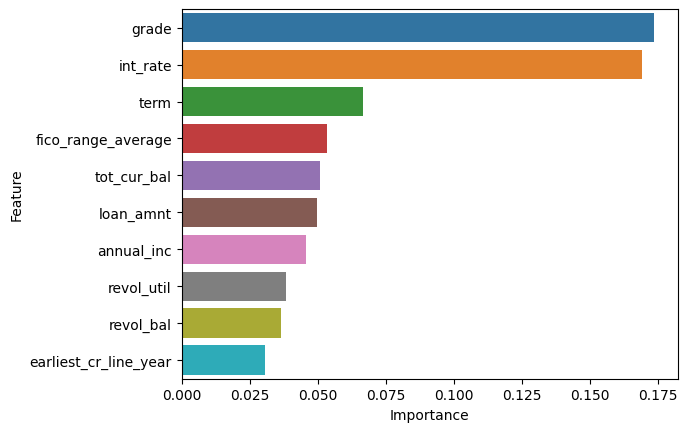

In [250]:
feature_columns = encoded_train_with_dropped_cols.drop(columns='loan_status').columns.values
important = pd.DataFrame({"Feature":feature_columns, "Importance":important_features})
important = important.sort_values(by = 'Importance', ascending = False)
sns.barplot(x= 'Importance', y = 'Feature', data =important.head(10))

In [251]:
important_columns = important['Feature'].head(20).values.tolist()
print(len(important_columns), important_columns)
# print(encoded_train_with_dropped_cols.columns.tolist())

20 ['grade', 'int_rate', 'term', 'fico_range_average', 'tot_cur_bal', 'loan_amnt', 'annual_inc', 'revol_util', 'revol_bal', 'earliest_cr_line_year', 'total_acc', 'open_acc', 'mort_acc', 'num_actv_bc_tl', 'earliest_cr_line_month', 'emp_length', 'verification_status_Not Verified', 'sub_grade', 'home_ownership_MORTGAGE', 'home_ownership_RENT']


## Voting and Stacking

In [166]:
all_models = {'KNN': KNeighborsClassifier(),
        'Naive Bayes': GaussianNB(),
        'AdaBoost': AdaBoostClassifier(),
        'GBM': GradientBoostingClassifier(),
        'Xgboost': XGBClassifier(),
        'Voting_hard': VotingClassifier(estimators=[('dt', DecisionTreeClassifier()),
                                                    ('rf', RandomForestClassifier(class_weight='balanced')),
                                                    ('gmb', GradientBoostingClassifier()),
                                                    ('ada', AdaBoostClassifier()),
                                                    ('xgb', XGBClassifier())],
                                  voting='hard'),
        'Voting_soft': VotingClassifier(estimators=[('dt', DecisionTreeClassifier()),
                                                    ('rf', RandomForestClassifier(class_weight='balanced')),
                                                    ('gmb', GradientBoostingClassifier()),
                                                    ('ada', AdaBoostClassifier()),
                                                    ('xgb', XGBClassifier())],
                                  voting='soft'),
        'Voting_soft_best_model': VotingClassifier(estimators=[('lr', LogisticRegression(C=0.1, random_state=2)),
                                                    ('dt', DecisionTreeClassifier(max_depth=3, random_state=16)),
                                                    ('rf', RandomForestClassifier(class_weight='balanced',
                                                                                  criterion='entropy',
                                                                                  max_depth=10,
                                                                                  n_estimators=200,
                                                                                  oob_score=True,
                                                                                  random_state=16)),
                                                    ('gmb', GradientBoostingClassifier()),
                                                    ('ada', AdaBoostClassifier()),
                                                    ('xgb', XGBClassifier())],
                                  voting='soft'),
        'Stacking': StackingClassifier(estimators=[('dt', DecisionTreeClassifier()),
                                                    ('rf', RandomForestClassifier(class_weight='balanced')),
                                                    ('gmb', GradientBoostingClassifier()),
                                                    ('ada', AdaBoostClassifier()),
                                                    ('xgb', XGBClassifier())],
                                    final_estimator=LogisticRegression()),
        'Stacking_best_model': StackingClassifier(estimators=[('lr', LogisticRegression(C=0.1, random_state=2)),
                                                    ('dt', DecisionTreeClassifier(max_depth=3, random_state=16)),
                                                    ('rf', RandomForestClassifier(class_weight='balanced',
                                                                                  criterion='entropy',
                                                                                  max_depth=10,
                                                                                  n_estimators=200,
                                                                                  oob_score=True,
                                                                                  random_state=16)),
                                                    ('gmb', GradientBoostingClassifier()),
                                                    ('ada', AdaBoostClassifier()),
                                                    ('xgb', XGBClassifier())],
                                    final_estimator=DecisionTreeClassifier()),
        'Stacking_best_model_best_final_estimator': StackingClassifier(estimators=[('lr', LogisticRegression(C=0.1, random_state=2)),
                                                    ('dt', DecisionTreeClassifier(max_depth=3, random_state=16)),
                                                    ('rf', RandomForestClassifier(class_weight='balanced',
                                                                                  criterion='entropy',
                                                                                  max_depth=10,
                                                                                  n_estimators=200,
                                                                                  oob_score=True,
                                                                                  random_state=16)),
                                                    ('gmb', GradientBoostingClassifier()),
                                                    ('ada', AdaBoostClassifier()),
                                                    ('xgb', XGBClassifier())],
                                    final_estimator=RandomForestClassifier()),
        }

In [171]:
X_train, X_test, y_train, y_test, hack_test = get_data_for_modeling([encoded_train_with_dropped_cols, hack_test_with_dropped_cols, hack_results], target_col='loan_status', important_features=[], model=None,scaling=True, sampling=True, sampling_type='undersampling')

Train Test Split...
Target Column : loan_status
Train-Test Size : 0.7,0.3
Scaling :  True
Sampling :  True
Type :  undersampling


In [172]:
X_train

array([[-0.34876727, -1.1463791 , -1.34238965, ..., -0.65735469,
         1.26060163, -0.67347147],
       [-0.61477179, -1.43195778,  0.96856519, ..., -0.65735469,
         1.26060163, -0.67347147],
       [-0.08276275, -1.1463791 , -0.57207137, ..., -0.65735469,
        -0.79327202,  1.48484388],
       ...,
       [ 0.42264583,  1.13825031,  0.19824691, ..., -0.65735469,
         1.26060163, -0.67347147],
       [-0.26896591, -0.28964307,  0.19824691, ...,  1.52124876,
        -0.79327202, -0.67347147],
       [ 0.98125532,  1.13825031,  0.19824691, ..., -0.65735469,
         1.26060163, -0.67347147]])

In [175]:
# model_name, desc, accuracy_score_train, accuracy_score_test, accuracy_score_hack_test, f1score_train, f1score_test, f1score_hack_test

for name, model in all_models.items():
  print('Model:', model)
  model.fit(X_train,y_train)
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)
  hack_test_pred = model.predict(hack_test)
  print('\t', [model, '', round(accuracy_score(y_train, train_pred), 4), round(accuracy_score(y_test, test_pred),4), round(accuracy_score(hack_results, hack_test_pred),4), round(f1_score(y_train, train_pred),4), round(f1_score(y_test, test_pred),4), round(f1_score(hack_results, hack_test_pred),4)  ])
  model_accuracy_info.append([model, '', round(accuracy_score(y_train, train_pred), 4), round(accuracy_score(y_test, test_pred),4), round(accuracy_score(hack_results, hack_test_pred),4), round(f1_score(y_train, train_pred),4), round(f1_score(y_test, test_pred),4), round(f1_score(hack_results, hack_test_pred),4)  ])
  print('\t f1 score:',round(f1_score(hack_results, hack_test_pred),4) )
  # break

Model: KNeighborsClassifier()
	 [KNeighborsClassifier(), '', 0.733, 0.5878, 0.5942, 0.7315, 0.3591, 0.3628]
	 f1 score: 0.3628
Model: GaussianNB()
	 [GaussianNB(), '', 0.6168, 0.5723, 0.5567, 0.6481, 0.3888, 0.3916]
	 f1 score: 0.3916
Model: AdaBoostClassifier()
	 [AdaBoostClassifier(), '', 0.656, 0.6304, 0.6336, 0.6646, 0.4278, 0.4252]
	 f1 score: 0.4252
Model: GradientBoostingClassifier()
	 [GradientBoostingClassifier(), '', 0.6692, 0.6261, 0.6378, 0.678, 0.4276, 0.4324]
	 f1 score: 0.4324
Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
            

### With top 20 Important features

In [252]:
important_columns+['loan_status']
print(len(important_columns), important_columns)

20 ['grade', 'int_rate', 'term', 'fico_range_average', 'tot_cur_bal', 'loan_amnt', 'annual_inc', 'revol_util', 'revol_bal', 'earliest_cr_line_year', 'total_acc', 'open_acc', 'mort_acc', 'num_actv_bc_tl', 'earliest_cr_line_month', 'emp_length', 'verification_status_Not Verified', 'sub_grade', 'home_ownership_MORTGAGE', 'home_ownership_RENT']


In [253]:
hack_test_with_dropped_cols[important_columns]

,grade,int_rate,term,fico_range_average,tot_cur_bal,loan_amnt,annual_inc,revol_util,revol_bal,earliest_cr_line_year,total_acc,open_acc,mort_acc,num_actv_bc_tl,earliest_cr_line_month,emp_length,verification_status_Not Verified,sub_grade,home_ownership_MORTGAGE,home_ownership_RENT
80000,3,13.99,36,717.0,33395,5000.0,50000.0,9.8,2568.0,2012,11.0,9.0,0,1,5,1,0,4,0,0
80001,2,10.99,36,682.0,229832,30000.0,92000.0,75.4,30394.0,2001,35.0,11.0,2,2,12,10,0,2,0,1
80002,2,10.15,60,677.0,181616,16000.0,89000.0,75.3,38400.0,1989,41.0,15.0,2,5,3,10,1,2,1,0
80003,3,13.68,36,672.0,30603,10000.0,33000.0,69.4,21224.0,2004,16.0,12.0,0,6,11,9,1,1,0,1
80004,2,14.09,36,702.0,124597,4000.0,35580.0,39.4,3471.0,1997,19.0,8.0,4,2,2,4,0,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,4,17.57,36,677.0,30397,10000.0,38500.0,60.0,5816.0,2010,10.0,10.0,0,1,9,4,1,4,0,1
99996,4,18.92,60,672.0,494439,18375.0,80000.0,75.1,13886.0,1998,30.0,9.0,5,2,12,3,0,4,1,0
99997,2,11.22,36,727.0,284915,35000.0,95000.0,60.7,43166.0,1996,29.0,10.0,4,2,5,10,0,5,1,0
99998,1,7.89,36,807.0,8205,5000.0,35000.0,4.4,1110.0,2003,19.0,9.0,0,1,3,10,1,5,1,0


In [254]:
X_train, X_test, y_train, y_test, hack_test = get_data_for_modeling([encoded_train_with_dropped_cols[important_columns+['loan_status']], hack_test_with_dropped_cols[important_columns], hack_results], target_col='loan_status', important_features=[], model=None,scaling=True, sampling=True, sampling_type='undersampling')

False
Train Test Split...
Target Column : loan_status
Train-Test Size : 0.7,0.3
Scaling :  True
Sampling :  True
Type :  undersampling


In [259]:
for name, model in all_models.items():
  print('Model:', model)
  model.fit(X_train,y_train)
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)
  hack_test_pred = model.predict(hack_test)
  print('\t', [model, '', round(accuracy_score(y_train, train_pred), 4), round(accuracy_score(y_test, test_pred),4), round(accuracy_score(hack_results, hack_test_pred),4), round(f1_score(y_train, train_pred),4), round(f1_score(y_test, test_pred),4), round(f1_score(hack_results, hack_test_pred),4)  ])
  model_accuracy_info.append([model, 'with imp 20 features only', round(accuracy_score(y_train, train_pred), 4), round(accuracy_score(y_test, test_pred),4), round(accuracy_score(hack_results, hack_test_pred),4), round(f1_score(y_train, train_pred),4), round(f1_score(y_test, test_pred),4), round(f1_score(hack_results, hack_test_pred),4)  ])
  print('\t f1 score:',round(f1_score(hack_results, hack_test_pred),4) )
  # break

Model: KNeighborsClassifier()
	 [KNeighborsClassifier(), '', 0.7336, 0.5967, 0.6028, 0.7343, 0.3722, 0.3829]
	 f1 score: 0.3829
Model: GaussianNB()
	 [GaussianNB(), '', 0.6438, 0.6159, 0.6116, 0.6596, 0.4196, 0.4196]
	 f1 score: 0.4196
Model: AdaBoostClassifier()
	 [AdaBoostClassifier(), '', 0.6571, 0.6361, 0.6378, 0.664, 0.4264, 0.4254]
	 f1 score: 0.4254
Model: GradientBoostingClassifier()
	 [GradientBoostingClassifier(), '', 0.6733, 0.6322, 0.64, 0.6792, 0.4281, 0.4272]
	 f1 score: 0.4272
Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
            

# **MODEL SUMMARY**

In [260]:
len(model_accuracy_info)

34

In [269]:
model_summary = pd.DataFrame(model_accuracy_info, columns=['model_name', 'desc', 'accuracy_score_train', 'accuracy_score_test', 'accuracy_score_hack_test', 'f1score_train', 'f1score_test', 'f1score_hack_test'])
model_summary.sort_values(by='f1score_hack_test', ascending=False)

,model_name,desc,accuracy_score_train,accuracy_score_test,accuracy_score_hack_test,f1score_train,f1score_test,f1score_hack_test
15,([DecisionTreeRegressor(criterion='friedman_ms...,,0.6692,0.6261,0.6378,0.6780,0.4276,0.4324
20,"StackingClassifier(estimators=[('dt', Decision...",,0.8439,0.6256,0.6394,0.8450,0.4288,0.4317
17,"VotingClassifier(estimators=[('dt', DecisionTr...",,0.8737,0.6266,0.6377,0.8752,0.4274,0.4308
2,Logistic Regression,"Scaling-True, Sampling-True(undersampling), Fe...",0.6527,0.6585,0.6574,0.6499,0.4335,0.4304
4,Logistic Regression,"Scaling-True, Sampling-True(undersampling), Fe...",0.6547,0.6580,0.6560,0.6518,0.4313,0.4298
3,Logistic Regression,"Scaling-True, Sampling-True(oversampling), Fea...",0.6533,0.6570,0.6562,0.6509,0.4307,0.4297
19,"VotingClassifier(estimators=[('lr', LogisticRe...",,0.7221,0.6283,0.6363,0.7290,0.4271,0.4296
1,Logistic Regression,"Scaling-True, Sampling-True(oversampling), Fea...",0.6511,0.6567,0.6553,0.6479,0.4317,0.4288
31,"StackingClassifier(estimators=[('dt', Decision...",with imp 20 features only,0.8392,0.6511,0.6600,0.8410,0.4294,0.4278
26,([DecisionTreeRegressor(criterion='friedman_ms...,with imp 20 features only,0.6733,0.6322,0.6400,0.6792,0.4281,0.4272


In [270]:
model_summary

,model_name,desc,accuracy_score_train,accuracy_score_test,accuracy_score_hack_test,f1score_train,f1score_test,f1score_hack_test
0,Logistic Regression,"Scaling-True, Sampling-False(None), FeatureSel...",0.8006,0.8008,0.8030,0.1347,0.1415,0.1435
1,Logistic Regression,"Scaling-True, Sampling-True(oversampling), Fea...",0.6511,0.6567,0.6553,0.6479,0.4317,0.4288
2,Logistic Regression,"Scaling-True, Sampling-True(undersampling), Fe...",0.6527,0.6585,0.6574,0.6499,0.4335,0.4304
3,Logistic Regression,"Scaling-True, Sampling-True(oversampling), Fea...",0.6533,0.6570,0.6562,0.6509,0.4307,0.4297
4,Logistic Regression,"Scaling-True, Sampling-True(undersampling), Fe...",0.6547,0.6580,0.6560,0.6518,0.4313,0.4298
5,Decision Tree Classifier,"Scaling-False, Sampling-True(undersampling), F...",0.6483,0.6127,0.6108,0.6648,0.4208,0.4183
6,Decision Tree Classifier,"Scaling-True, Sampling-True(undersampling), Fe...",0.6502,0.6209,0.6192,0.6603,0.4175,0.4173
7,Decision Tree Classifier,"Scaling-False, Sampling-True(oversampling), Fe...",0.7814,0.6294,0.6322,0.7956,0.3818,0.3829
8,Decision Tree Classifier,"Scaling-True, Sampling-True(undersampling), Fe...",0.6396,0.5668,0.5654,0.6750,0.4097,0.4104
9,Random Forest Classifier,"Scaling-True, Sampling-True(undersampling), Fe...",0.7036,0.6255,0.6277,0.7149,0.4280,0.4261


import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(model_summary, *['accuracy_score_train'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(model_summary, *['accuracy_score_test'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(model_summary, *['accuracy_score_hack_test'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(model_summary, *['f1score_train'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(model_summary, *['desc'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plot(df, x_colname, y_colname, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(6 * figscale, 6 * figscale))
  df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha)
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plot(model_summary, *['accuracy_score_train', 'accuracy_score_test'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plot(df, x_colname, y_colname, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(6 * figscale, 6 * figscale))
  df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha)
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plot(model_summary, *['accuracy_score_test', 'accuracy_score_hack_test'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plot(df, x_colname, y_colname, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(6 * figscale, 6 * figscale))
  df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha)
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plot(model_summary, *['accuracy_score_hack_test', 'f1score_train'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plot(df, x_colname, y_colname, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(6 * figscale, 6 * figscale))
  df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha)
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plot(model_summary, *['f1score_train', 'f1score_test'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(model_summary, *['accuracy_score_train'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(model_summary, *['accuracy_score_test'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(model_summary, *['accuracy_score_hack_test'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(model_summary, *['f1score_train'], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(model_summary, *['accuracy_score_train', 'desc'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(model_summary, *['accuracy_score_test', 'desc'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(model_summary, *['accuracy_score_hack_test', 'desc'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(model_summary, *['f1score_train', 'desc'], **{'inner': 'stick'})
chart

## ***BEST MODEL***

In [280]:
model_summary.sort_values(by='f1score_hack_test', ascending=False)['model_name'].iloc[0]

GradientBoostingClassifier()